# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
# Используйте ячейки типа Code для вашего кода,
# а ячейки типа Markdown для комментариев и выводов

In [2]:
# При необходимости добавляйте новые ячейки для кода или текста

In [3]:
import pandas as pd
from sqlalchemy import create_engine 
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix

import os
from dotenv import load_dotenv

In [4]:
load_dotenv()

db_config = {'user': os.getenv('USER'), # имя пользователя
             'pwd': os.getenv('PWD_DB'), # пароль
             'host': os.getenv('HOST'),
             'port': os.getenv('PORT'), # порт подключения
             'db': os.getenv('DB') # название базы данных
             } 

In [5]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [6]:
engine = create_engine(connection_string)

In [7]:
query = '''
SELECT user_id,
    device_type_canonical,
    order_id,
    created_dt_msk as order_dt,
    created_ts_msk as order_ts,
    currency_code,
    revenue,
    tickets_count,
      created_dt_msk::date - LAG(created_dt_msk::date ) 
        OVER(PARTITION BY user_id ORDER BY created_dt_msk)
        AS days_since_prev,
    event_id,
    e.event_name_code as event_name,
    e.event_type_main,
    service_name,
    r.region_name,
    c.city_name
FROM afisha.purchases
JOIN afisha.events e USING (event_id)
JOIN afisha.city c ON e.city_id = c.city_id
JOIN afisha.regions r ON c.region_id = r.region_id
WHERE device_type_canonical IN ('mobile', 'desktop') AND e.event_type_main != 'фильм'
ORDER BY user_id
'''

In [ ]:
df = pd.read_sql_query(query, con=engine)

In [ ]:
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [ ]:
df.shape

(290611, 15)

In [ ]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  str           
 1   device_type_canonical  290611 non-null  str           
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[us]
 4   order_ts               290611 non-null  datetime64[us]
 5   currency_code          290611 non-null  str           
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  str           
 11  event_type_main        290611 non-null  str           
 12  service_name           290611 non-null  str           


Выгруженные данные содержат 290611 строк и содержат всю необходимую информацию о заказах пользователей Яндекс.Афиши. Некоторые колонки требуют корректировки типов данных, что будет сделано в дальнейшем.  

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [ ]:
tenge = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [ ]:
tenge.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [ ]:
tenge.info()

<class 'pandas.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    str    
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    str    
dtypes: float64(1), int64(1), str(2)
memory usage: 11.3 KB


In [ ]:
#приведем дату к правильному типу данных

tenge['data'] = pd.to_datetime(tenge['data'])

In [ ]:
#совместим курс тенге с исходной таблицей согласно датам

df = df.merge(tenge[['curs', 'data']], left_on='order_dt', right_on='data')

In [ ]:
#переведем значения в тенге в рубли и удалим вспомогательные колонки

df['revenue_rub'] = df['revenue'].where(df['currency_code'] == 'rub', df['revenue'] * df['curs'] / 100)
df = df.drop(labels=['data', 'curs'], axis=1)

In [ ]:
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк,1390.41


---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [ ]:
df.isnull().sum()

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
revenue_rub                  0
dtype: int64

In [ ]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  str           
 1   device_type_canonical  290611 non-null  str           
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[us]
 4   order_ts               290611 non-null  datetime64[us]
 5   currency_code          290611 non-null  str           
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  str           
 11  event_type_main        290611 non-null  str           
 12  service_name           290611 non-null  str           


In [ ]:
# tickets_count точно целочисленный

df['tickets_count'] = pd.to_numeric(df['tickets_count'], errors='coerce', downcast='integer')

In [ ]:
#нормализация данных в текстовых столбцах

text_columns = ['device_type_canonical', 'event_name', 'event_type_main', 'service_name', 'region_name', 'city_name']

for column in text_columns:
    df[column] = df[column].replace(r'\s+', ' ', regex=True).str.strip().str.lower()

In [ ]:
df.describe()

,order_id,order_dt,order_ts,revenue,tickets_count,days_since_prev,event_id,revenue_rub
count,2.906110e+05,290611,290611,290611.000000,290611.000000,268678.000000,290611.000000,290611.000000
mean,4.326225e+06,2024-09-01 22:36:38.741272,2024-09-02 13:31:19.397731,625.584360,2.754311,3.222381,438019.834992,555.571987
min,1.000000e+00,2024-06-01 00:00:00,2024-06-01 00:00:42,-90.760000,1.000000,0.000000,4436.000000,-90.760000
25%,2.163618e+06,2024-07-30 00:00:00,2024-07-30 11:53:37.500000,116.850000,2.000000,0.000000,361772.000000,113.970000
50%,4.326366e+06,2024-09-12 00:00:00,2024-09-12 14:02:10,356.010000,3.000000,0.000000,498275.000000,351.140000
75%,6.488330e+06,2024-10-09 00:00:00,2024-10-09 15:57:55.500000,810.130000,4.000000,1.000000,546287.000000,802.050000
max,8.653108e+06,2024-10-31 00:00:00,2024-10-31 23:59:54,81174.540000,57.000000,148.000000,592325.000000,81174.540000
std,2.497551e+06,NaN,NaN,1227.693064,1.170620,11.350509,147423.078841,875.498172


In [ ]:
number_columns = ['tickets_count', 'revenue_rub']

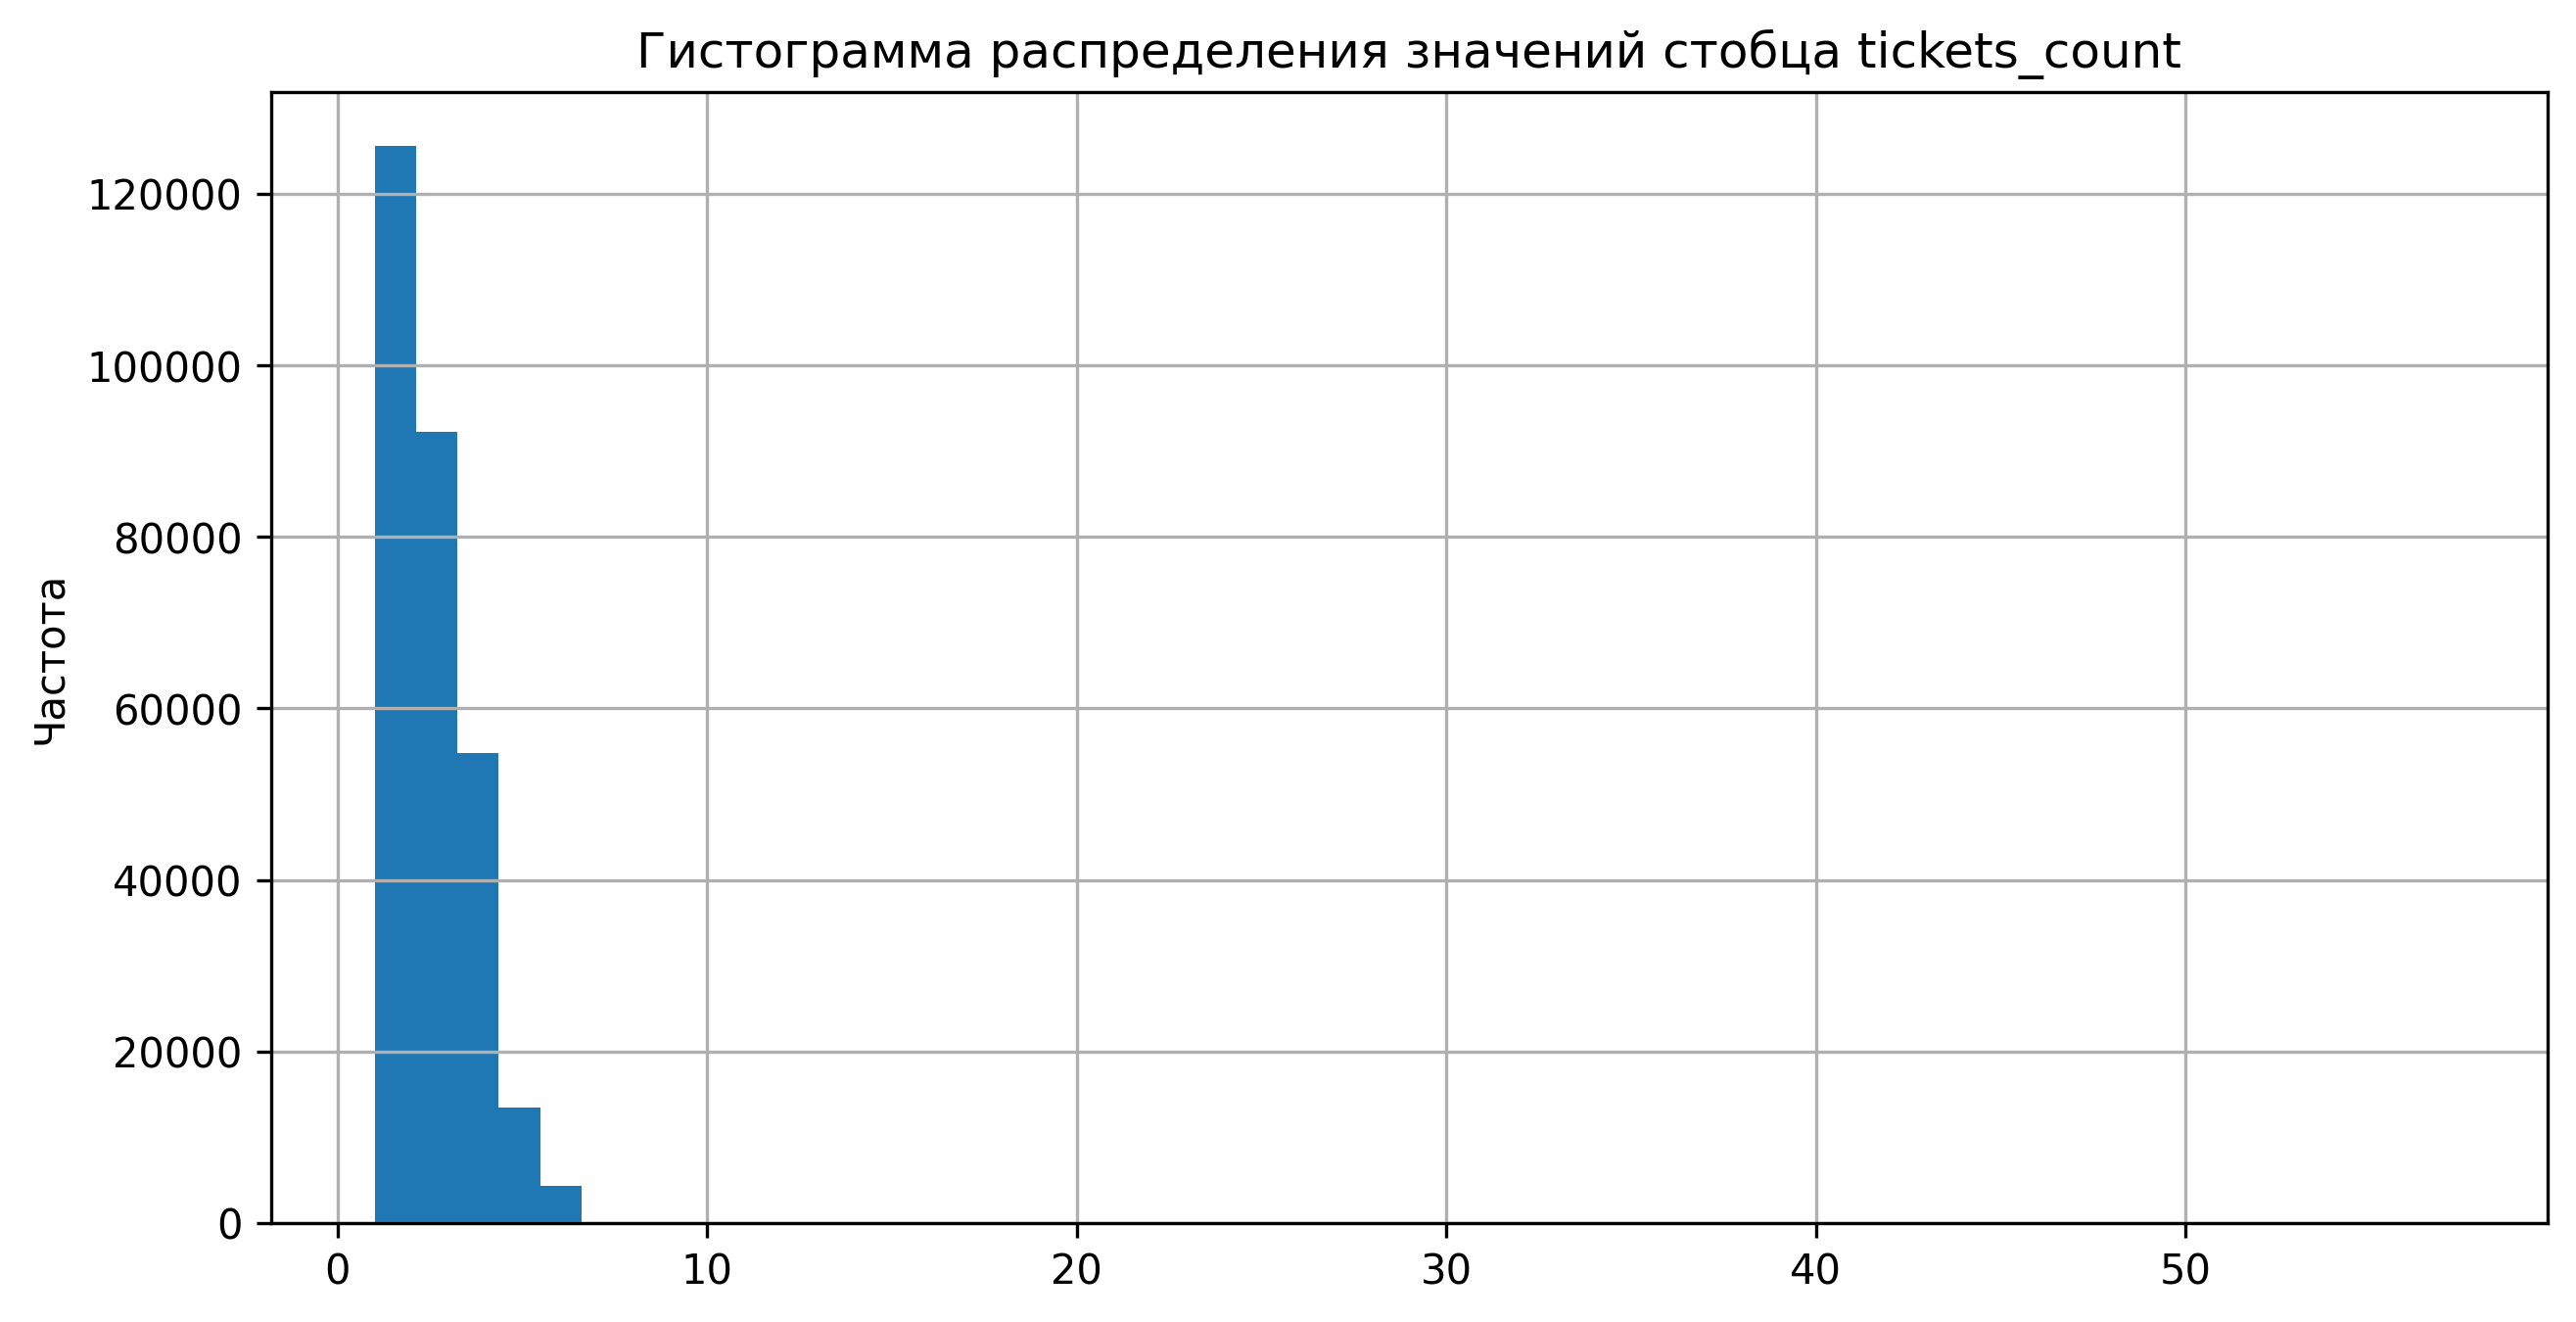

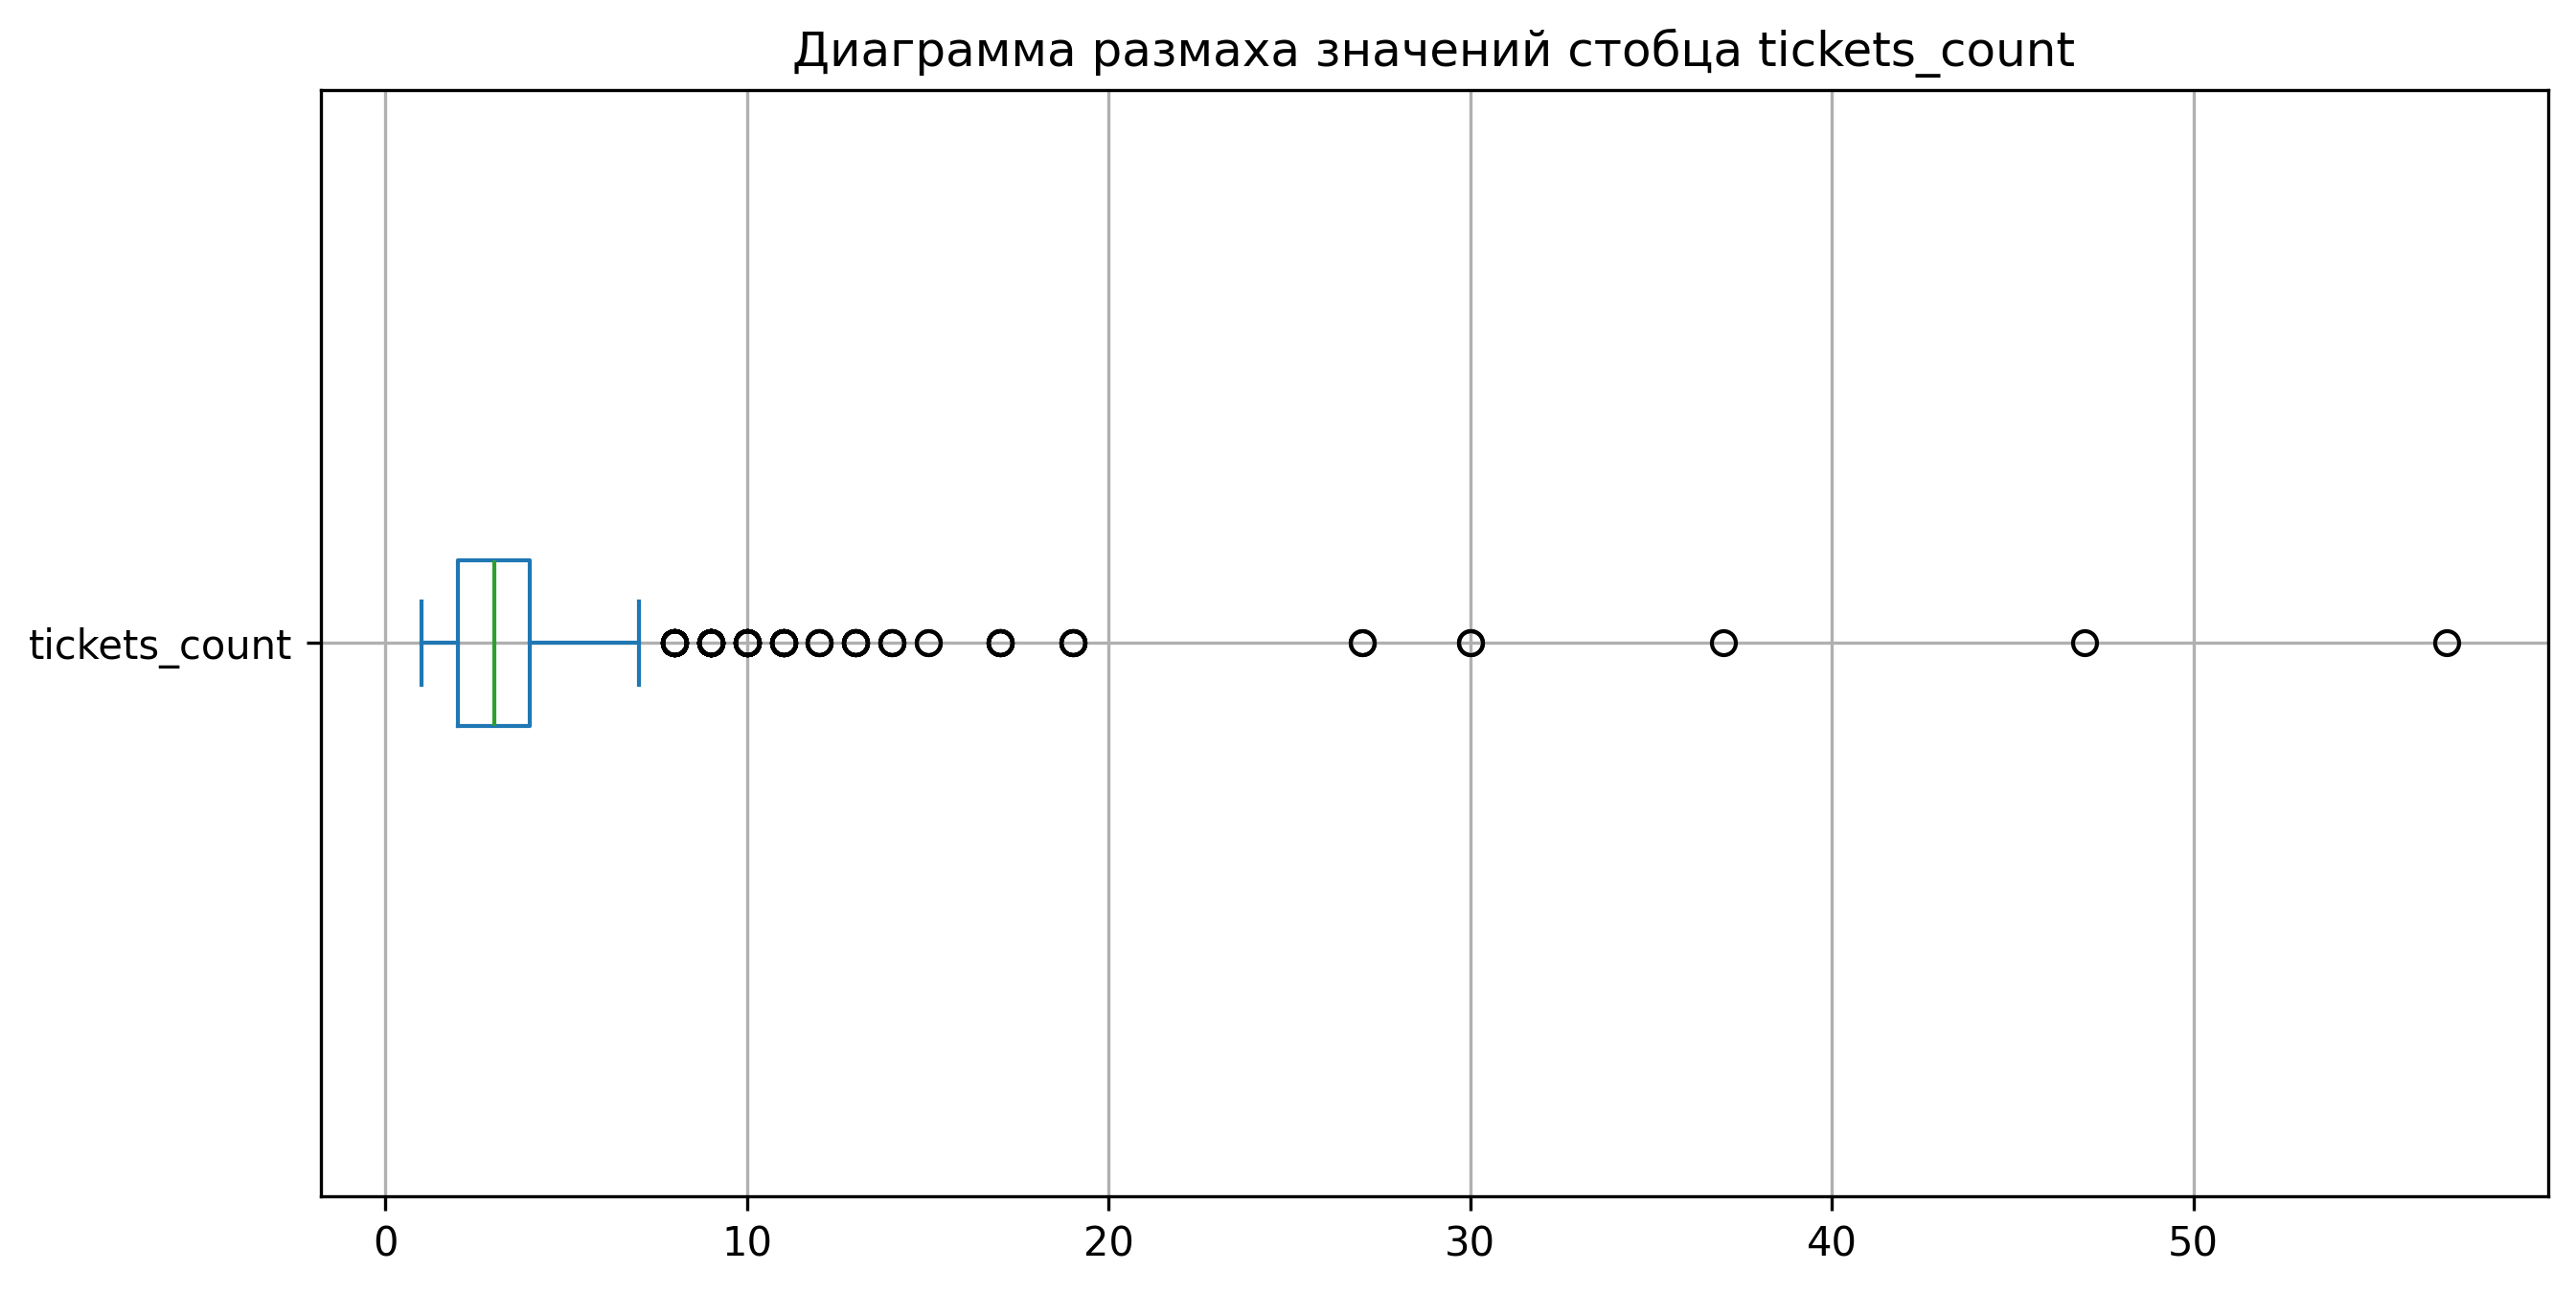

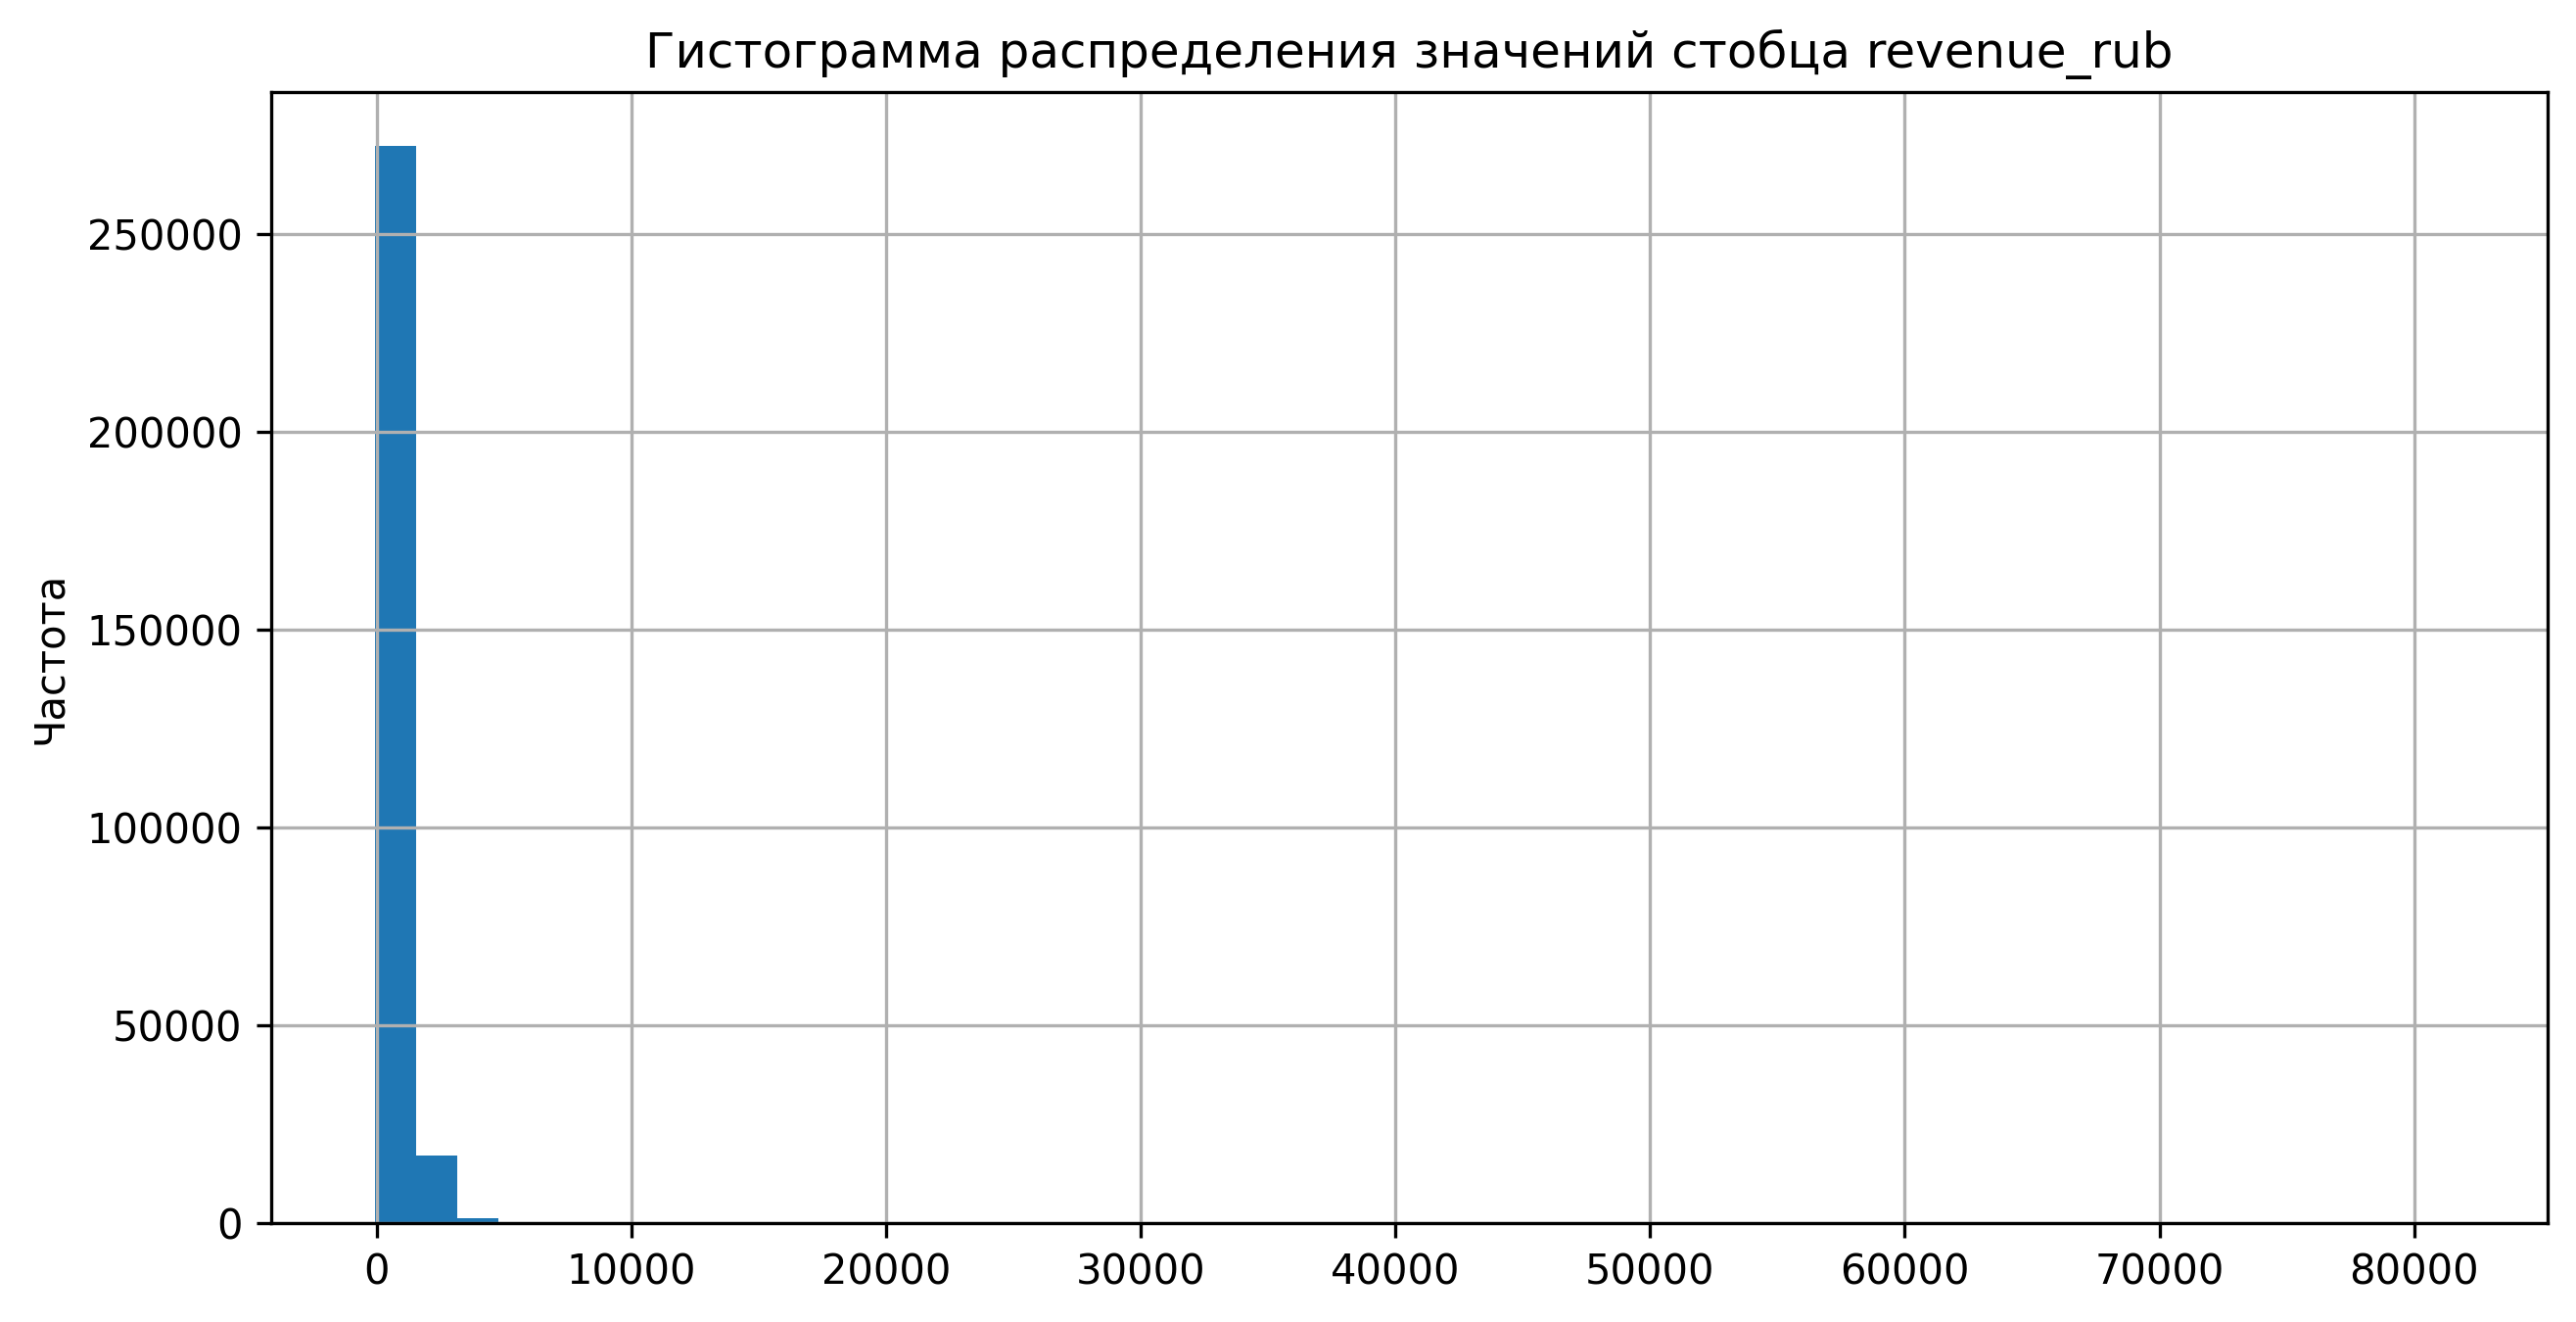

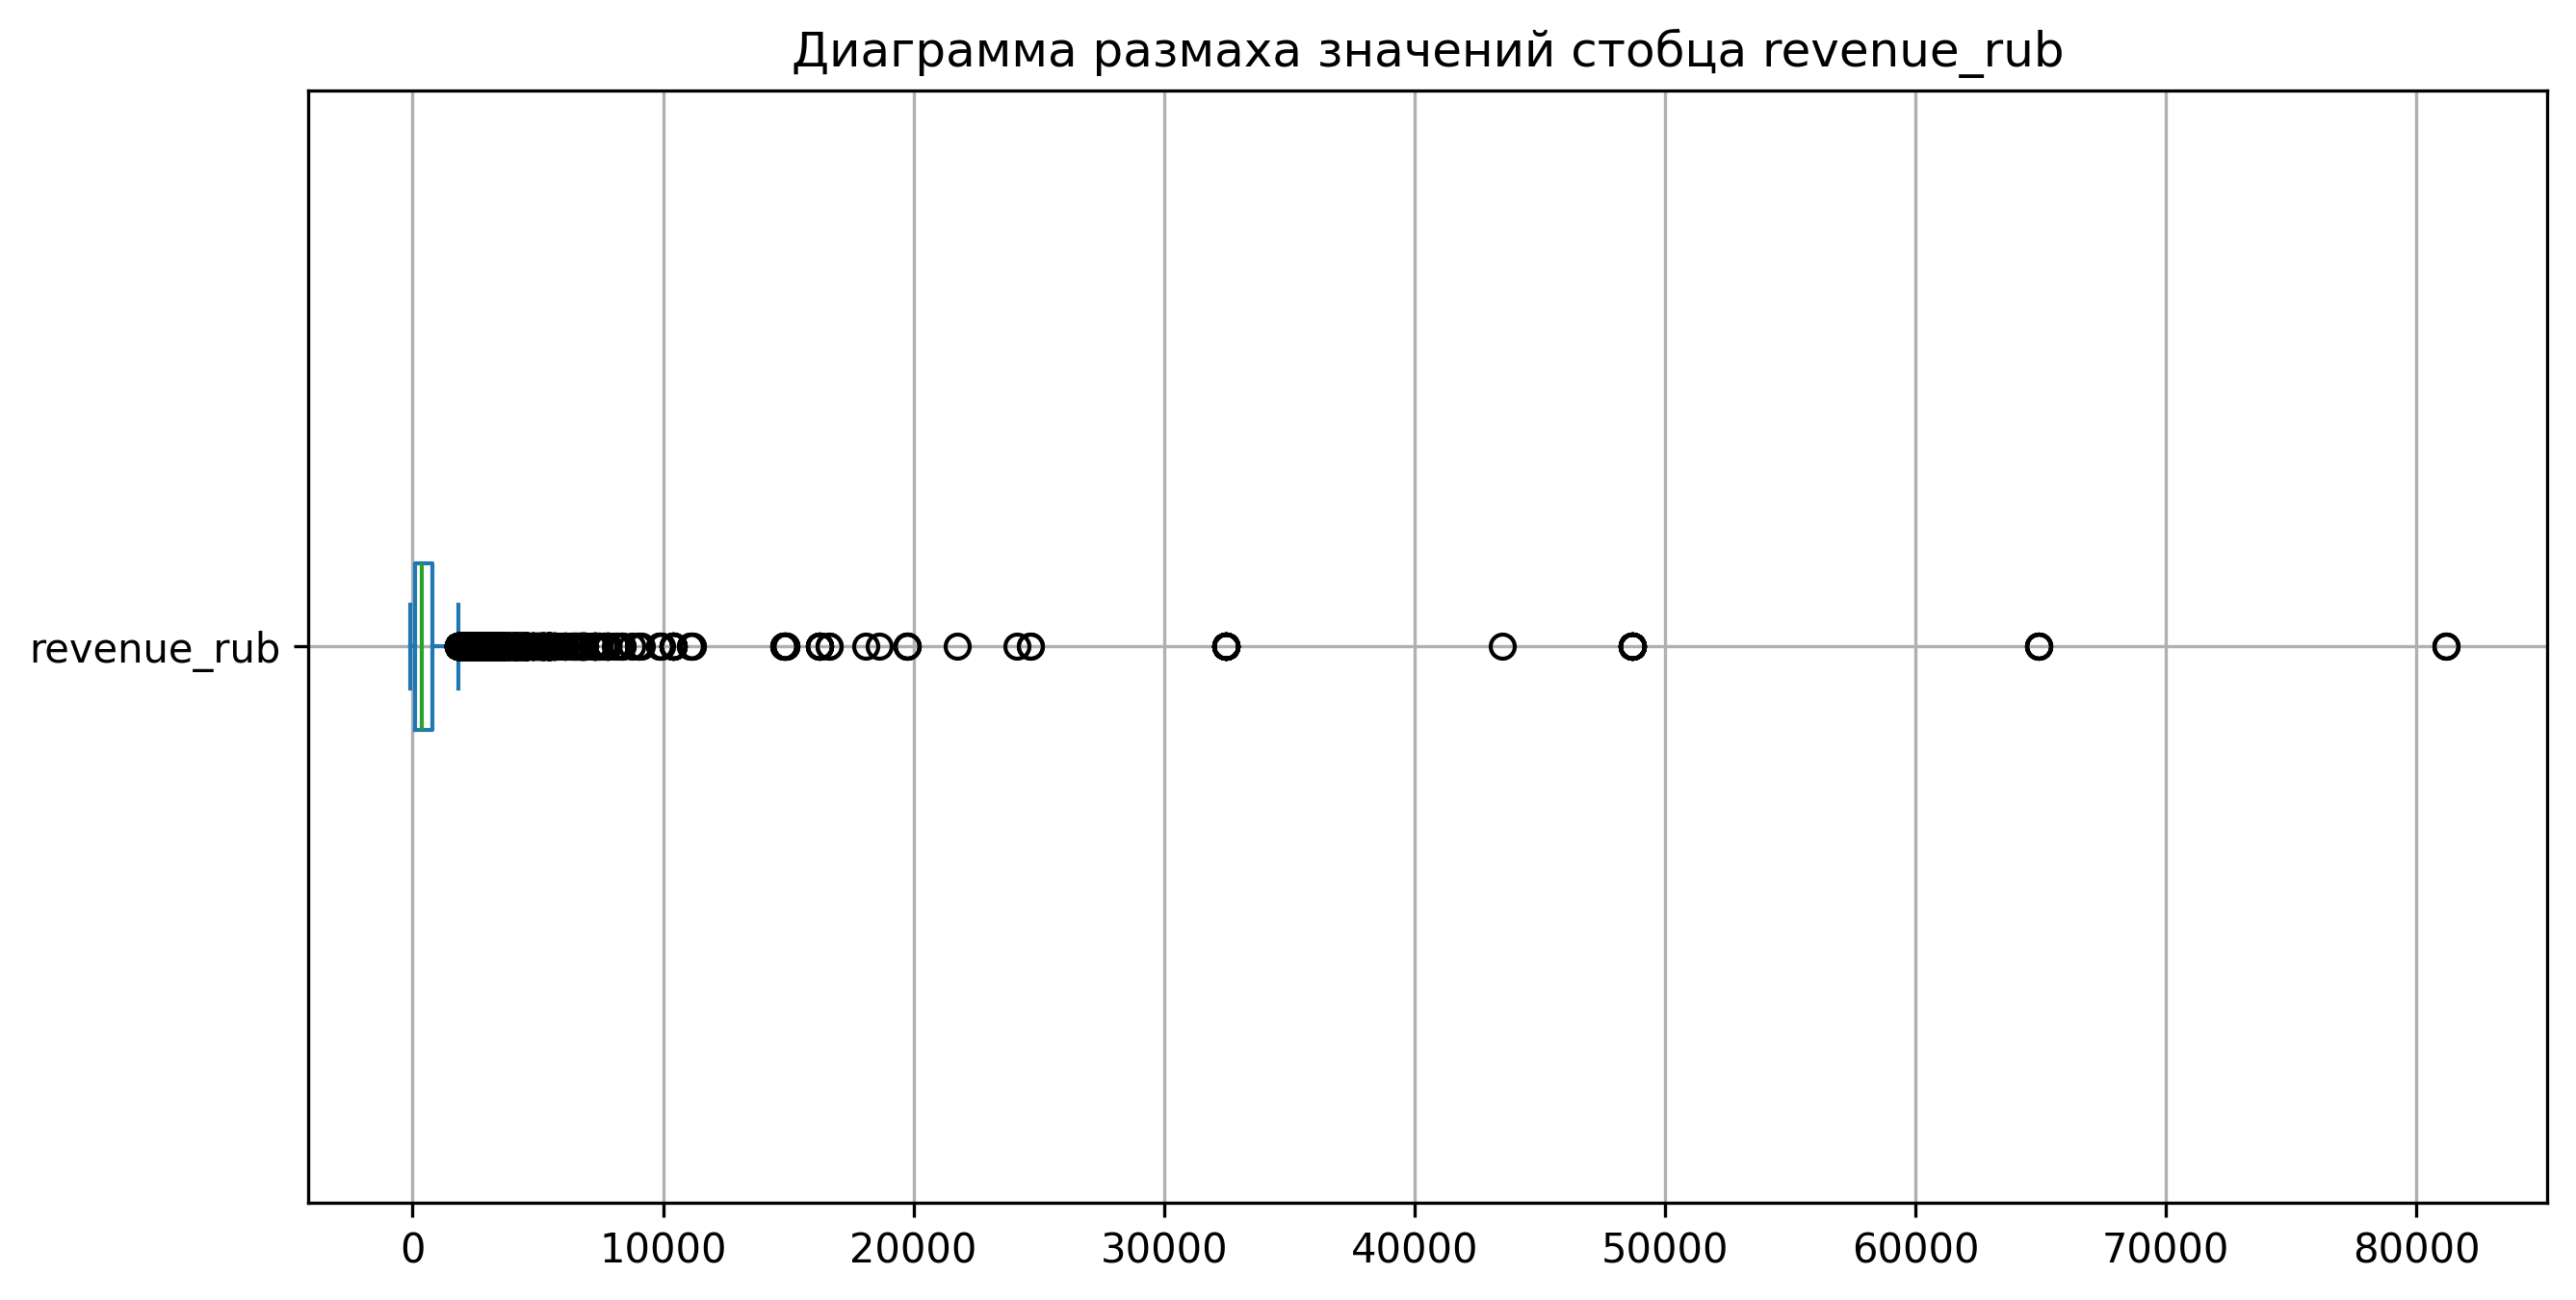

In [ ]:
for column in number_columns:
    plt.figure(figsize = (10, 5), dpi = 300)
    df[column].plot(kind = 'hist', bins = 50, grid = True, 
                    title = f'Гистограмма распределения значений стобца {column}')
    plt.ylabel('Частота')
    
    plt.figure(figsize = (10, 5), dpi = 300)
    df[column].plot(kind = 'box', vert = False, grid = True, 
                    title = f'Диаграмма размаха значений стобца {column}')

In [ ]:
prev_size = df.shape[0]
prev_size

290611

In [ ]:
df = df[(df['revenue_rub'] >= 0) & (df['revenue_rub'] < df['revenue_rub'].quantile(0.99))]
curr_size = df.shape[0]
curr_size

287223

In [ ]:
print(f'Отфильтровано {round(100.0*(prev_size-curr_size)/prev_size,2)} процентов данных')

Отфильтровано 1.17 процентов данных


Пропуски содержит только колонка days_since_prev, что говорит о правильности загрузки данных. Была проведена оптимизация типов некоторых колонок и нормализация данных в текстовых столбцах. Данные были отфильтрованы по выручке с заказа (revenue_rub) по 99 перцентилю, поскольку этот показатель содержит явные выбросы.

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [ ]:
df = df.sort_values(by='order_ts')

In [ ]:
user_profile = df.groupby('user_id').agg({'order_ts':['first', 'last'],
                                          'device_type_canonical': 'first',
                                          'region_name': 'first',
                                          'service_name': 'first',
                                          'event_type_main': 'first',
                                          'user_id': 'count',
                                          'revenue_rub': 'mean',
                                          'tickets_count': 'mean',
                                           'days_since_prev': 'mean'}).reset_index()

user_profile.columns = ['user_id', 'first_order_date', 'last_order_date', 
                       'device_first', 'region_first', 'service_first',
                       'event_type_first', 'total_orders', 
                        'mean_revenue', 'mean_tickets_count', 'mean_days_since_prev']
user_profile.head()

,user_id,first_order_date,last_order_date,device_first,region_first,service_first,event_type_first,total_orders,mean_revenue,mean_tickets_count,mean_days_since_prev
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,mobile,каменевский регион,край билетов,театр,1,1521.940000,4.000000,NaN
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,mobile,каменевский регион,мой билет,выставки,2,774.010000,3.000000,75.0
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,mobile,североярская область,лови билет!,другое,3,767.213333,2.666667,51.0
3,00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,desktop,каменевский регион,край билетов,театр,1,917.830000,4.000000,NaN
4,000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,mobile,поленовский край,лучшие билеты,театр,2,61.310000,1.500000,16.0


In [ ]:
user_profile['is_two'] = user_profile['total_orders'] >= 2
user_profile['is_five'] = user_profile['total_orders'] >= 5
user_profile.head()

,user_id,first_order_date,last_order_date,device_first,region_first,service_first,event_type_first,total_orders,mean_revenue,mean_tickets_count,mean_days_since_prev,is_two,is_five
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,mobile,каменевский регион,край билетов,театр,1,1521.940000,4.000000,NaN,False,False
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,mobile,каменевский регион,мой билет,выставки,2,774.010000,3.000000,75.0,True,False
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,mobile,североярская область,лови билет!,другое,3,767.213333,2.666667,51.0,True,False
3,00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,desktop,каменевский регион,край билетов,театр,1,917.830000,4.000000,NaN,False,False
4,000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,mobile,поленовский край,лучшие билеты,театр,2,61.310000,1.500000,16.0,True,False


---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [ ]:
print(f'Общее число пользователей в выборке = {user_profile.shape[0]}')
print(f'Средняя выручка с одного заказа = {round(user_profile["mean_revenue"].mean(),2)}')
print(f'Доля пользователей, совершивших 2 и более заказа = {round(user_profile["is_two"].mean(),2)}')
print(f'Доля пользователей, совершивших 5 и более заказов = {round(user_profile["is_five"].mean(),2)}')

Общее число пользователей в выборке = 21832
Средняя выручка с одного заказа = 544.02
Доля пользователей, совершивших 2 и более заказа = 0.62
Доля пользователей, совершивших 5 и более заказов = 0.29


In [ ]:
number_columns = ['total_orders', 'mean_tickets_count', 'mean_days_since_prev']
user_profile[number_columns].describe()

,total_orders,mean_tickets_count,mean_days_since_prev
count,21832.000000,21832.000000,13508.000000
mean,13.156055,2.743852,15.859534
std,121.526670,0.913391,22.321504
min,1.000000,1.000000,0.000000
25%,1.000000,2.000000,1.000000
50%,2.000000,2.750000,8.000000
75%,5.000000,3.080000,20.428571
max,10162.000000,11.000000,148.000000


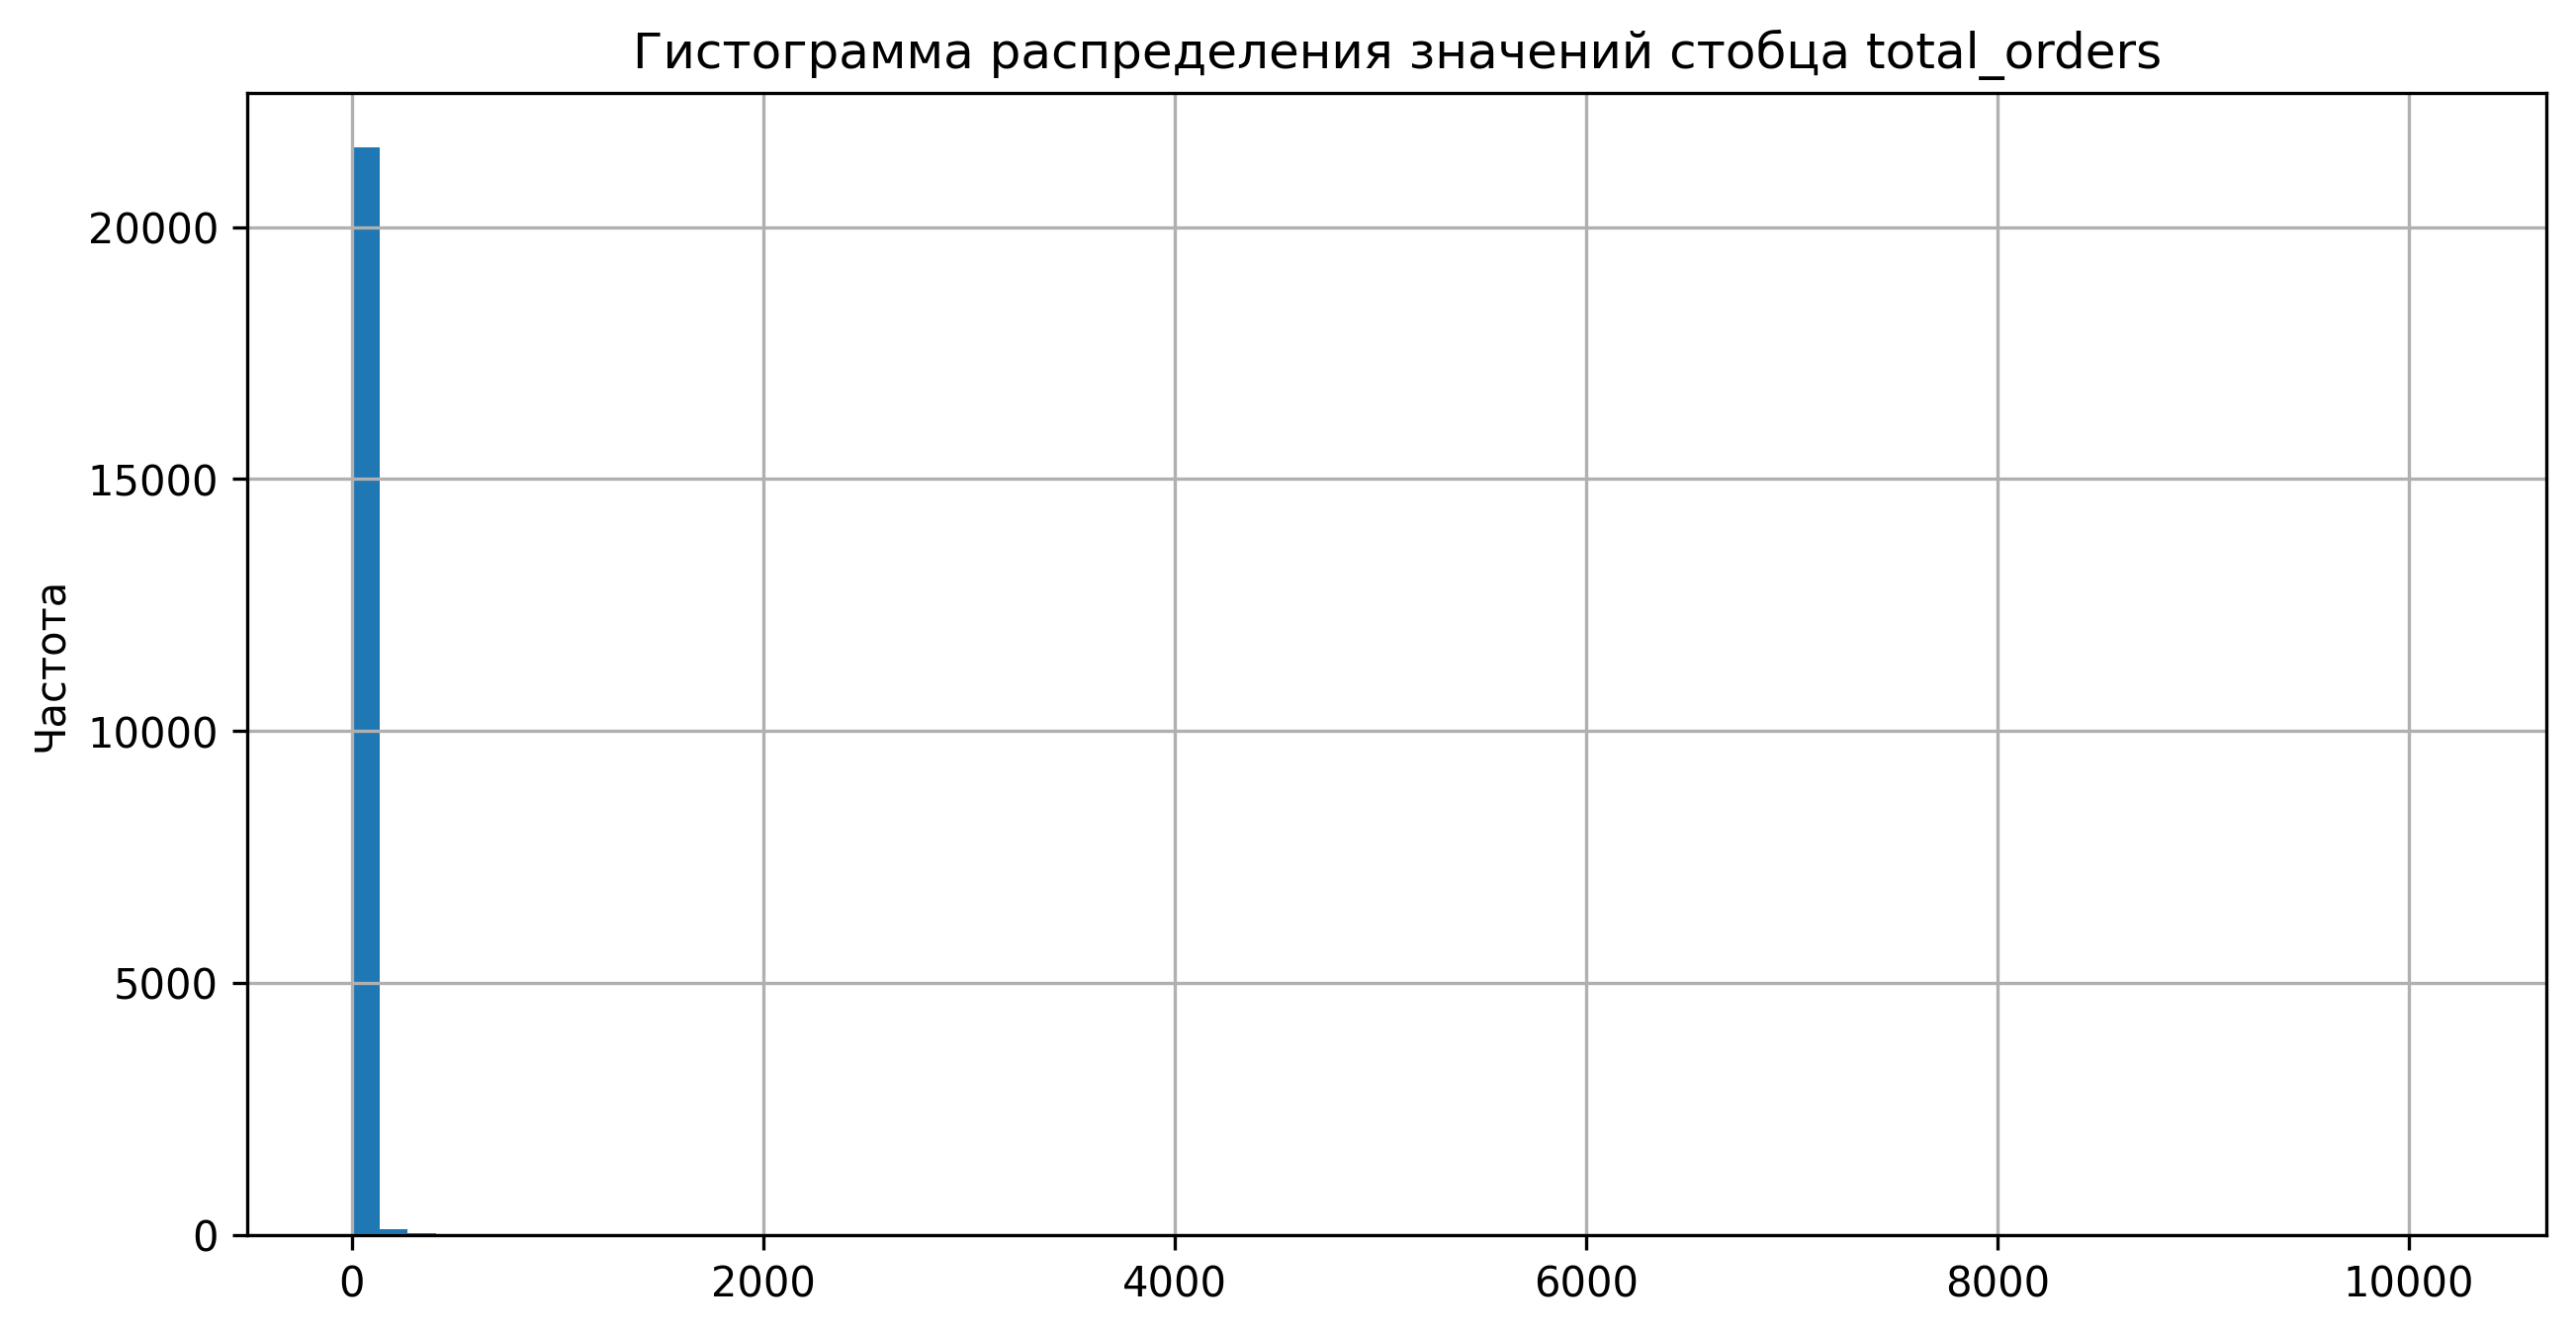

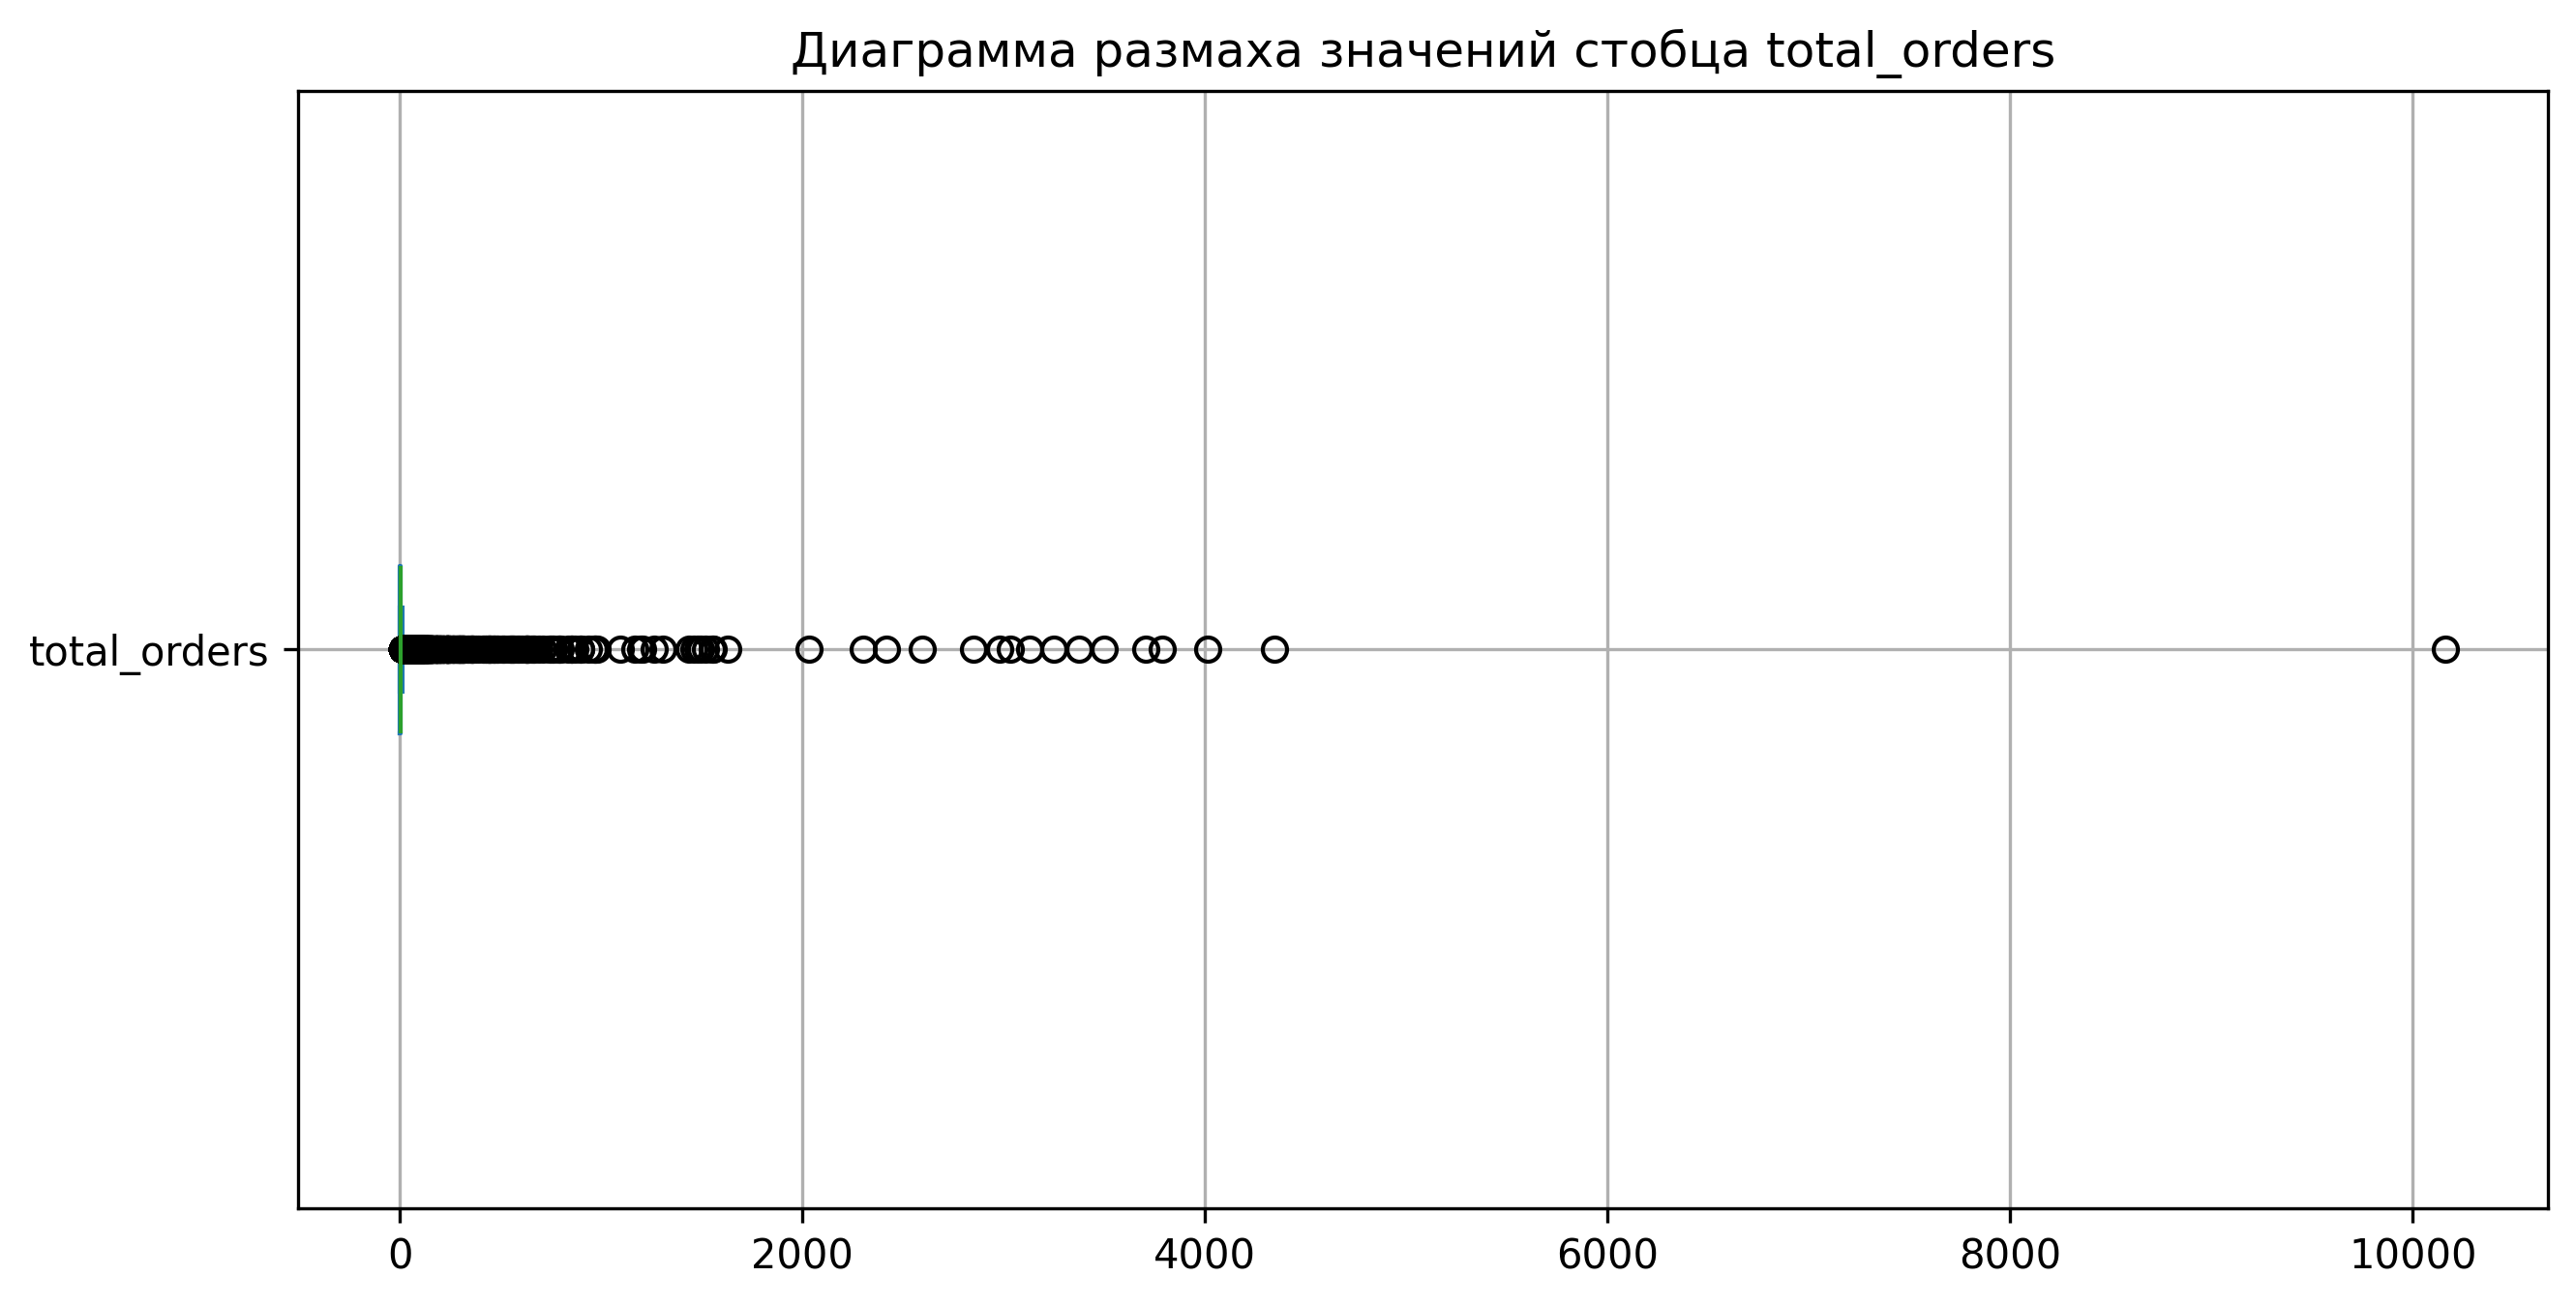

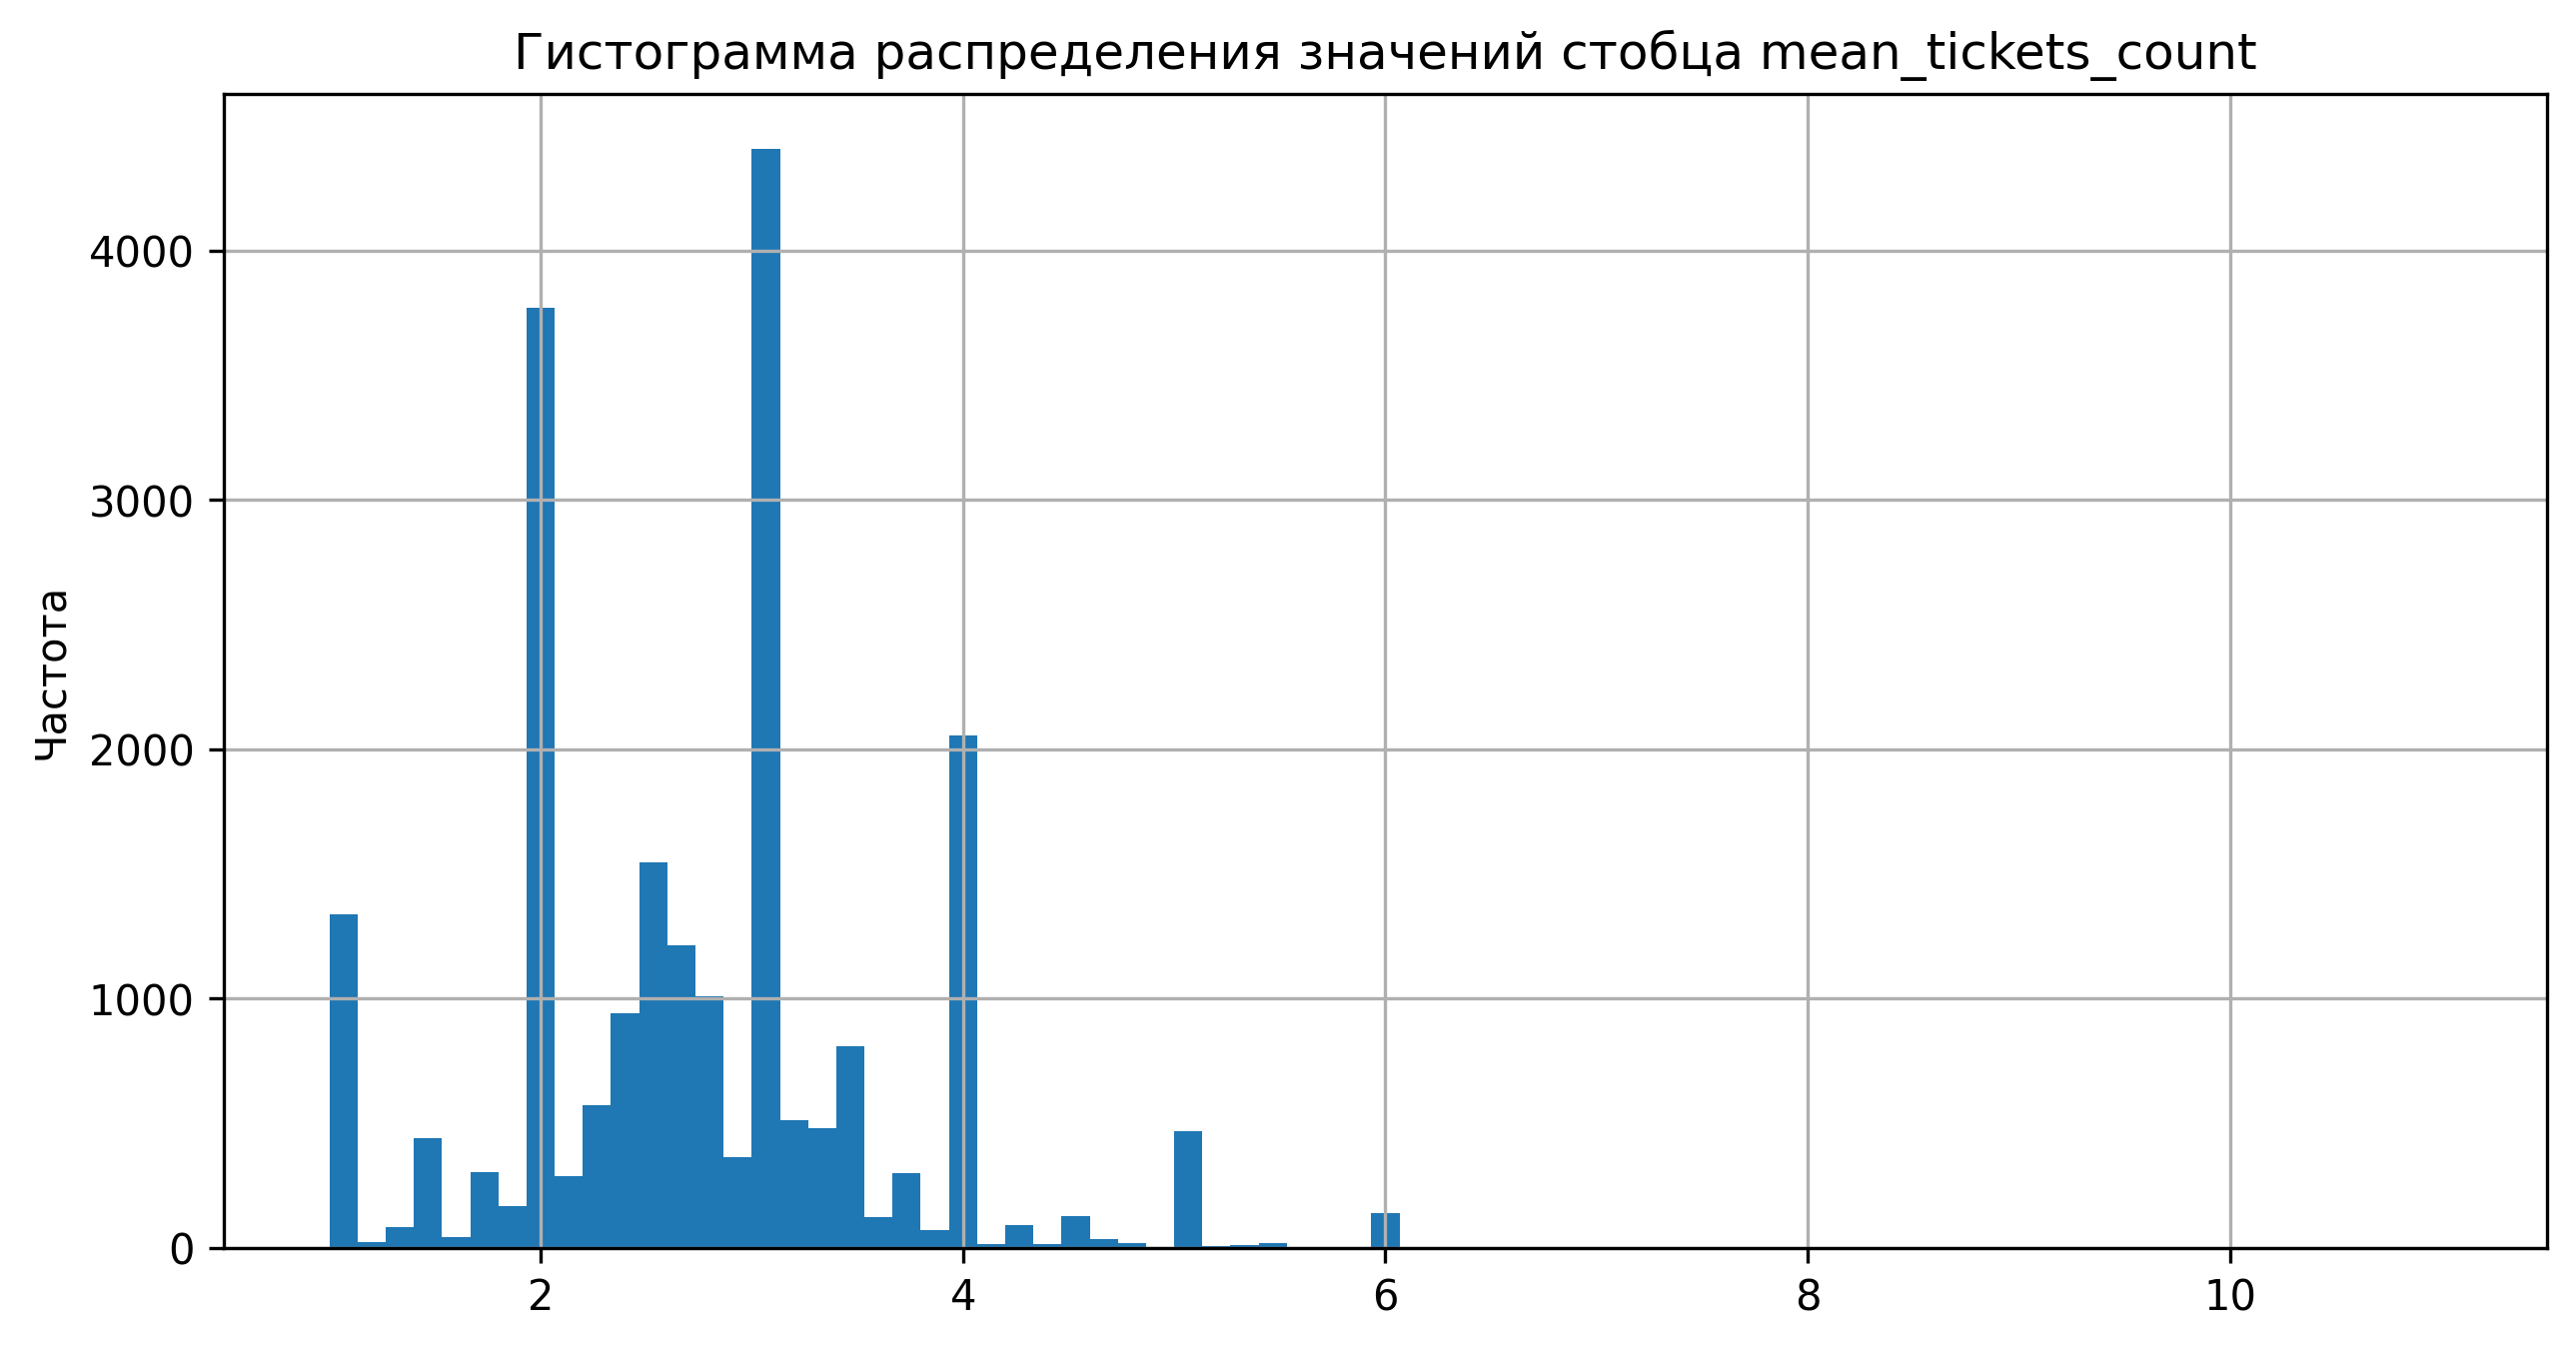

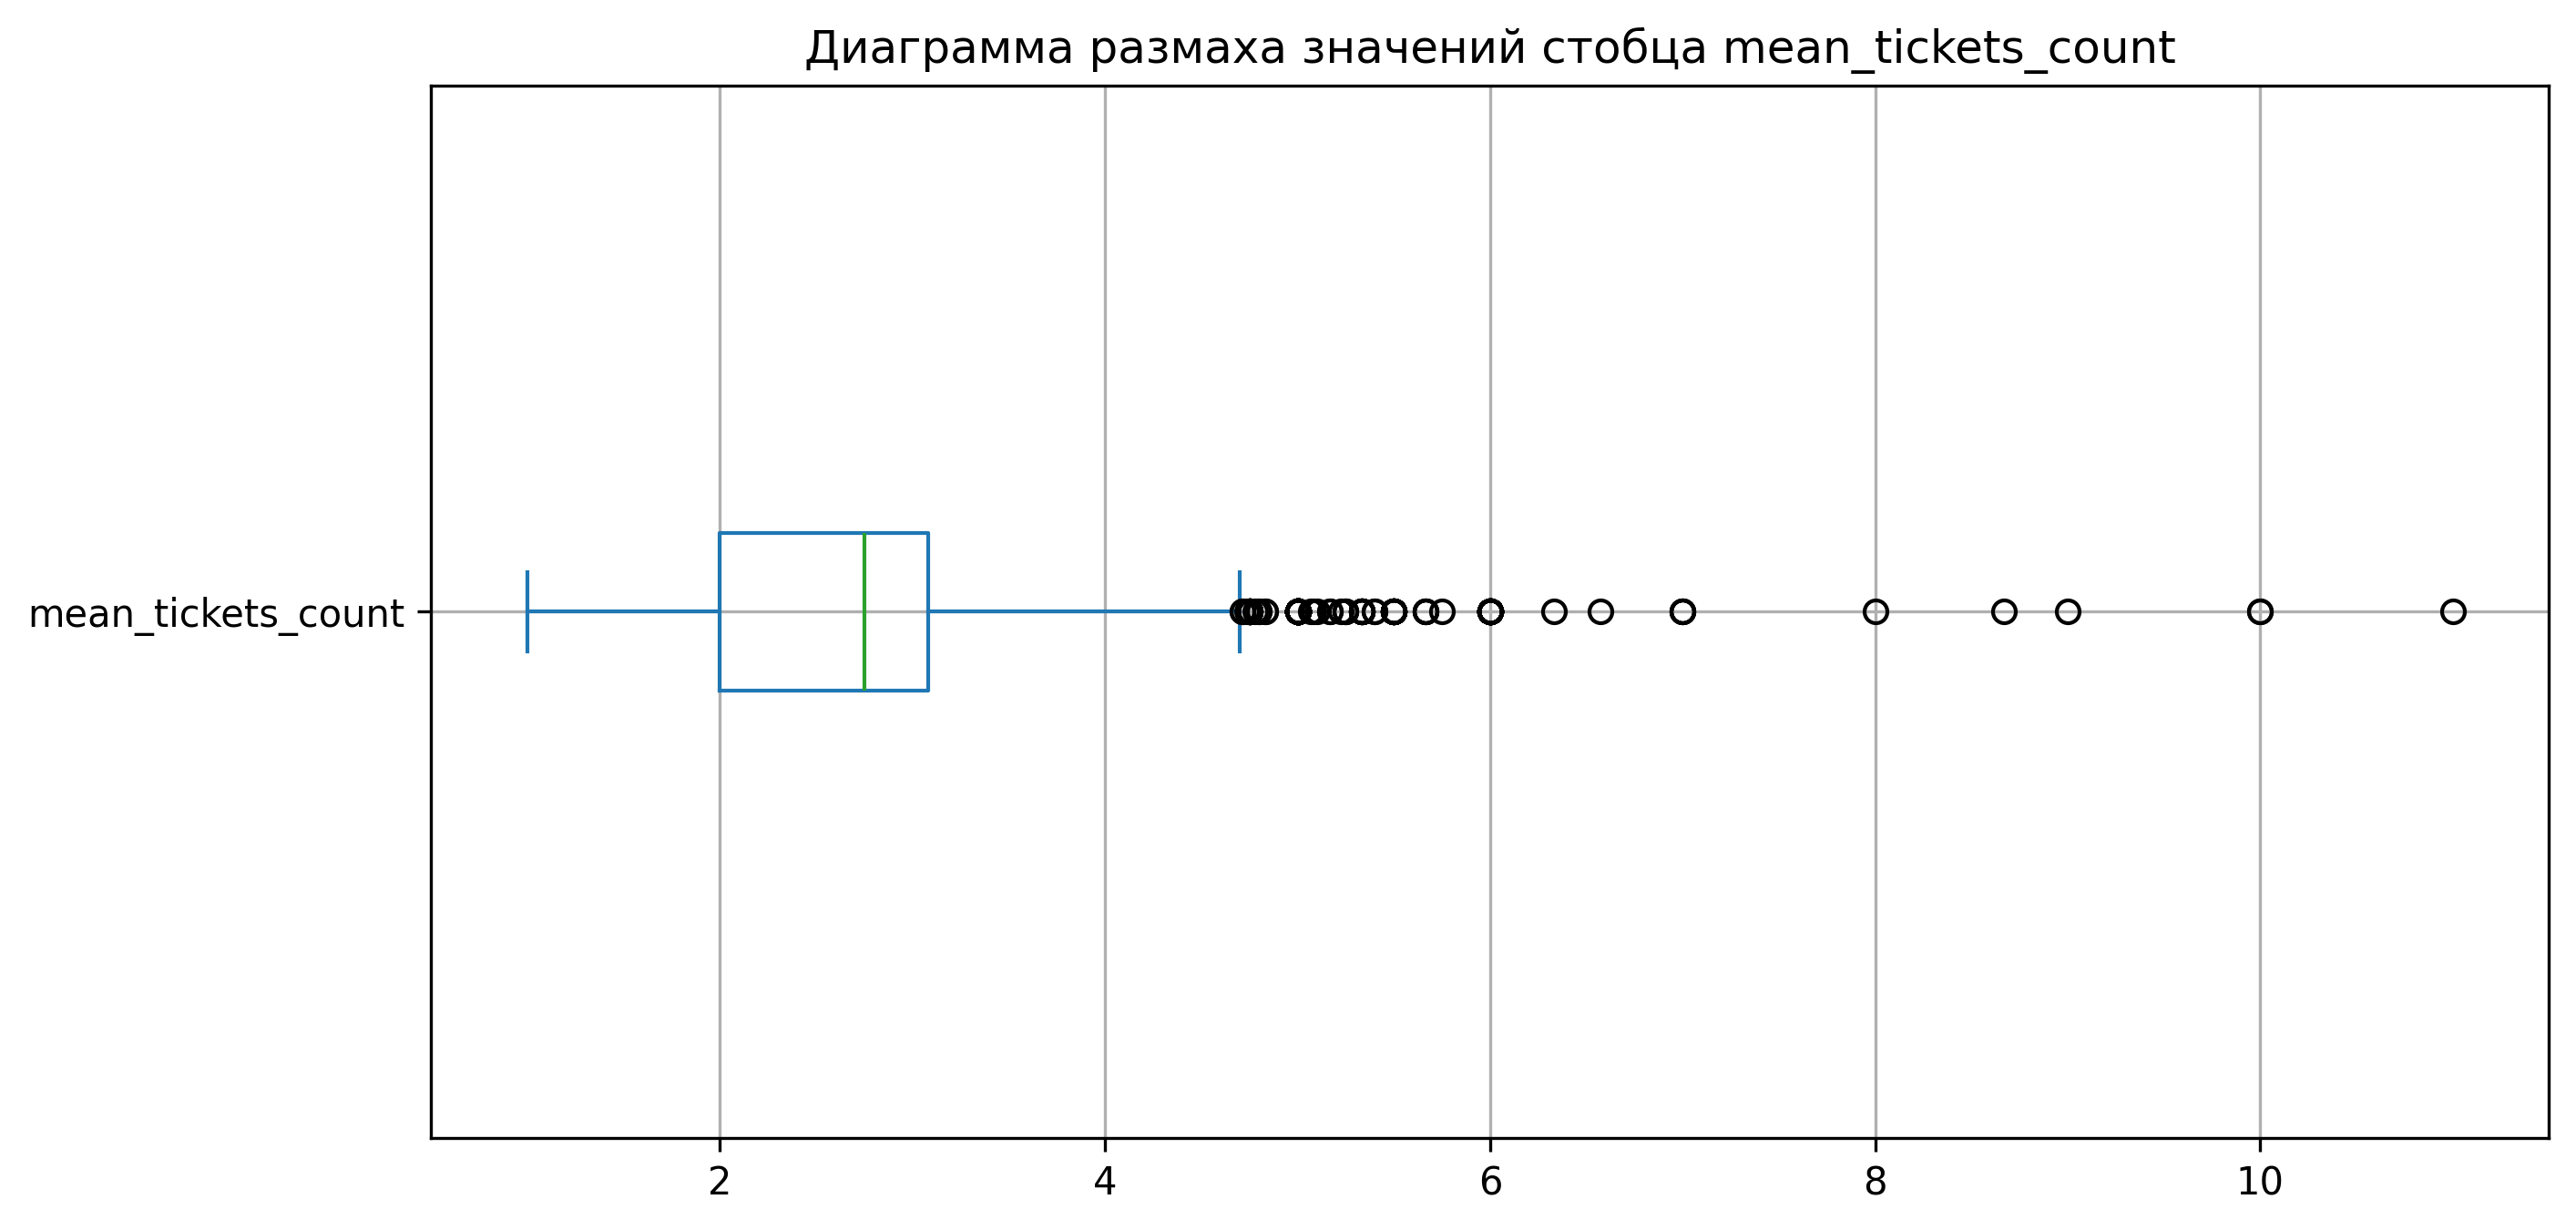

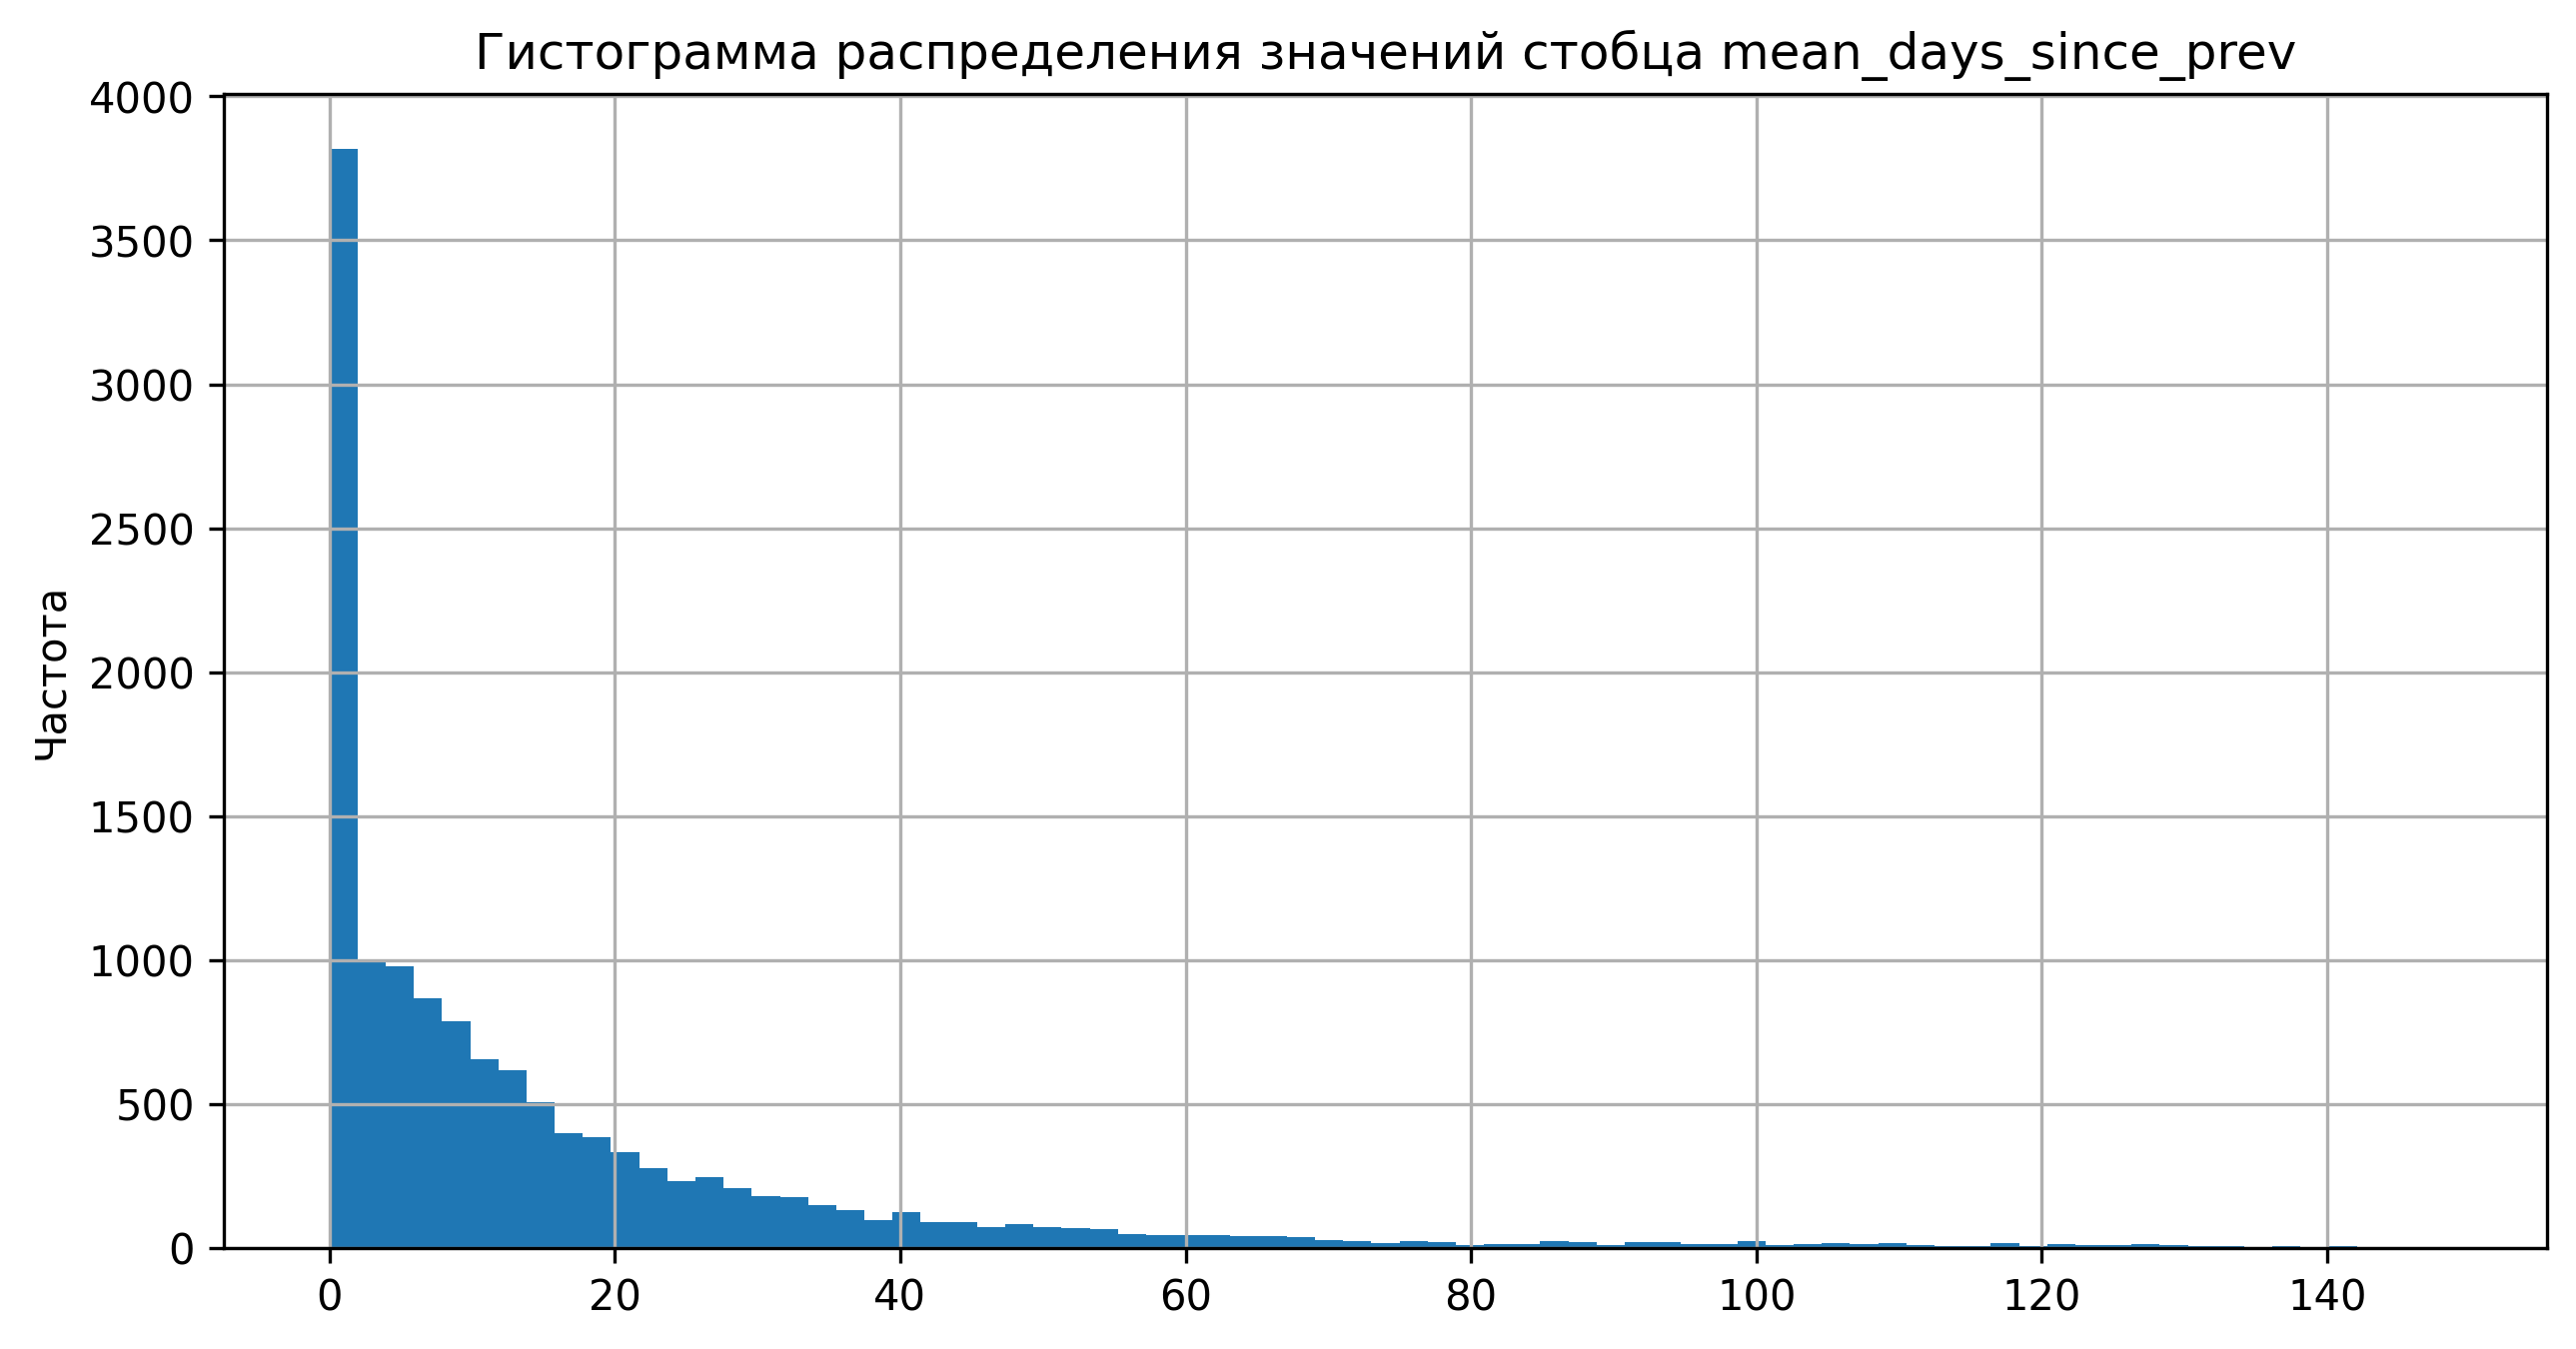

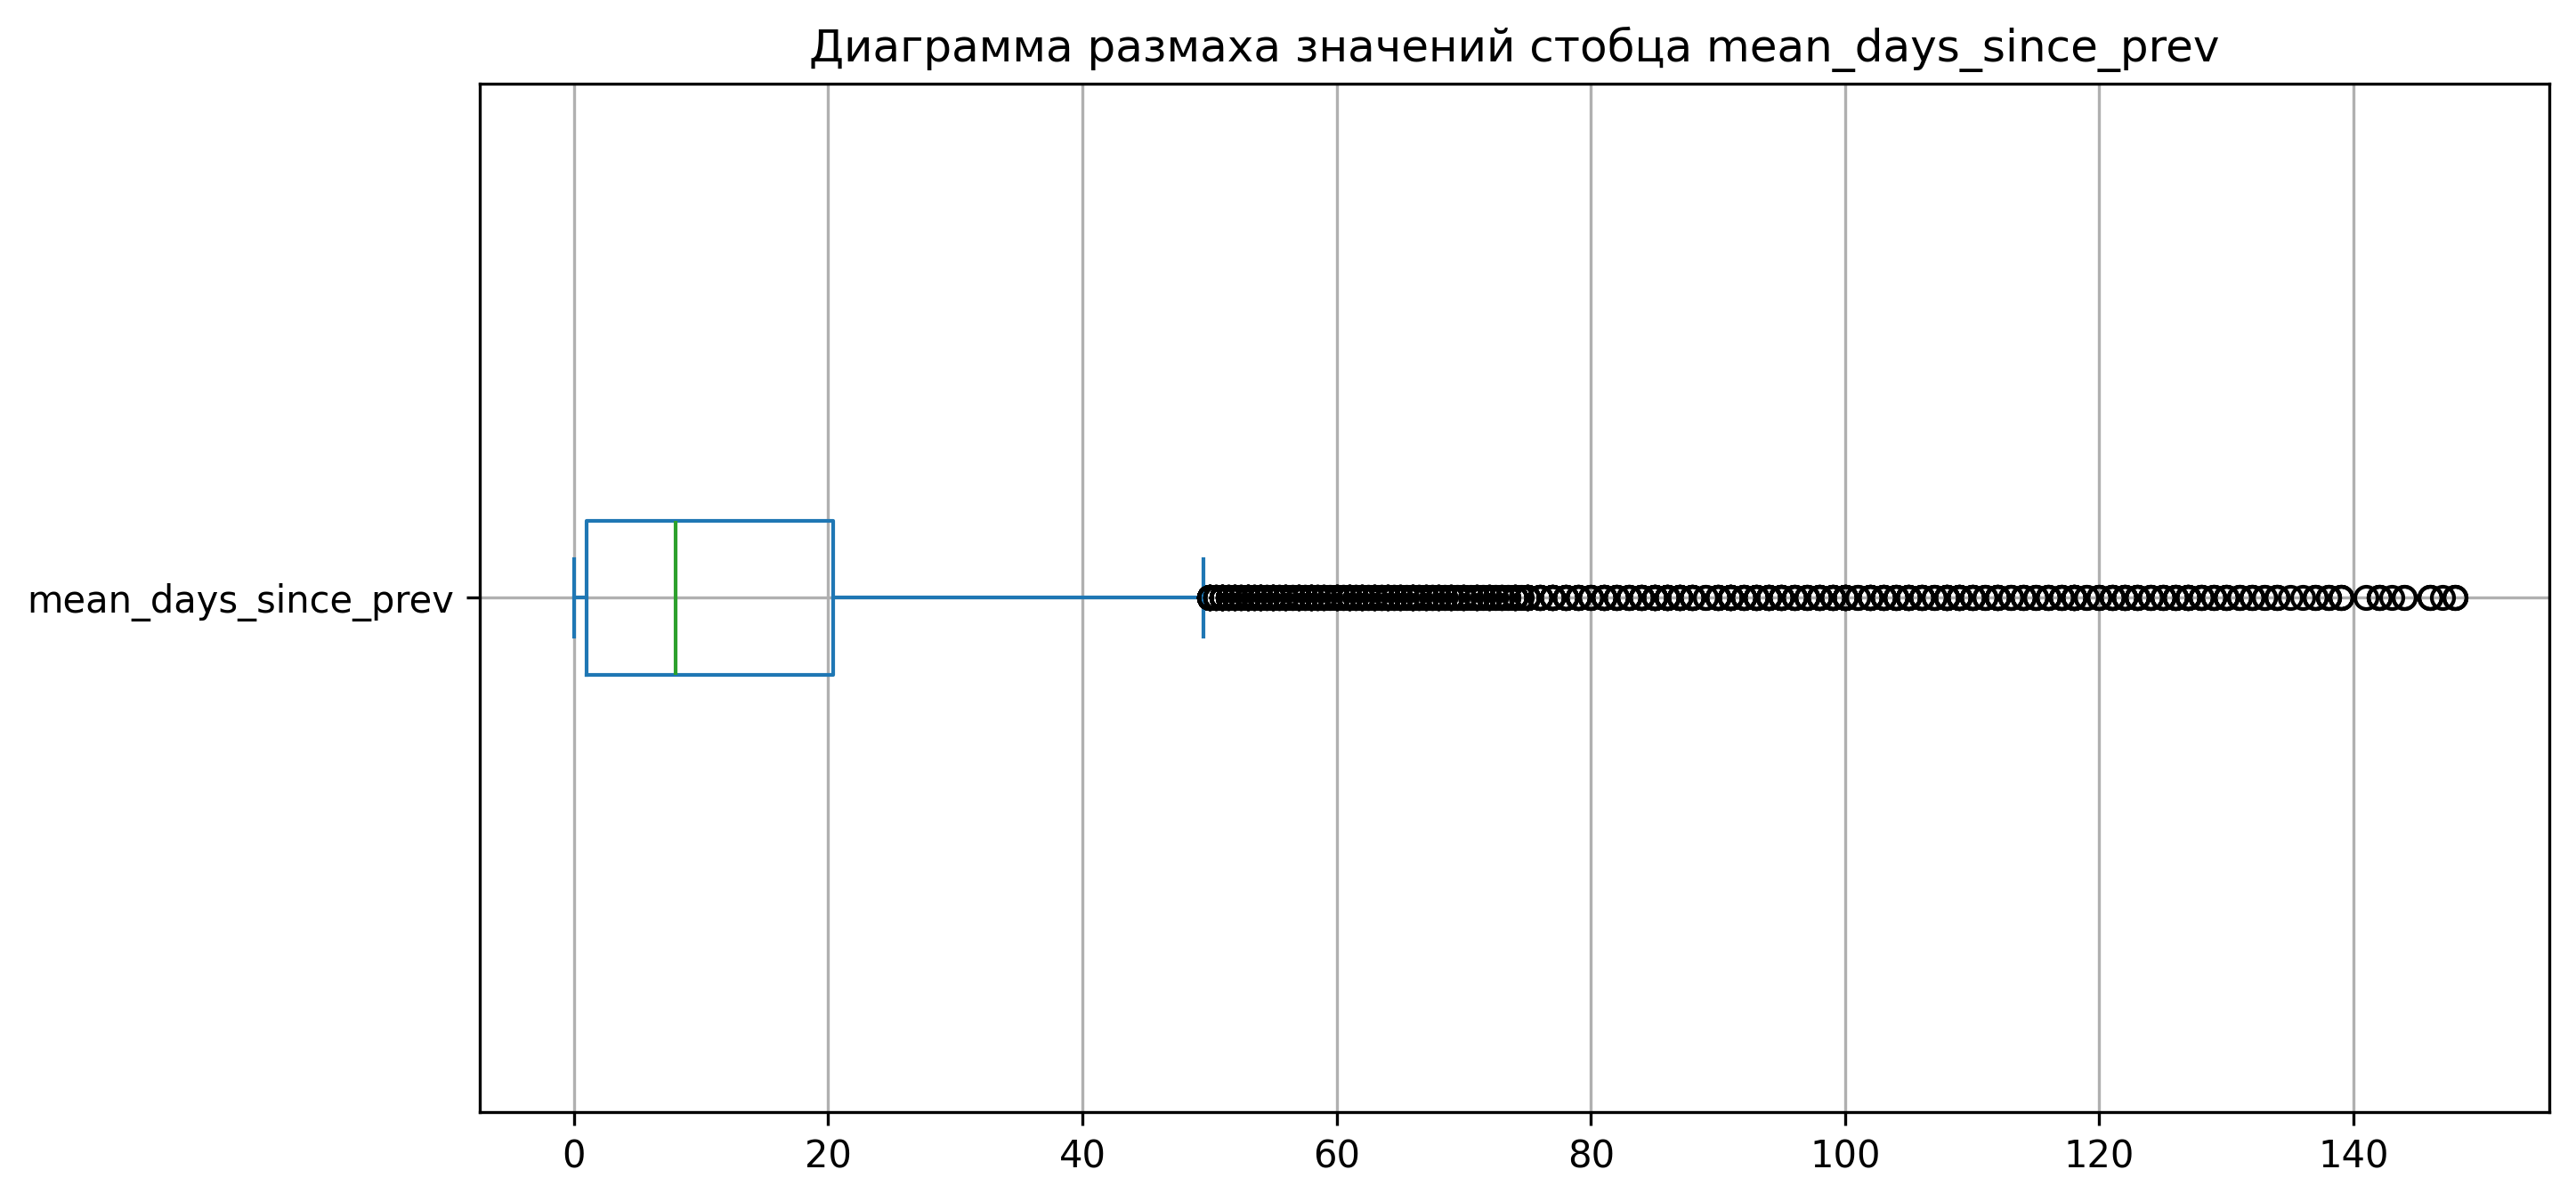

In [ ]:
for column in number_columns:
    plt.figure(figsize = (10, 5), dpi = 300)
    user_profile[column].plot(kind = 'hist', bins = 75, grid = True, 
                    title = f'Гистограмма распределения значений стобца {column}')
    plt.ylabel('Частота')
    
    plt.figure(figsize = (10, 5), dpi = 300)
    user_profile[column].plot(kind = 'box', vert = False, grid = True, 
                    title = f'Диаграмма размаха значений стобца {column}')

In [ ]:
prev_size = user_profile.shape[0]
prev_size

21832

In [ ]:
user_profile = user_profile[(user_profile['total_orders'] >= 0) & (user_profile['total_orders'] < user_profile['total_orders'].quantile(0.99))]
user_profile = user_profile[(user_profile['mean_tickets_count'] >= 0) & (user_profile['mean_tickets_count'] < user_profile['mean_tickets_count'].quantile(0.99))]
curr_size = user_profile.shape[0]
curr_size

20951

In [ ]:
print(f'Отфильтровано {round(100.0*(prev_size-curr_size)/prev_size,2)} процентов данных')

Отфильтровано 4.04 процентов данных


In [ ]:
print(f'Общее число пользователей в выборке = {user_profile.shape[0]}')
print(f'Средняя выручка с одного заказа = {round(user_profile["mean_revenue"].mean(),2)}')
print(f'Доля пользователей, совершивших 2 и более заказа = {round(user_profile["is_two"].mean(),2)}')
print(f'Доля пользователей, совершивших 5 и более заказов = {round(user_profile["is_five"].mean(),2)}')

Общее число пользователей в выборке = 20951
Средняя выручка с одного заказа = 535.03
Доля пользователей, совершивших 2 и более заказа = 0.63
Доля пользователей, совершивших 5 и более заказов = 0.29


Данные были отфильтрованы по полям total_orders и mean_tickets_count по 99 перцентилю, поскольку эти показатели содержит явные выбросы.

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [ ]:
#функция для визуализации результатов

def visualise_data(plot_data, title, xlabel = '', figsize = (10, 5), kind = 'bar'):
    fig = plt.figure(figsize = figsize, dpi = 300) 

    ax = plt.gca()
    if kind == 'bar':
        rot = 45
    else:
        rot = 0
    plot_data.plot(kind = kind, ax=ax, rot = rot)

    plt.title(title)
    plt.xlabel(xlabel)
    if kind == 'bar':
        plt.axhline(plot_data.mean(), linewidth=1.5, color='black', linestyle='--', label='Среднее значение выборки')
        plt.legend(loc='lower left')
    plt.show()
    plt.close(fig)

In [ ]:
segment_event_type = user_profile.groupby('event_type_first')
segment_device = user_profile.groupby('device_first')
segment_region = user_profile.groupby('region_first')
segment_service = user_profile.groupby('service_first')

In [ ]:
segments = [segment_event_type, segment_device, segment_region, segment_service]
for segment in segments:
    print('Анализ сегмента')
    segment_count = segment['user_id'].count().sort_values(ascending=False)
    print(pd.concat([segment_count, segment_count / user_profile.shape[0]], axis=1))

Анализ сегмента
                  user_id   user_id
event_type_first                   
концерты             9365  0.446995
другое               5170  0.246766
театр                4108  0.196077
стендап              1072  0.051167
спорт                 740  0.035321
выставки              406  0.019379
ёлки                   90  0.004296
Анализ сегмента
              user_id   user_id
device_first                   
mobile          17370  0.829077
desktop          3581  0.170923
Анализ сегмента
                          user_id   user_id
region_first                               
каменевский регион           6877  0.328242
североярская область         3624  0.172975
широковская область          1173  0.055988
озернинский край              651  0.031073
малиновоярский округ          515  0.024581
...                           ...       ...
залесский край                  2  0.000095
тихогорская область             2  0.000095
верхозёрский край               1  0.000048
сосноводолинская

Пользователи распределены равномерно по билетному оператору, продавшему билеты на первый заказ. Явными «точками входа» являются мобильные устройства, с которых осуществлено 82% первых заказов, а также почти половина первых заказов были сделаны на концерты.

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


Анализ пользователей, совершивших два и более заказа:


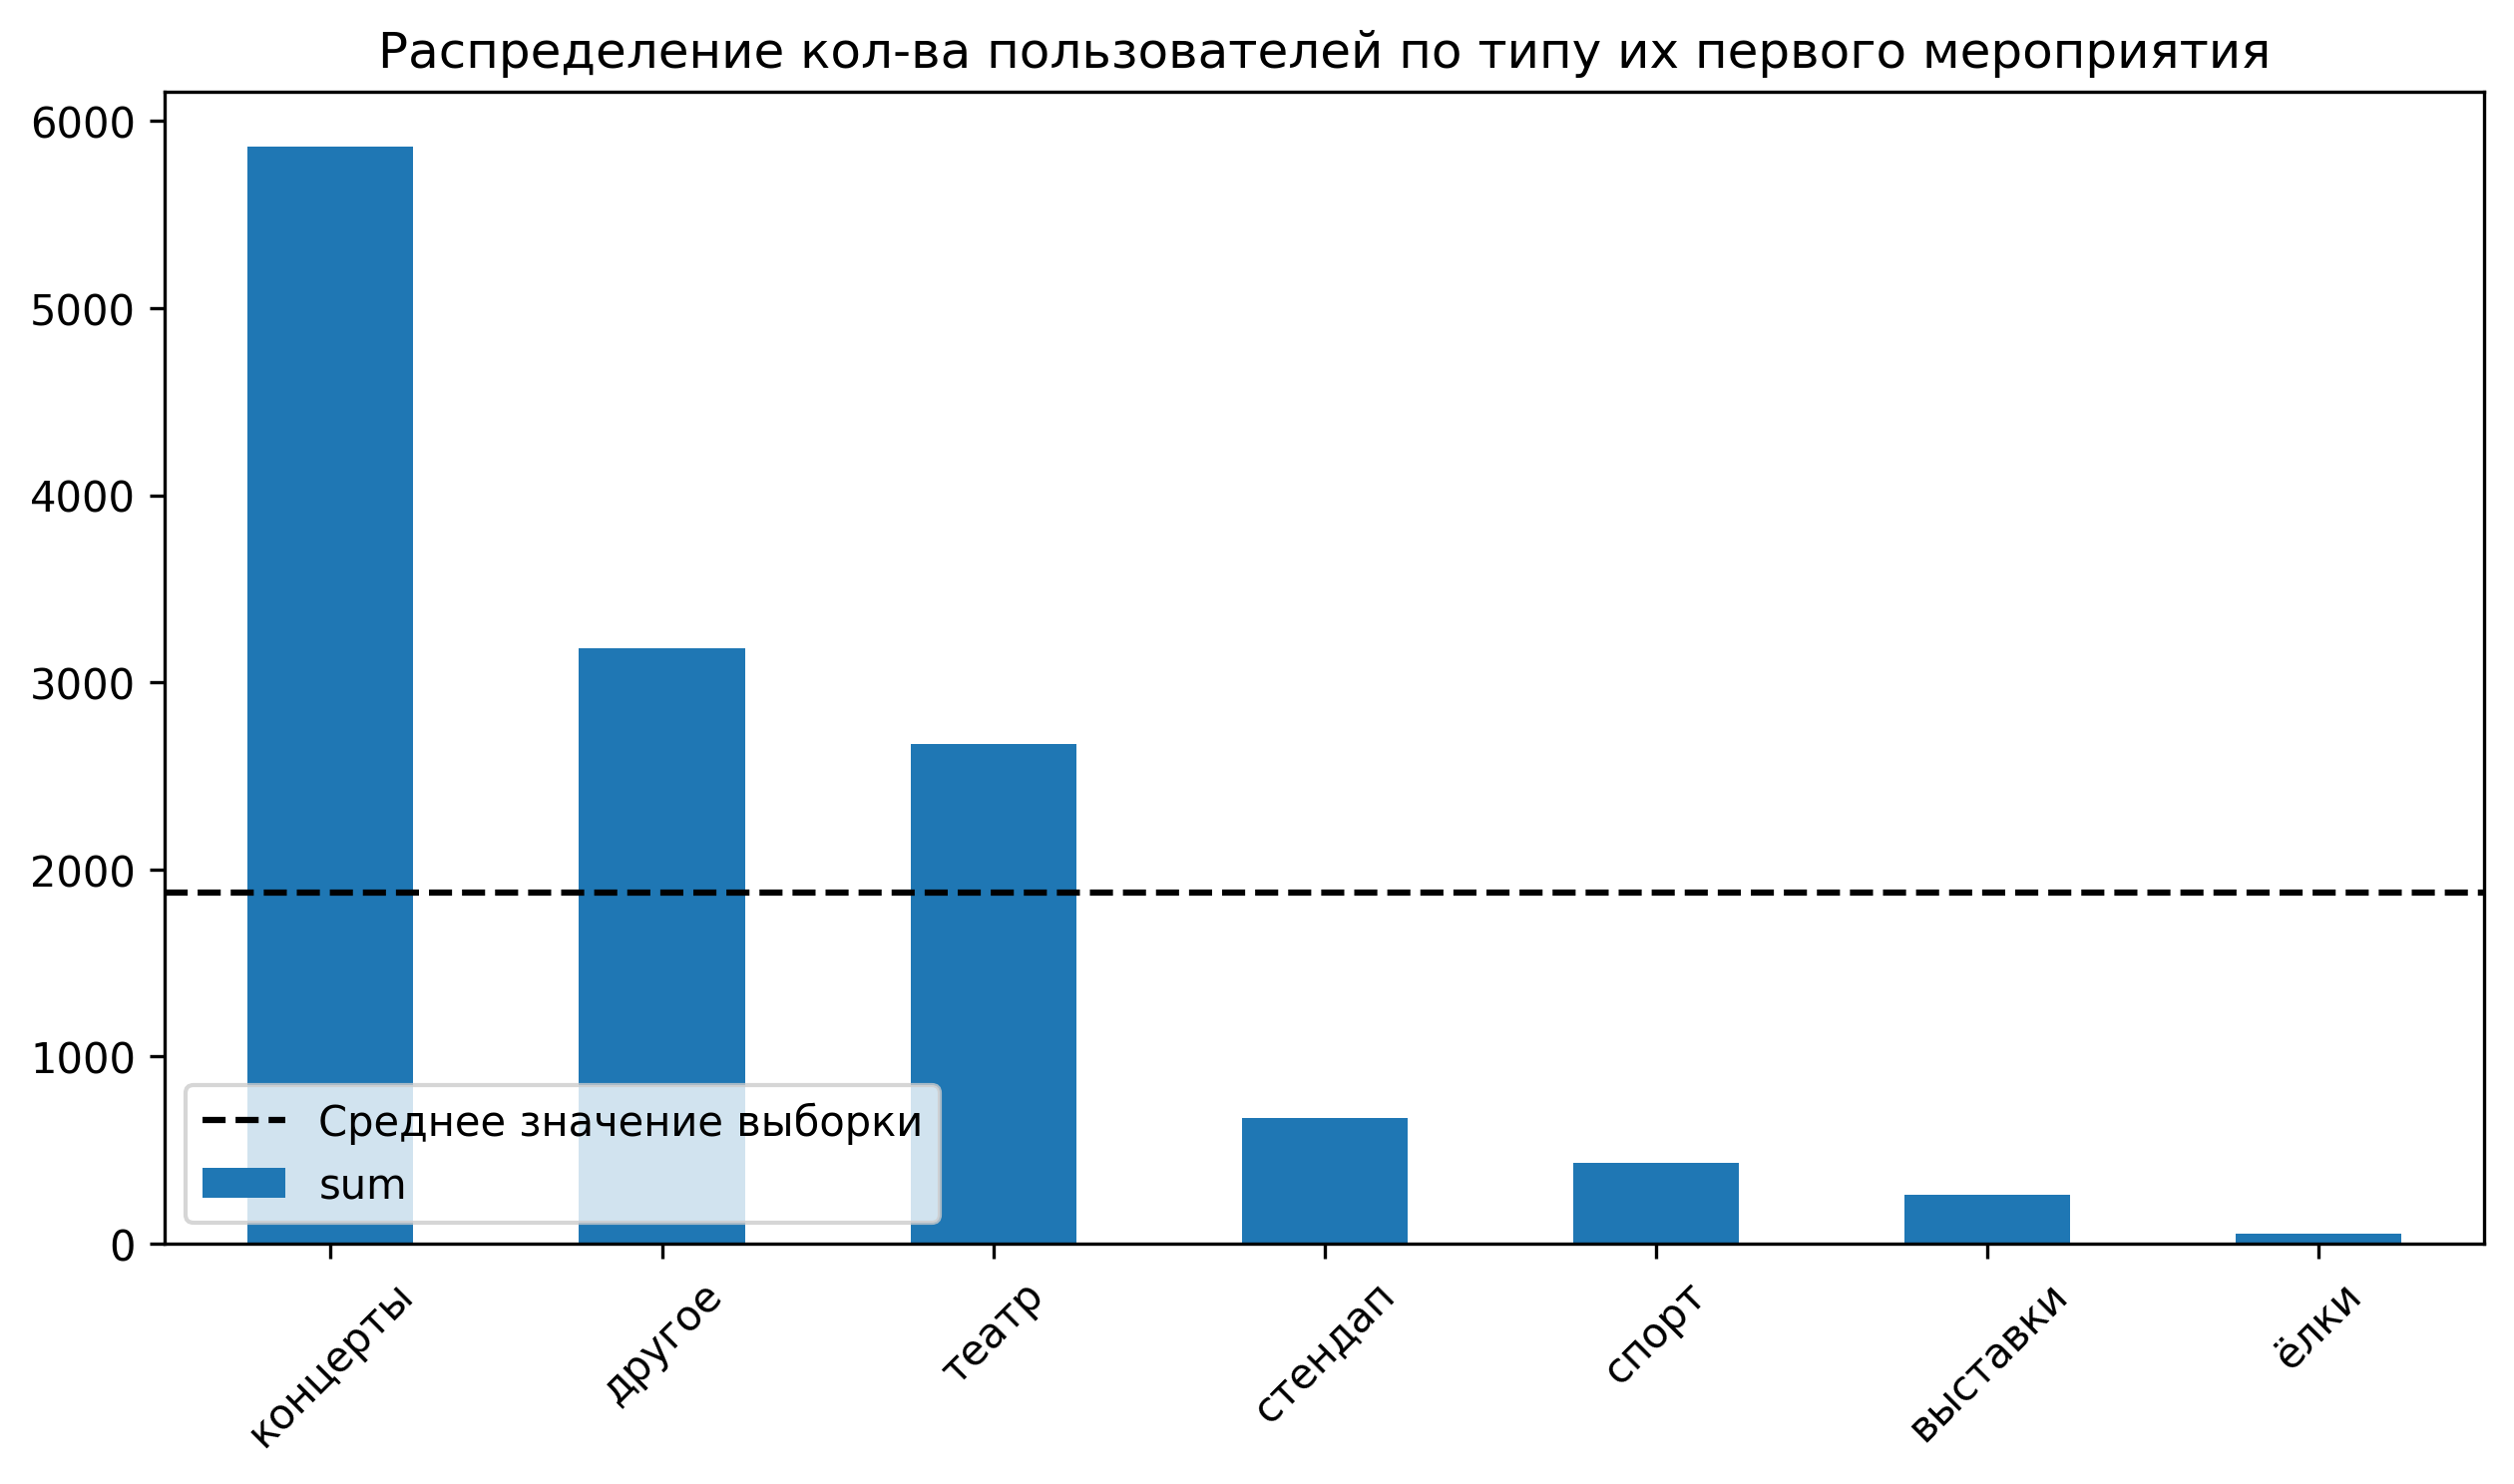

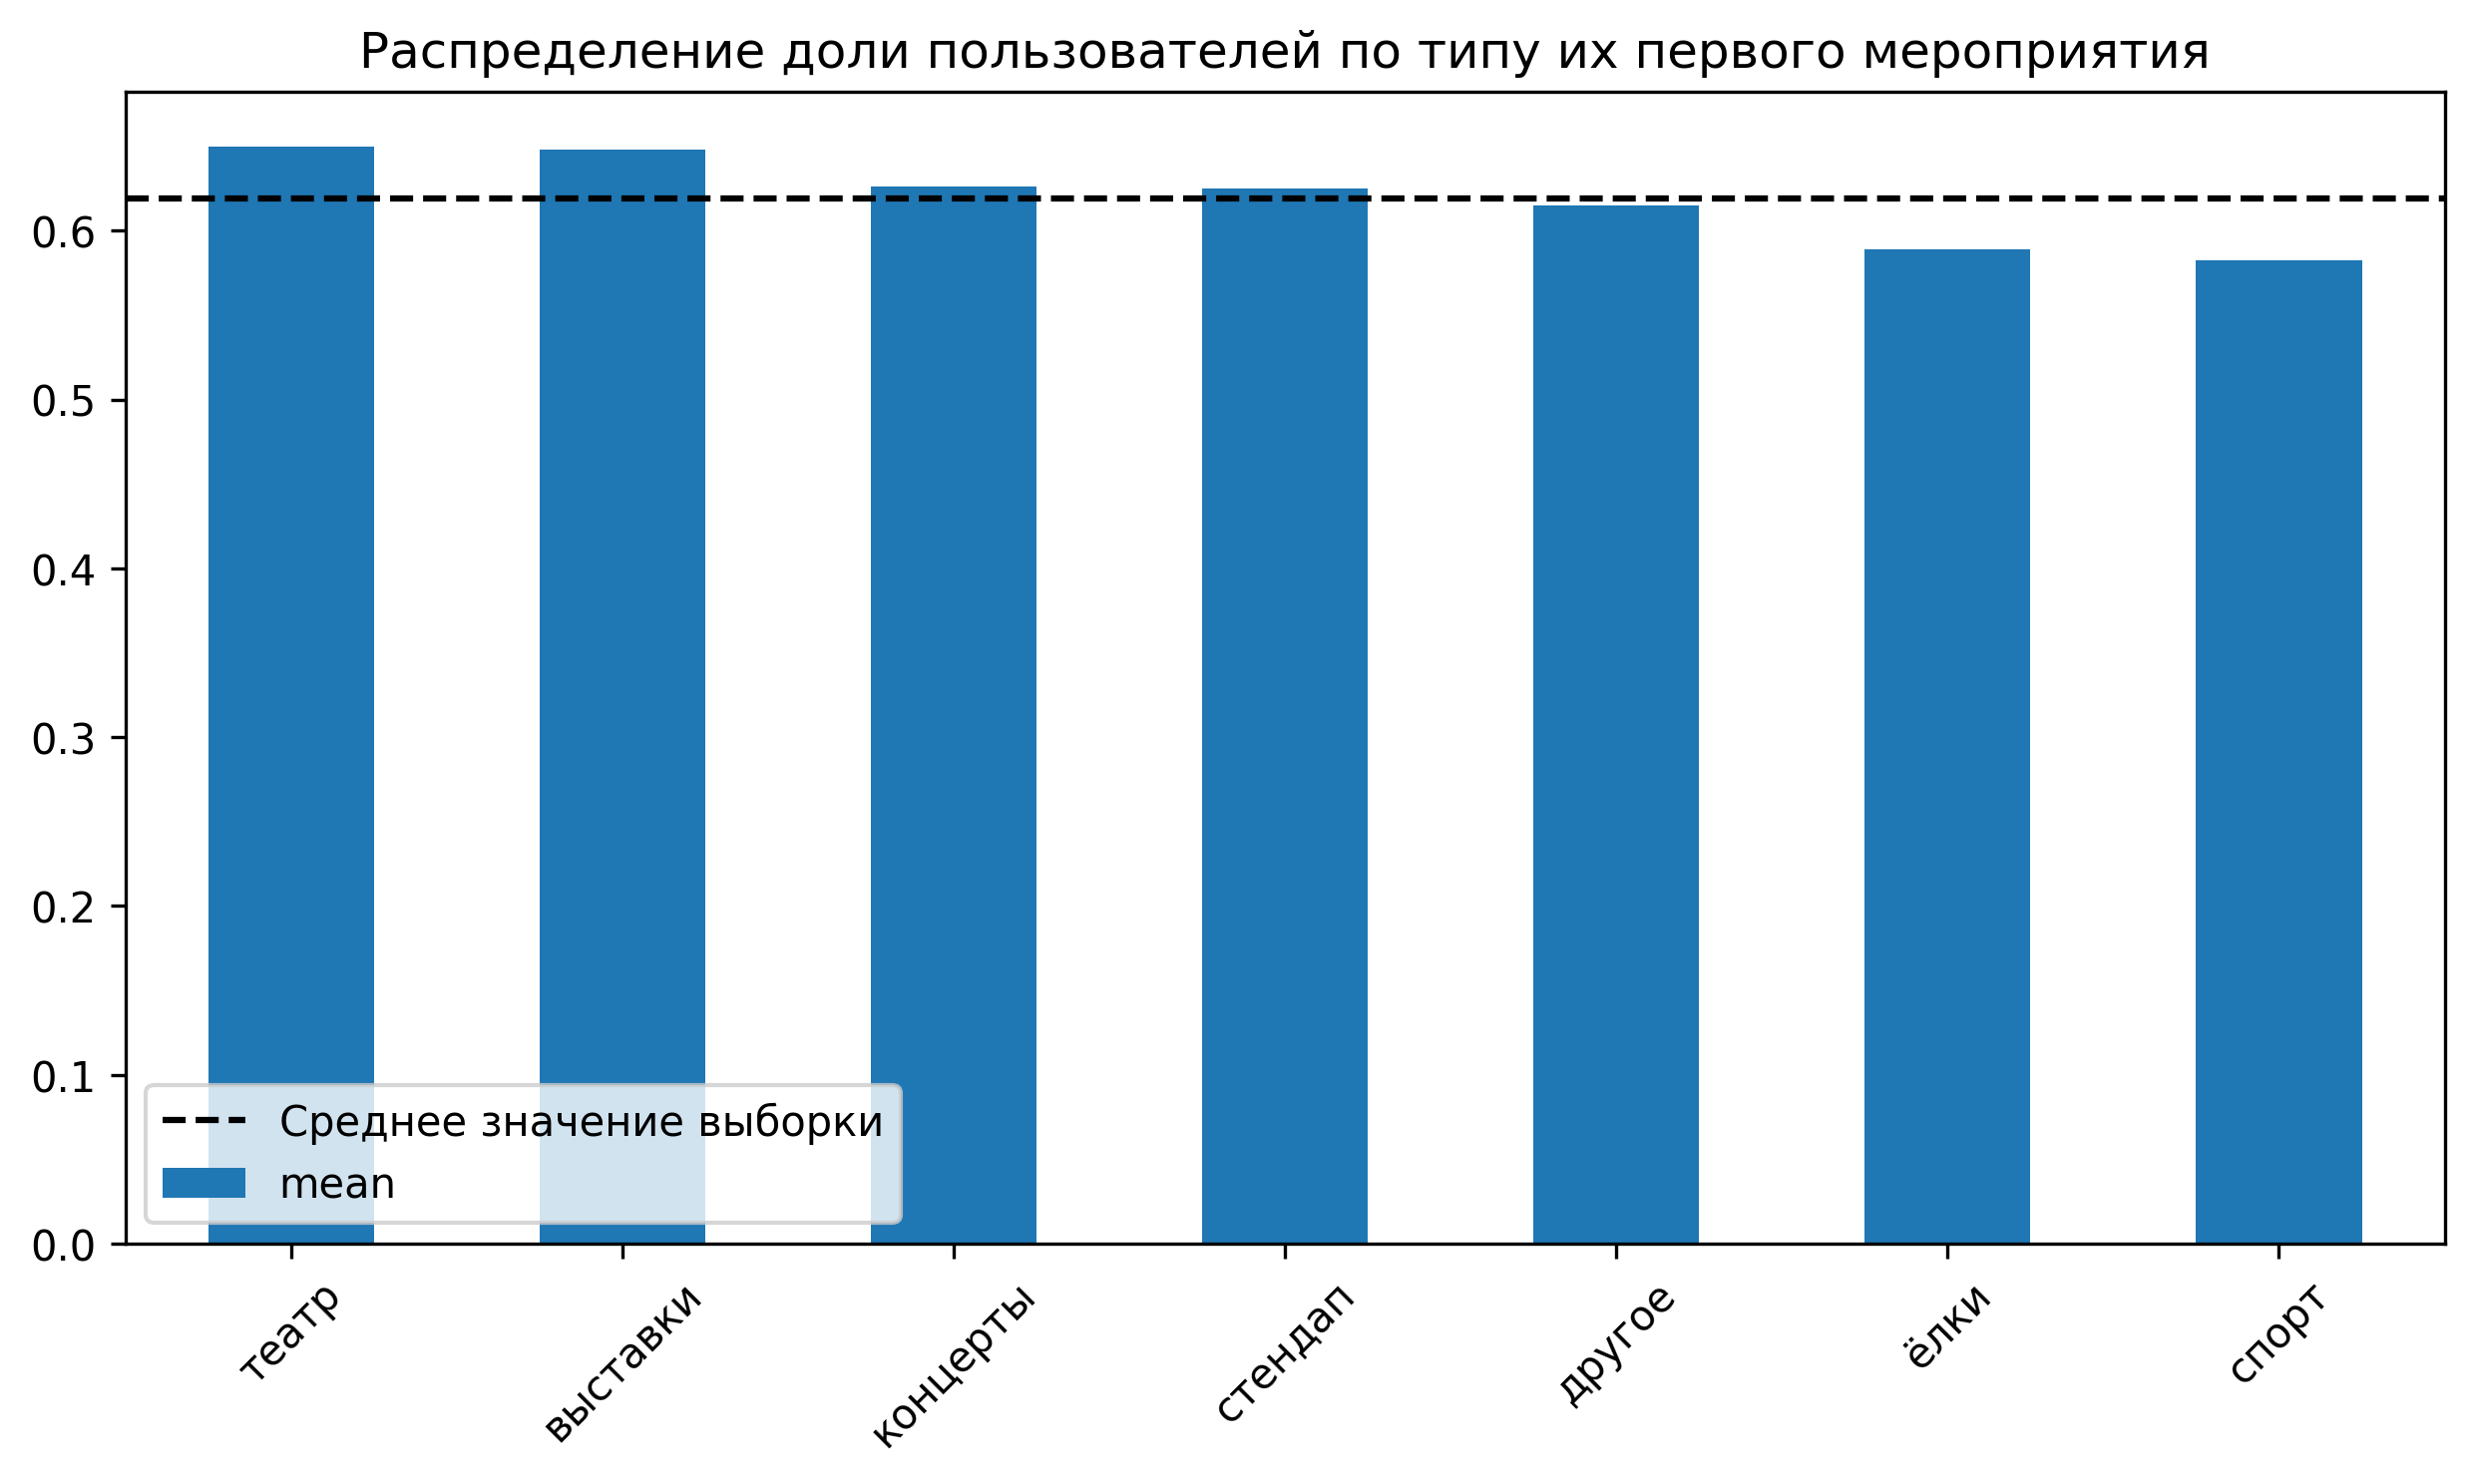

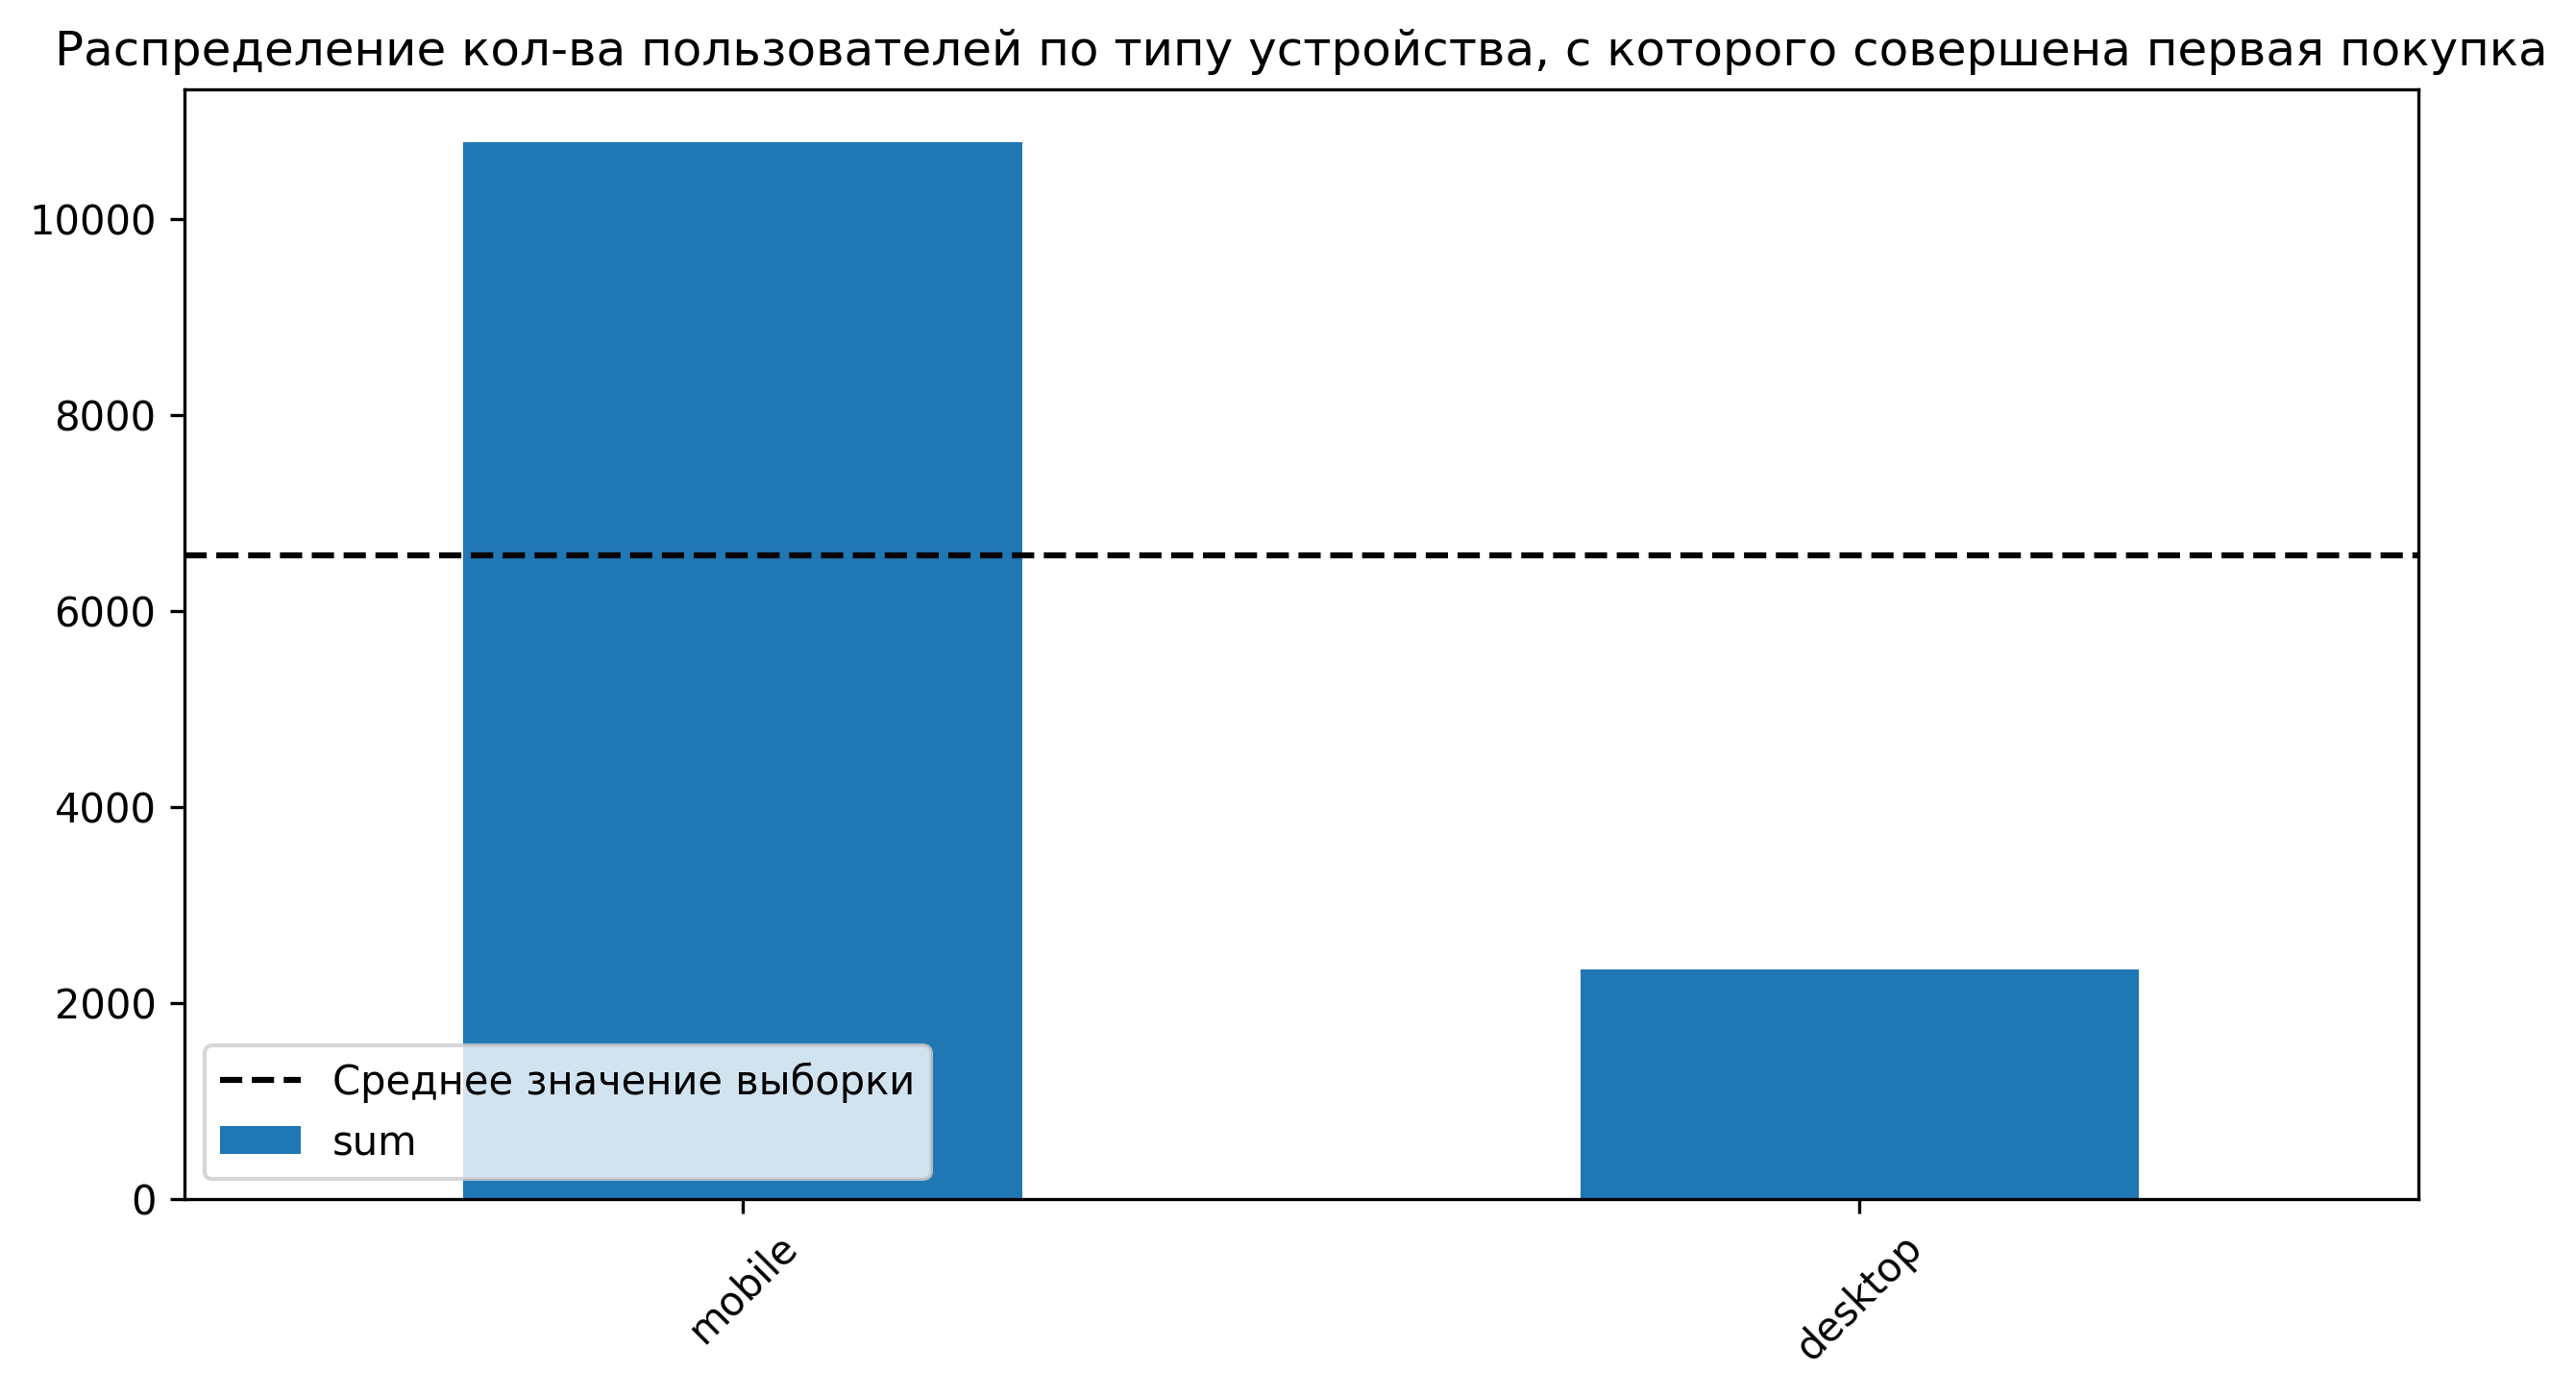

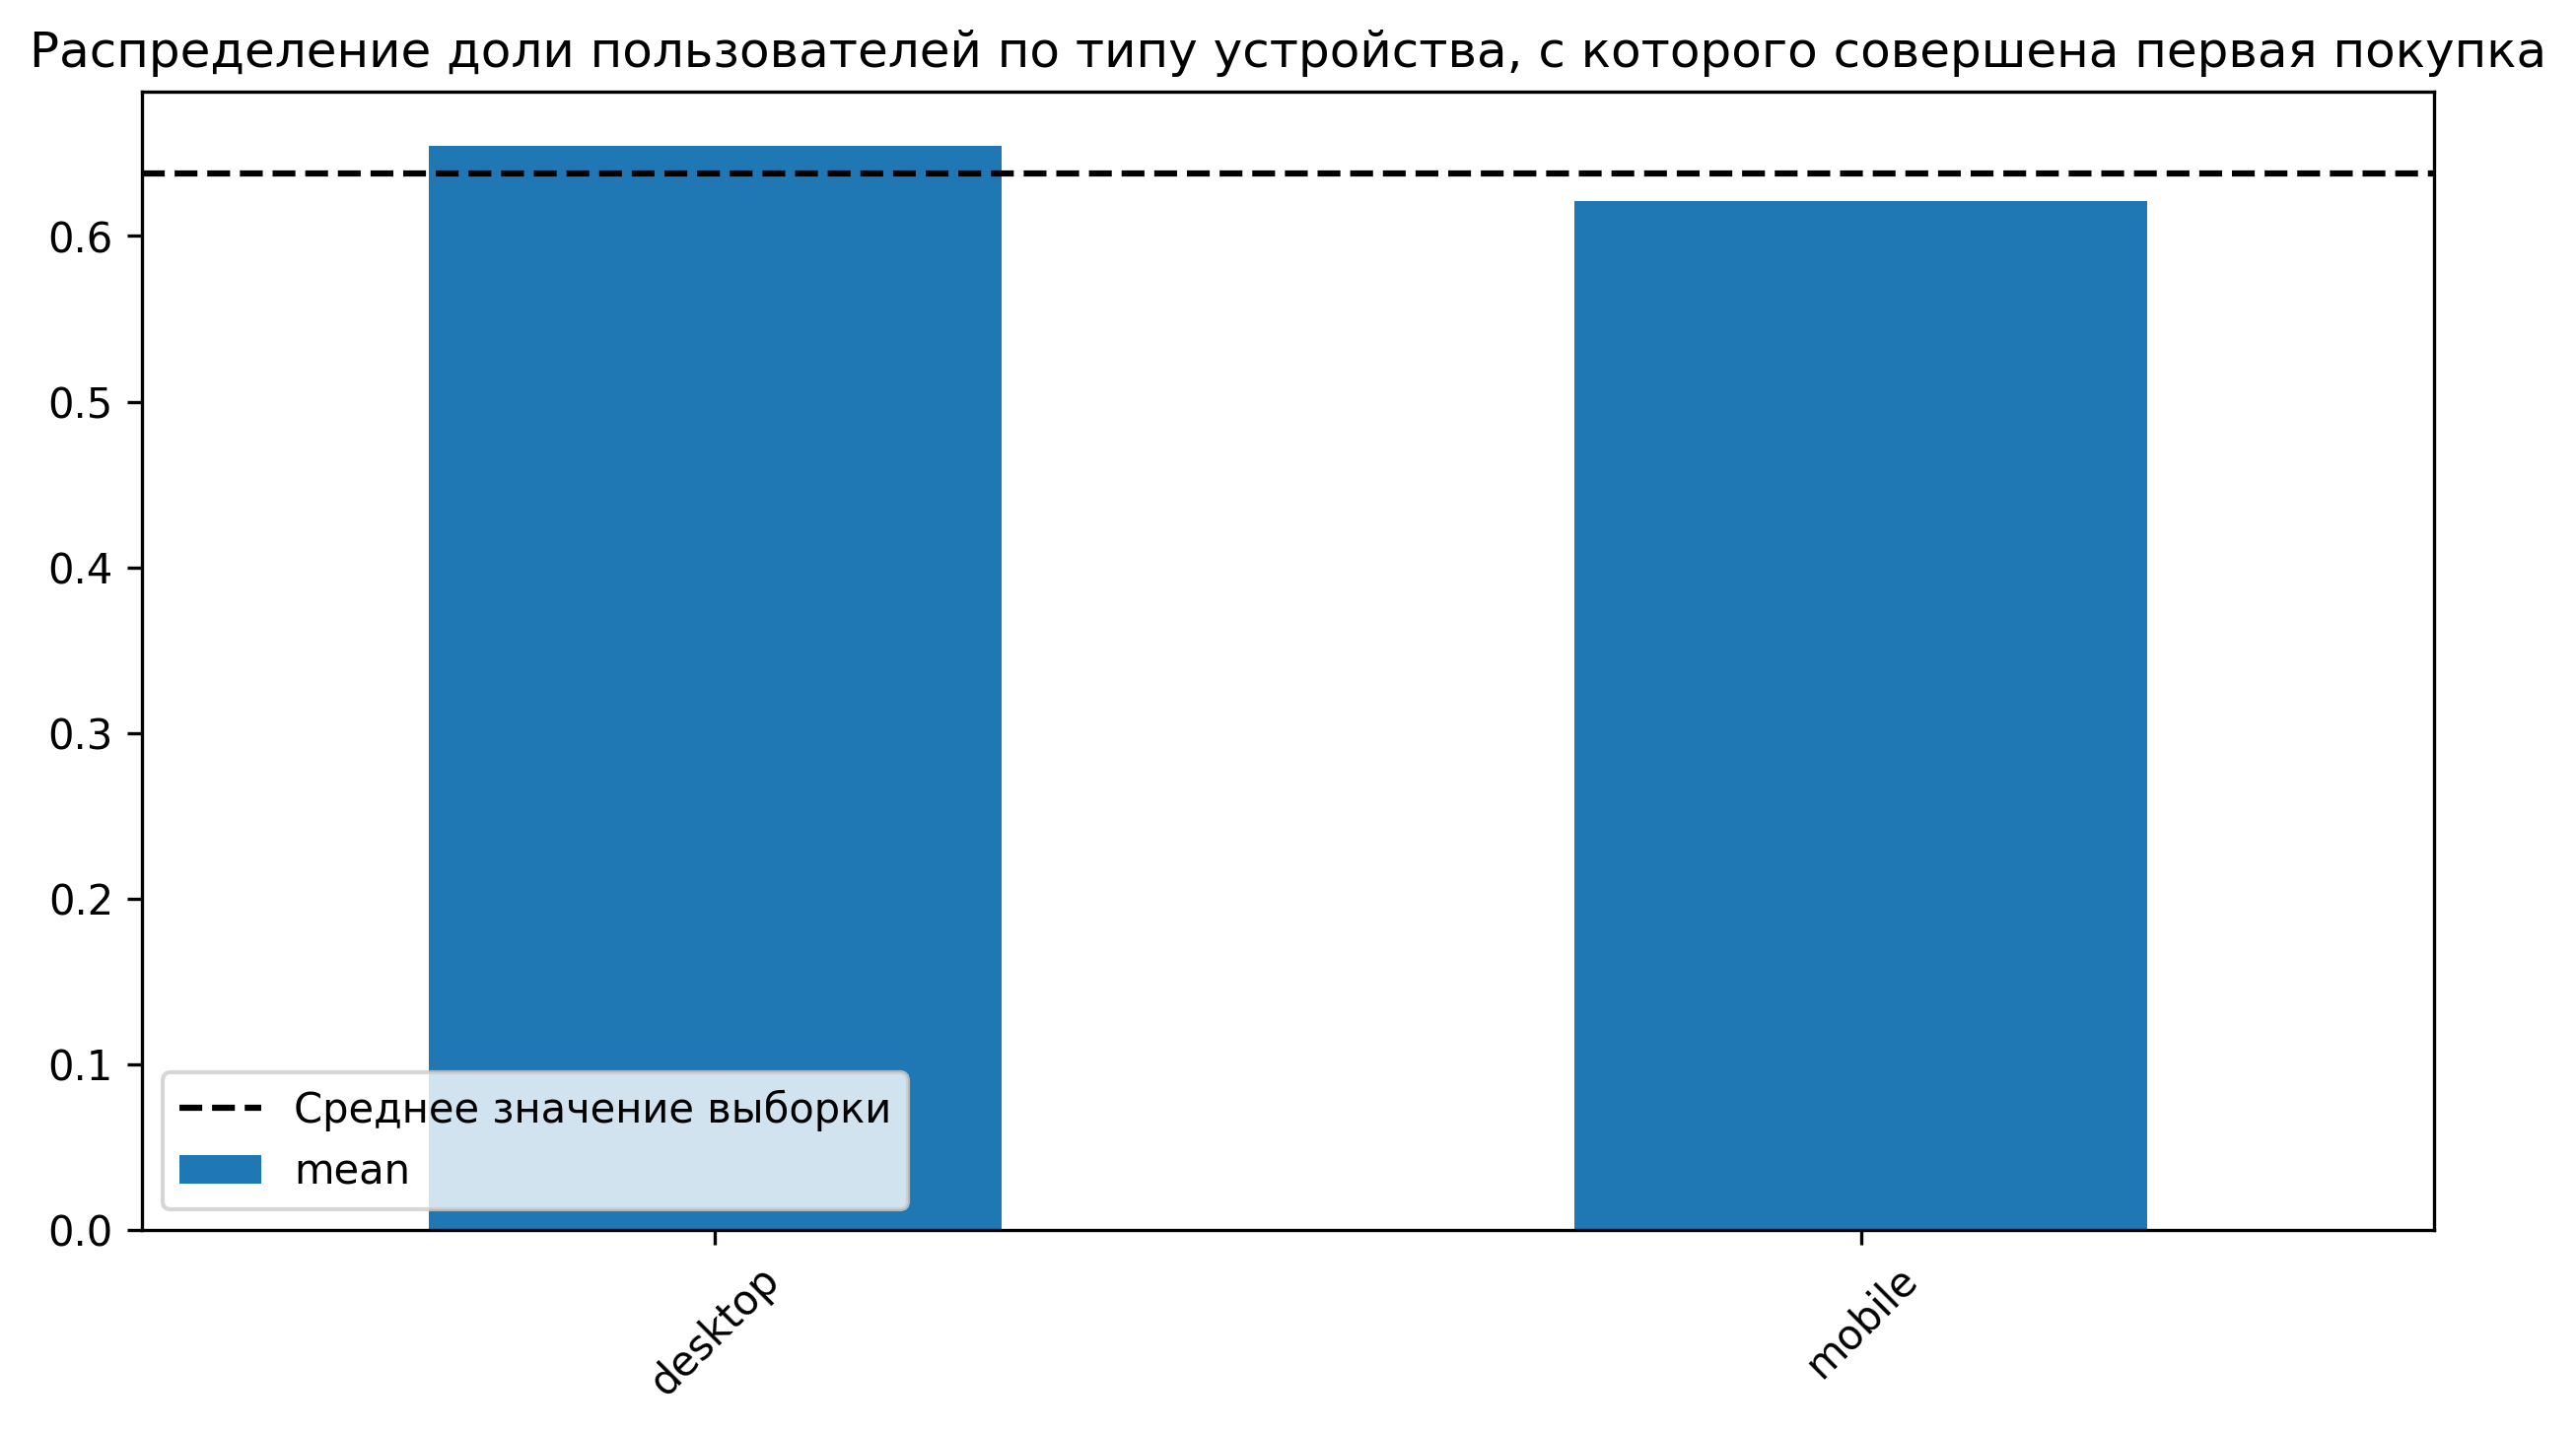

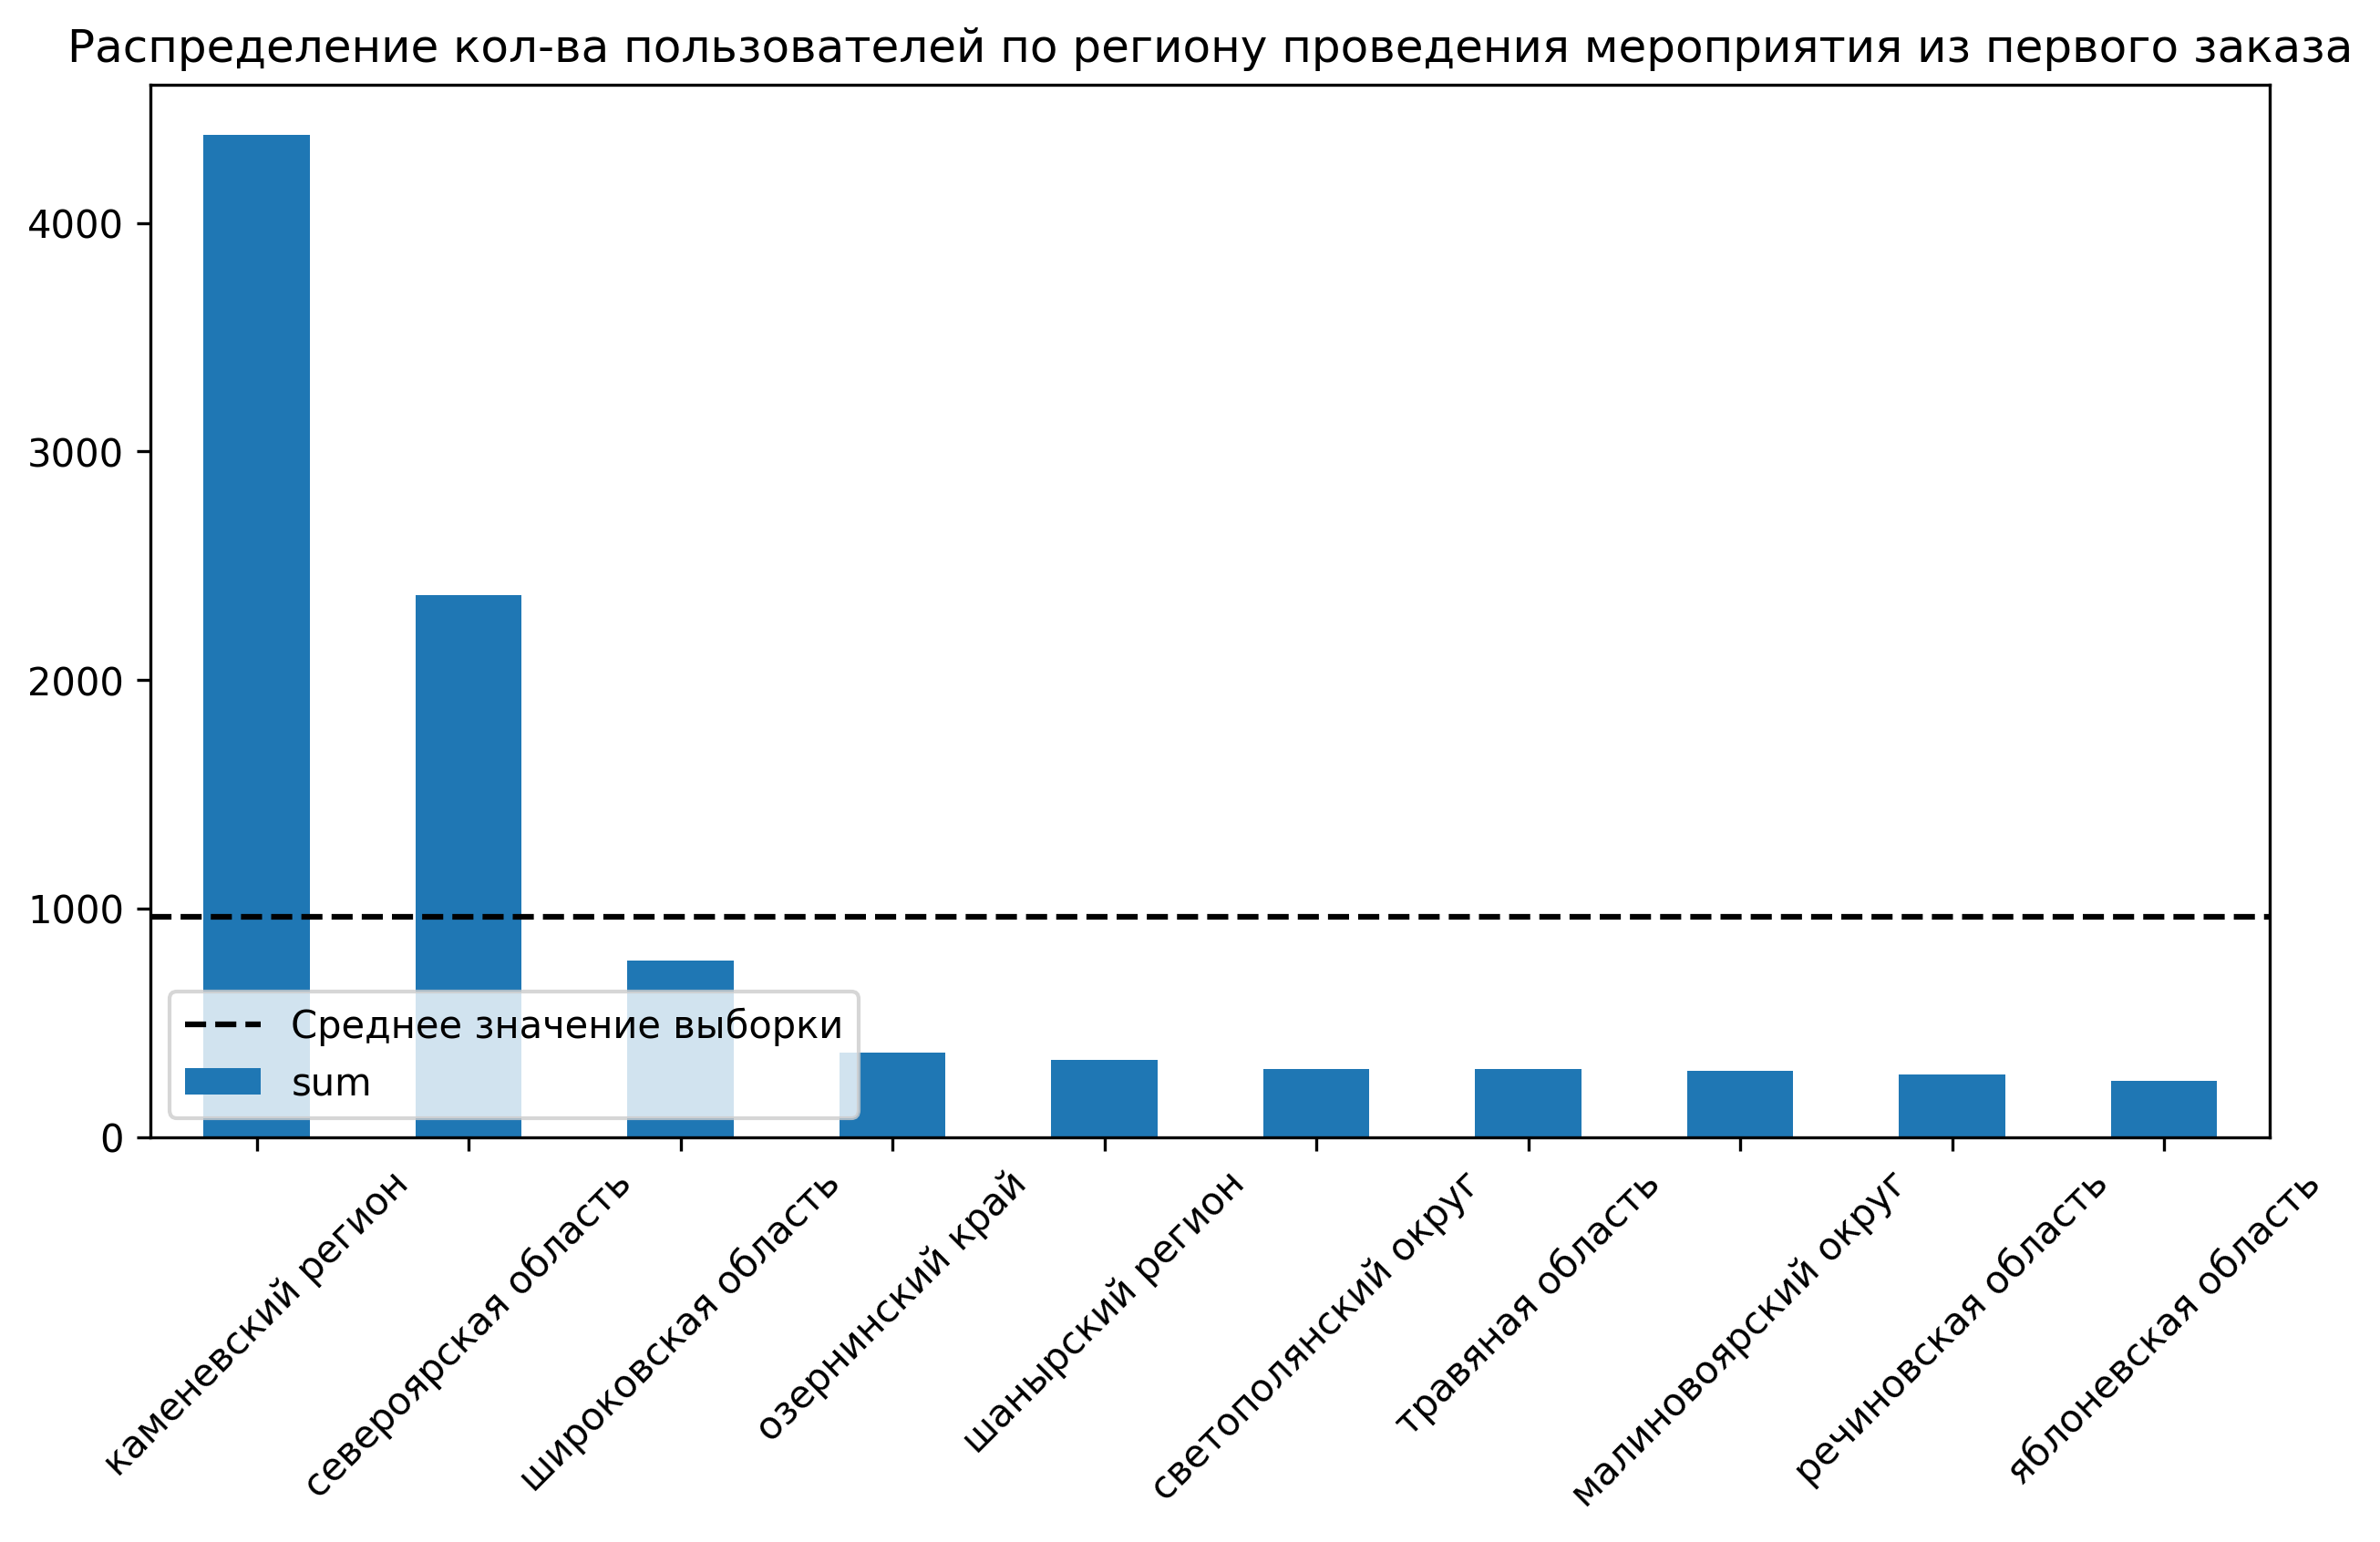

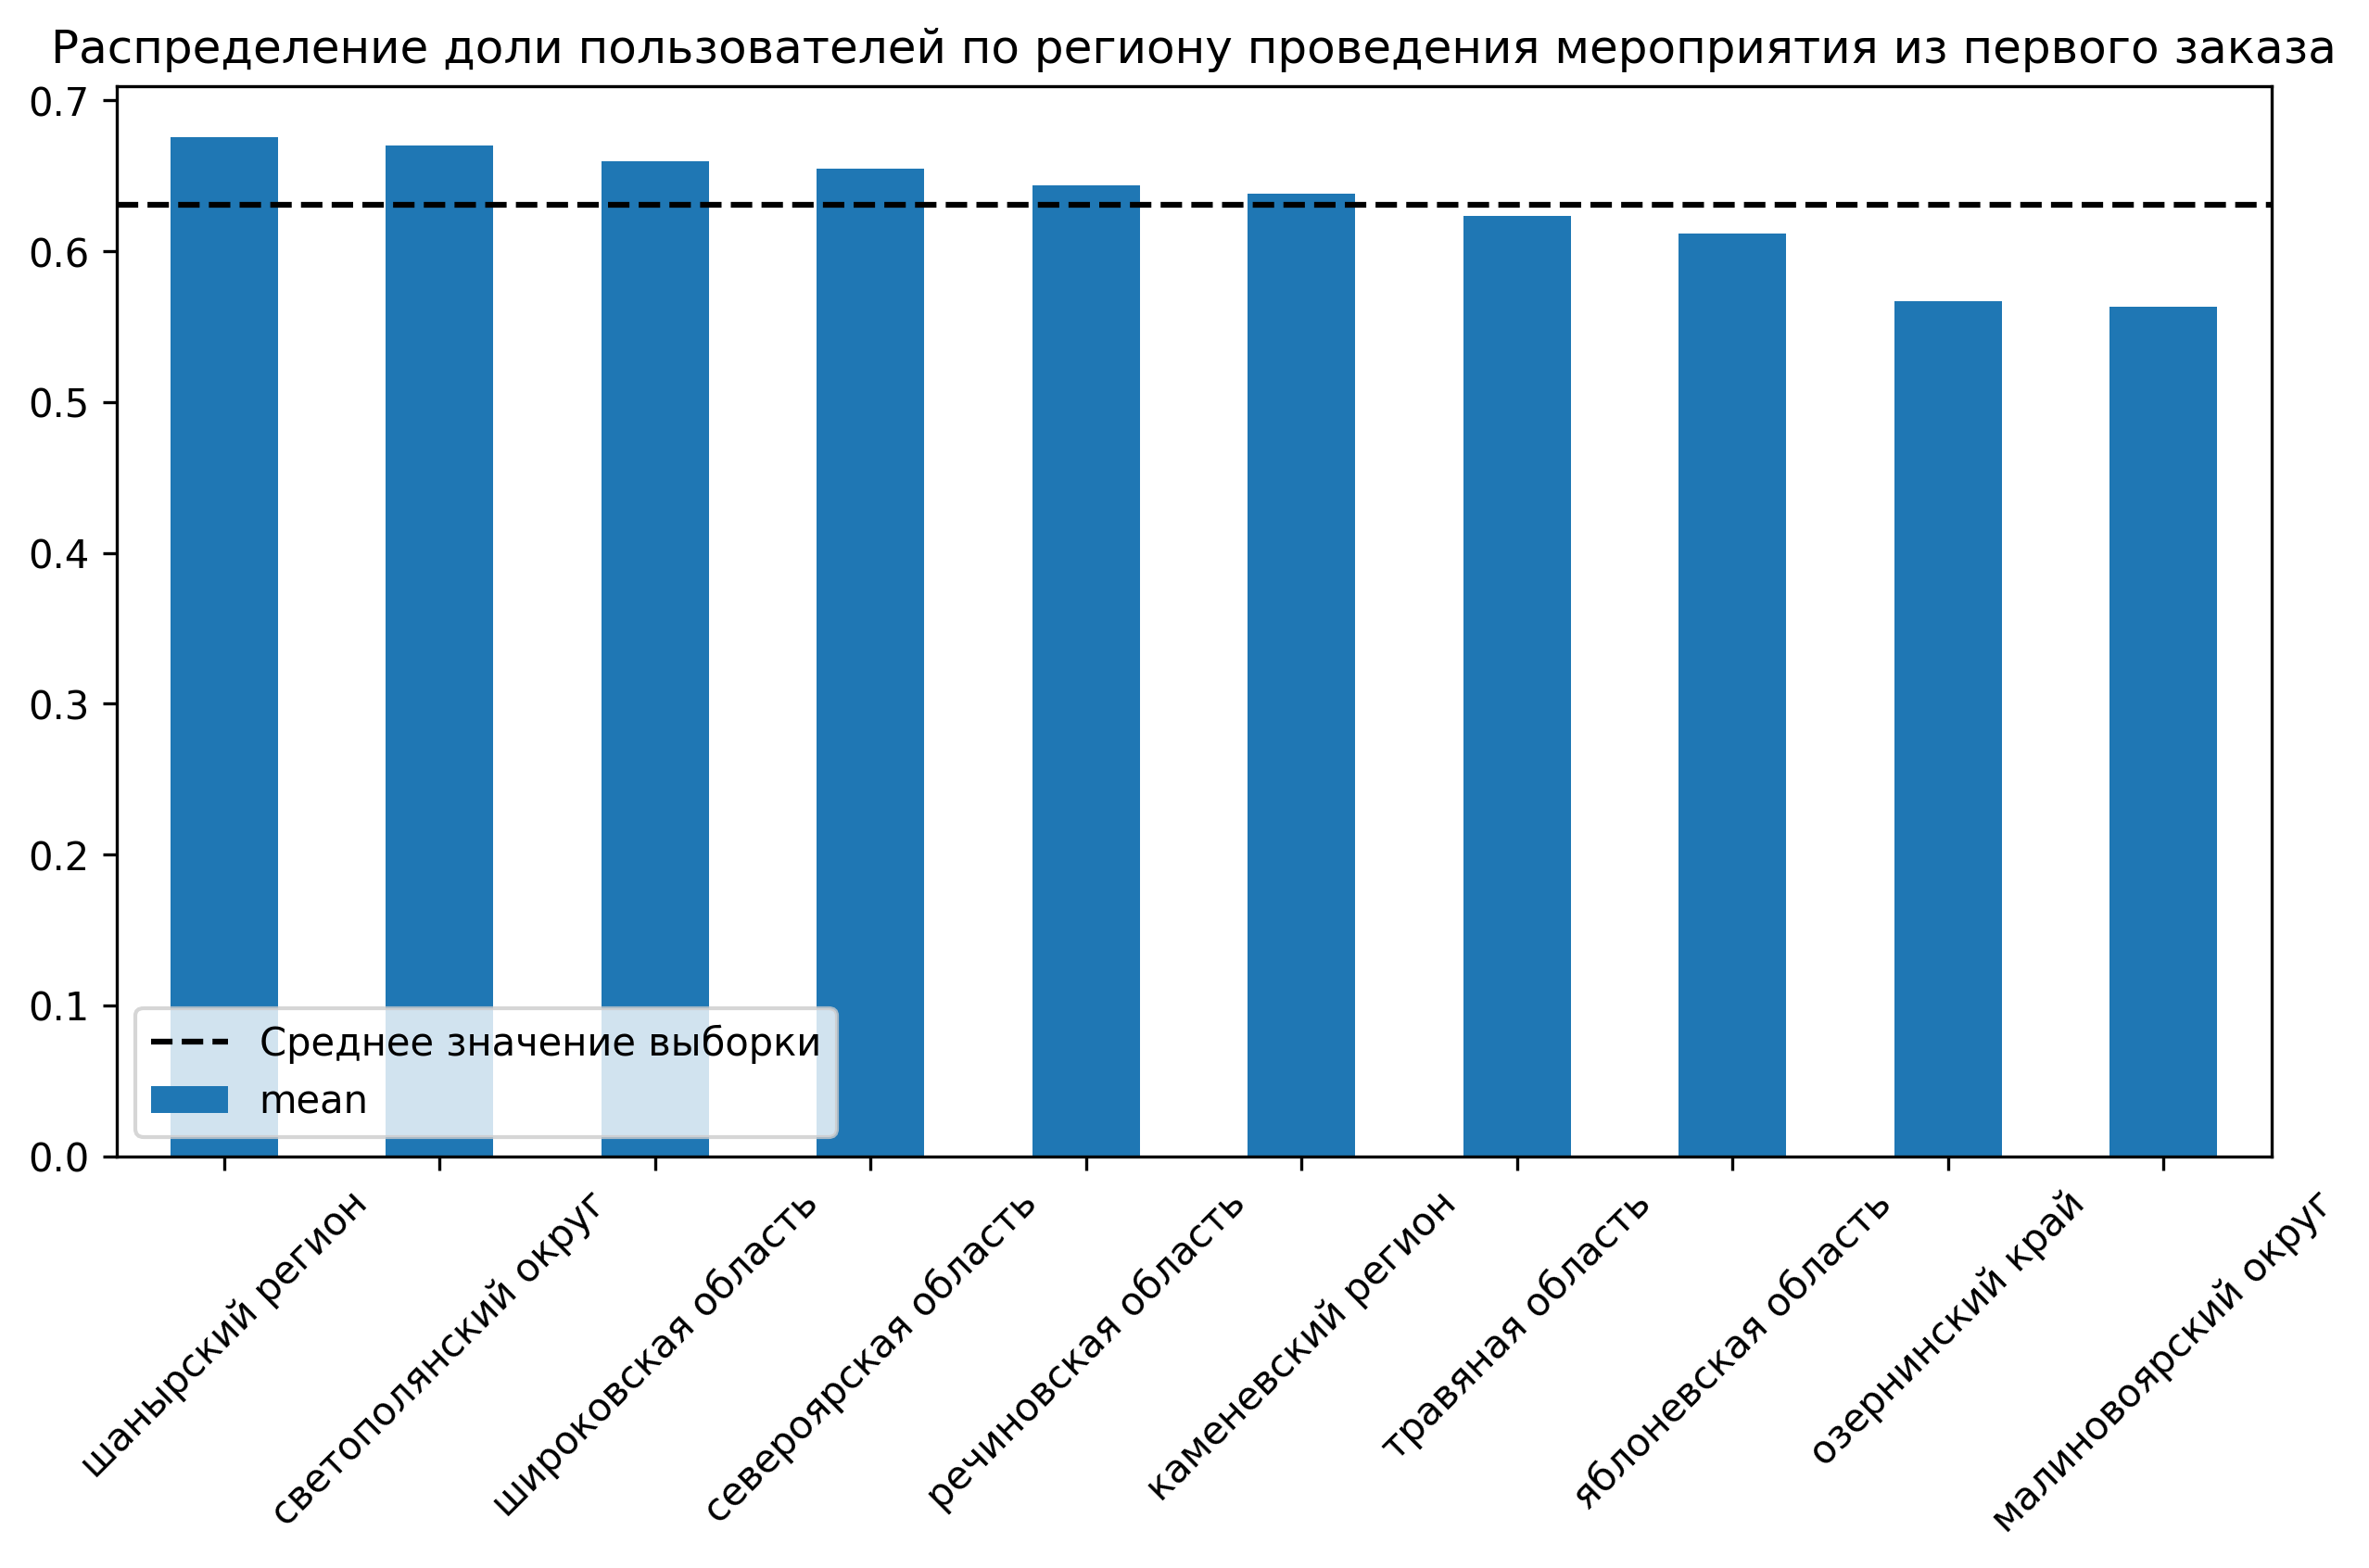

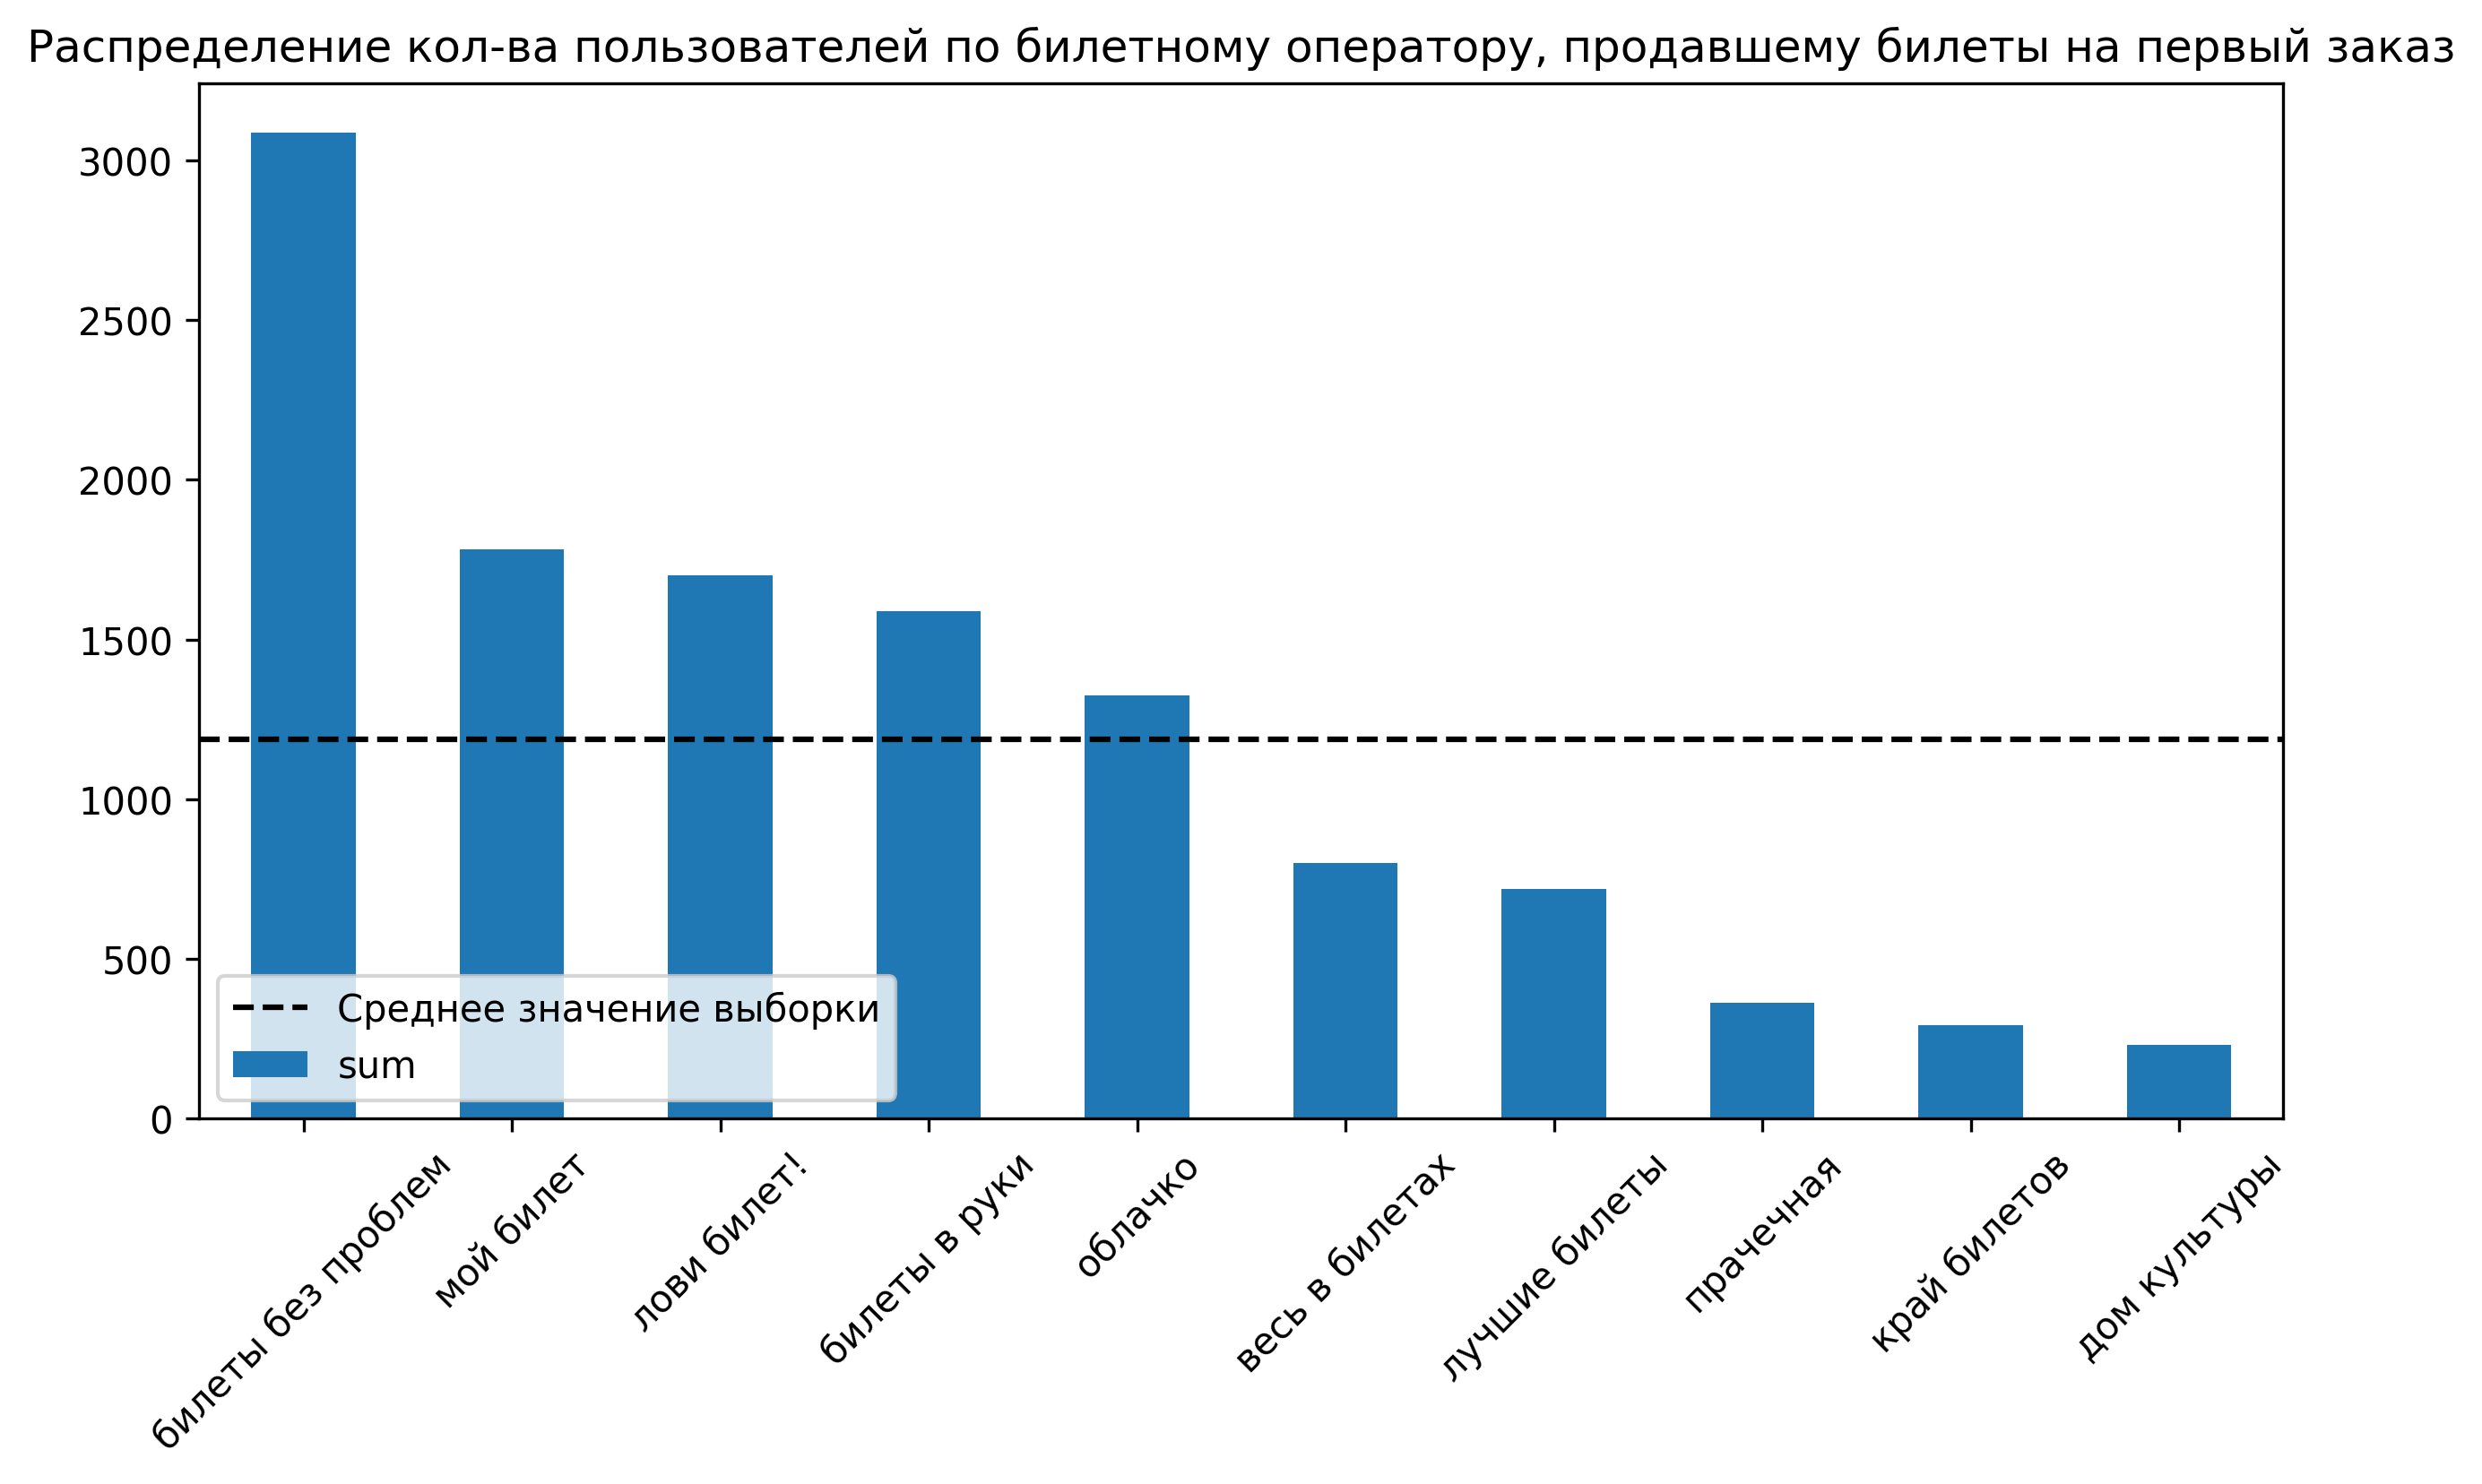

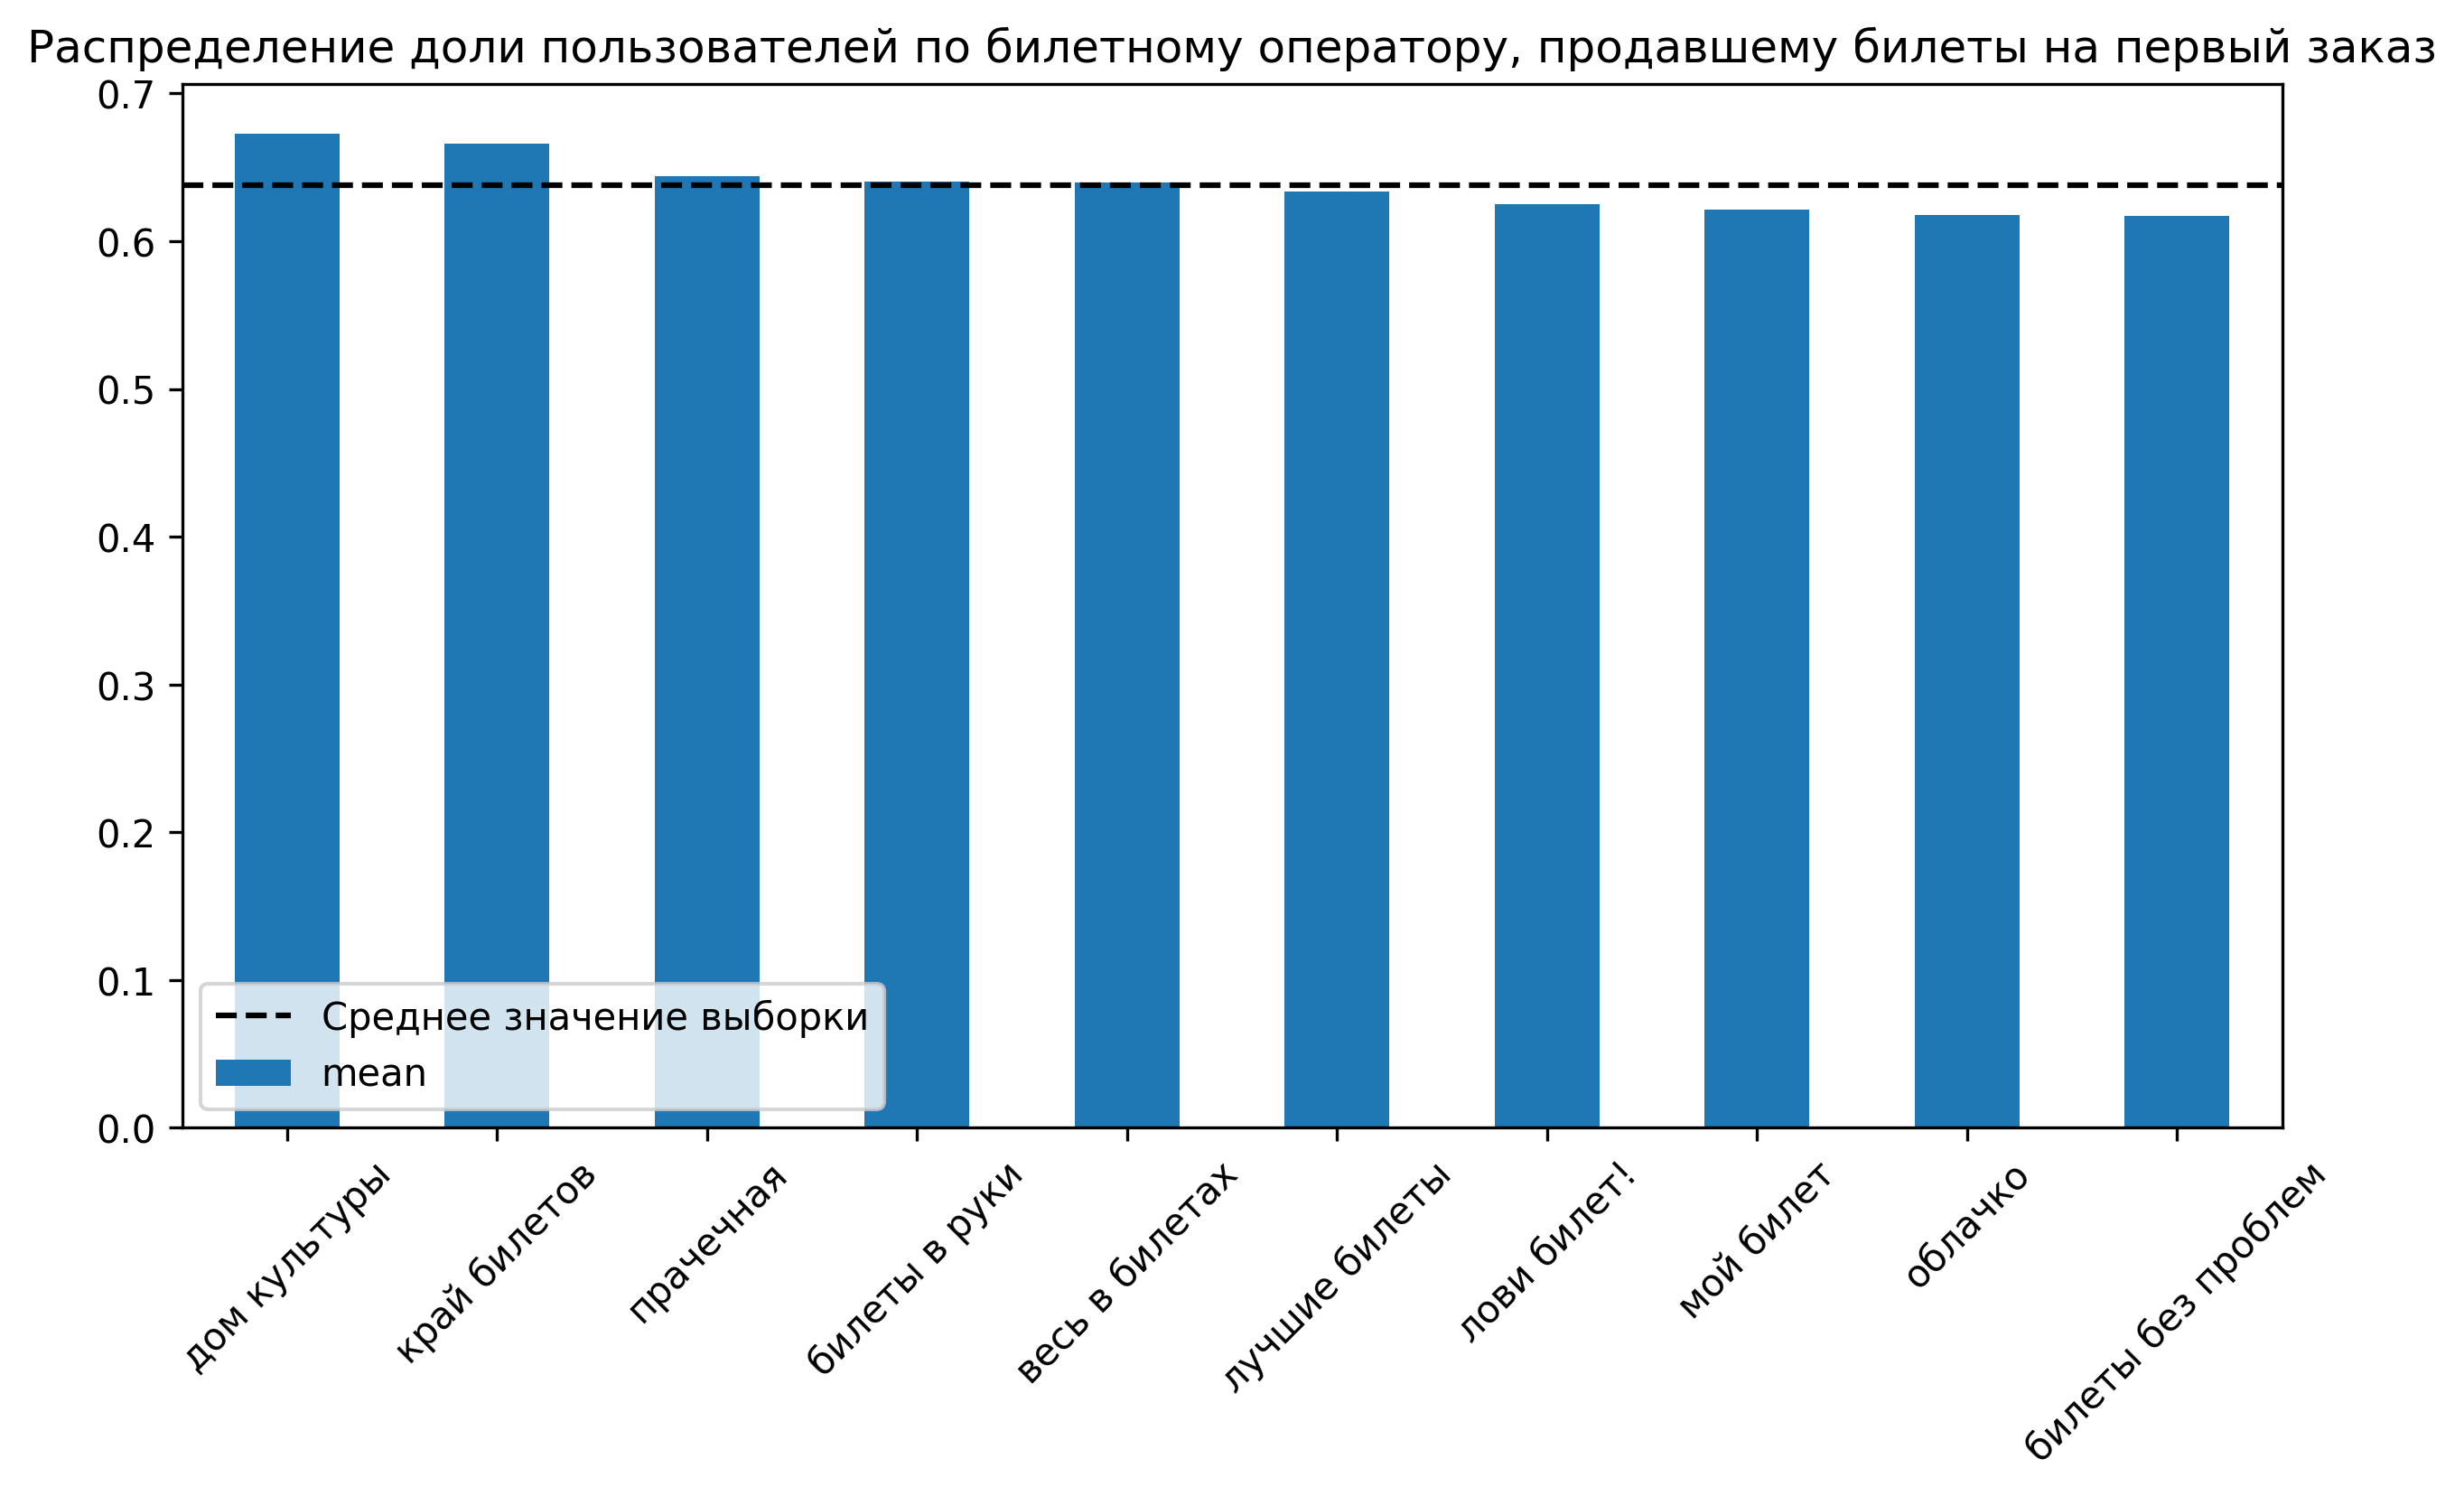

In [ ]:
names = ['по типу их первого мероприятия',
        'по типу устройства, с которого совершена первая покупка',
        'по региону проведения мероприятия из первого заказа',
        'по билетному оператору, продавшему билеты на первый заказ']

print('Анализ пользователей, совершивших два и более заказа:')
for segment, name in zip(segments, names):
    plot_data = segment['is_two'].agg(['sum', 'mean']).sort_values(by=['sum', 'mean'], ascending=False)
    visualise_data(plot_data['sum'][0:10].sort_values(ascending=False), title=f'Распределение кол-ва пользователей {name}', xlabel = '', figsize = (10, 5), kind = 'bar')
    visualise_data(plot_data['mean'][0:10].sort_values(ascending=False), title=f'Распределение доли пользователей {name}', xlabel = '', figsize = (10, 5), kind = 'bar')

Нельзя сказать, что наблюдается явная зависимость между количеством пользователей в сегменте и долей вернувшихся за новыми покупками пользователей.

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

Гипотеза 1 не верна. Доля вернувшихся пользователей с концертов выше, чем аналогичная дял спорта.

Гипотеза 2 не верна, что явно следует из графиков. Так, Шанырский регион с самой высокой долей возвратов занимет далеко не первое место по посещаемости.

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


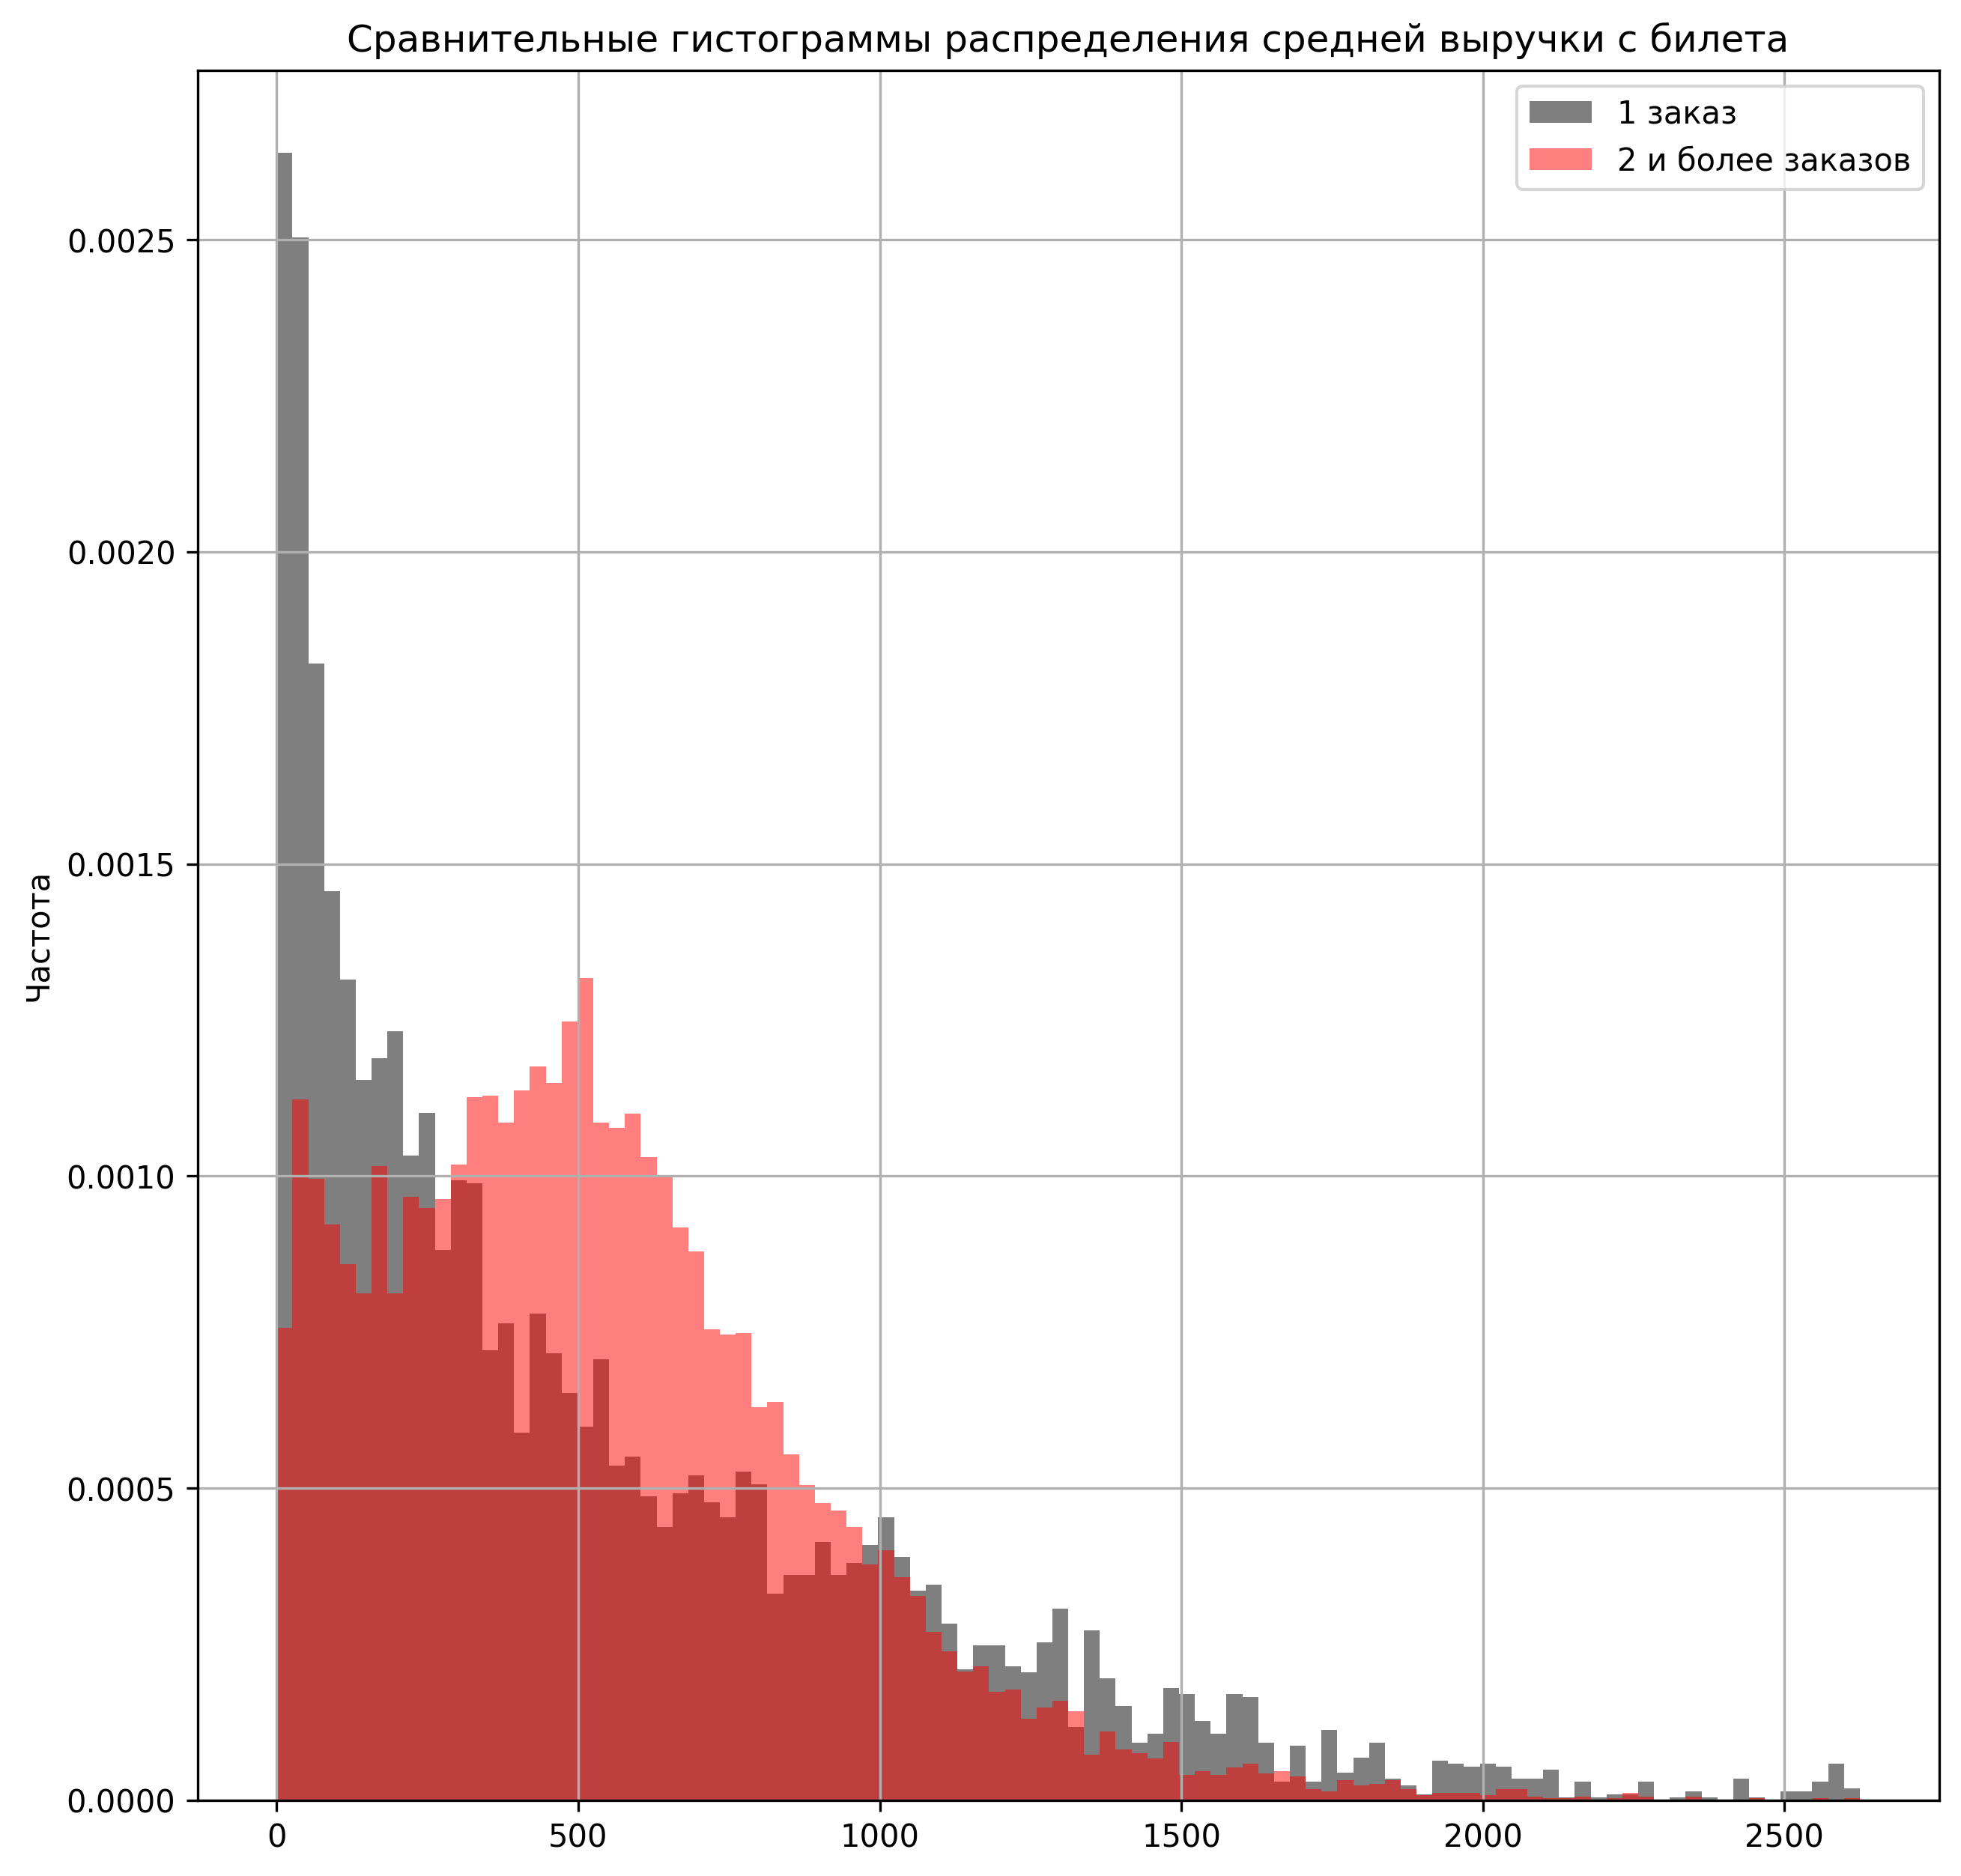

In [ ]:
one_data = user_profile[user_profile['is_two']==False]['mean_revenue']
two_data = user_profile[user_profile['is_two']==True]['mean_revenue']

fig = plt.figure(figsize = (10, 10), dpi = 300)
one_data.plot(kind='hist', density=True, color='black', alpha=0.5, label='1 заказ', bins=100)
two_data.plot(kind='hist', density=True, color='red', alpha=0.5, label='2 и более заказов', bins=100)
plt.ylabel('Частота')
plt.title('Сравнительные гистограммы распределения средней выручки с билета')
plt.grid()
plt.legend()
plt.show()
plt.close(fig)

Пользователи, совершившие 1 заказ, имеют более низкую среднюю выручку, чем пользователи, совершившие 2 и более заказов, что может быть объяснено более высокими тратами пользователей, которые делают повторные заказы. 

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


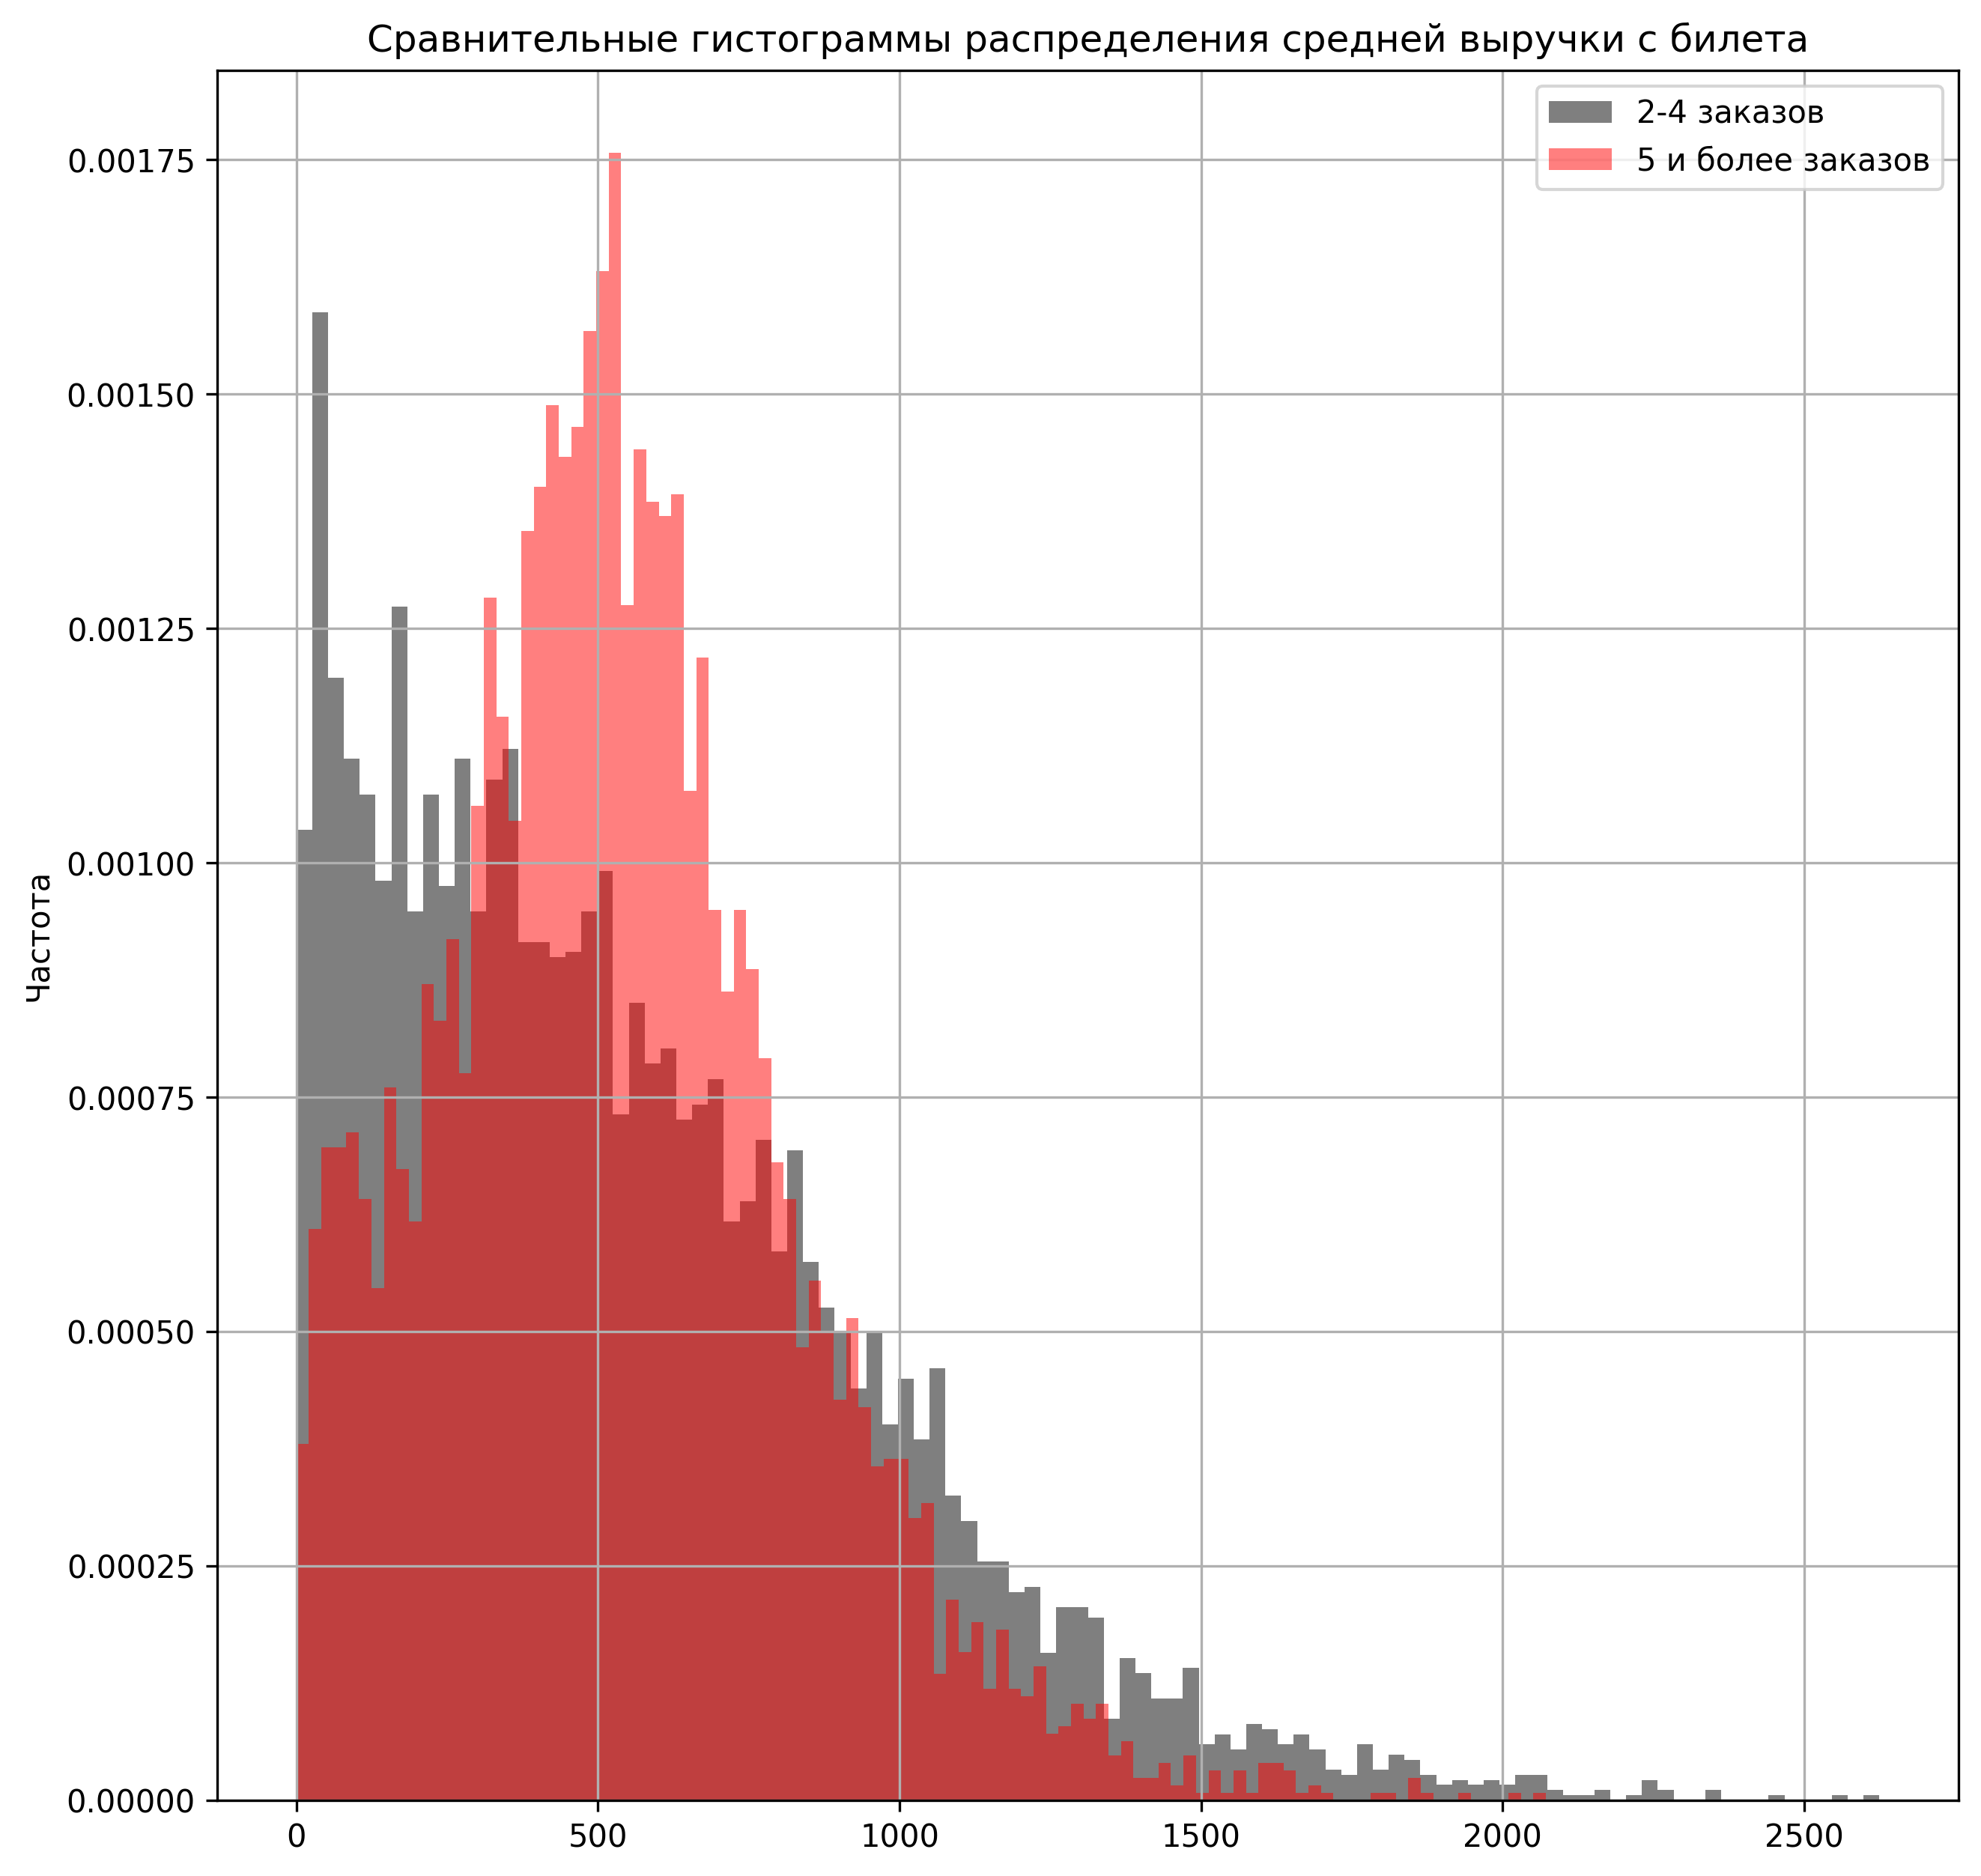

In [ ]:
one_data = user_profile[(user_profile['is_two']==True) & (user_profile['is_five']==False)]['mean_revenue']
two_data = user_profile[user_profile['is_five']==True]['mean_revenue']

fig = plt.figure(figsize = (10, 10), dpi = 300)
one_data.plot(kind='hist', density=True, color='black', alpha=0.5, label='2-4 заказов', bins=100)
two_data.plot(kind='hist', density=True, color='red', alpha=0.5, label='5 и более заказов', bins=100)
plt.ylabel('Частота')
plt.title('Сравнительные гистограммы распределения средней выручки с билета')
plt.grid()
plt.legend()
plt.show()
plt.close(fig)

Пользователи, совершившие 2-4 заказов, имеют более низкую среднюю выручку, чем пользователи, совершившие 5 и более заказов, что может быть объяснено более высокими тратами пользователей, которые делают повторные заказы. 

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

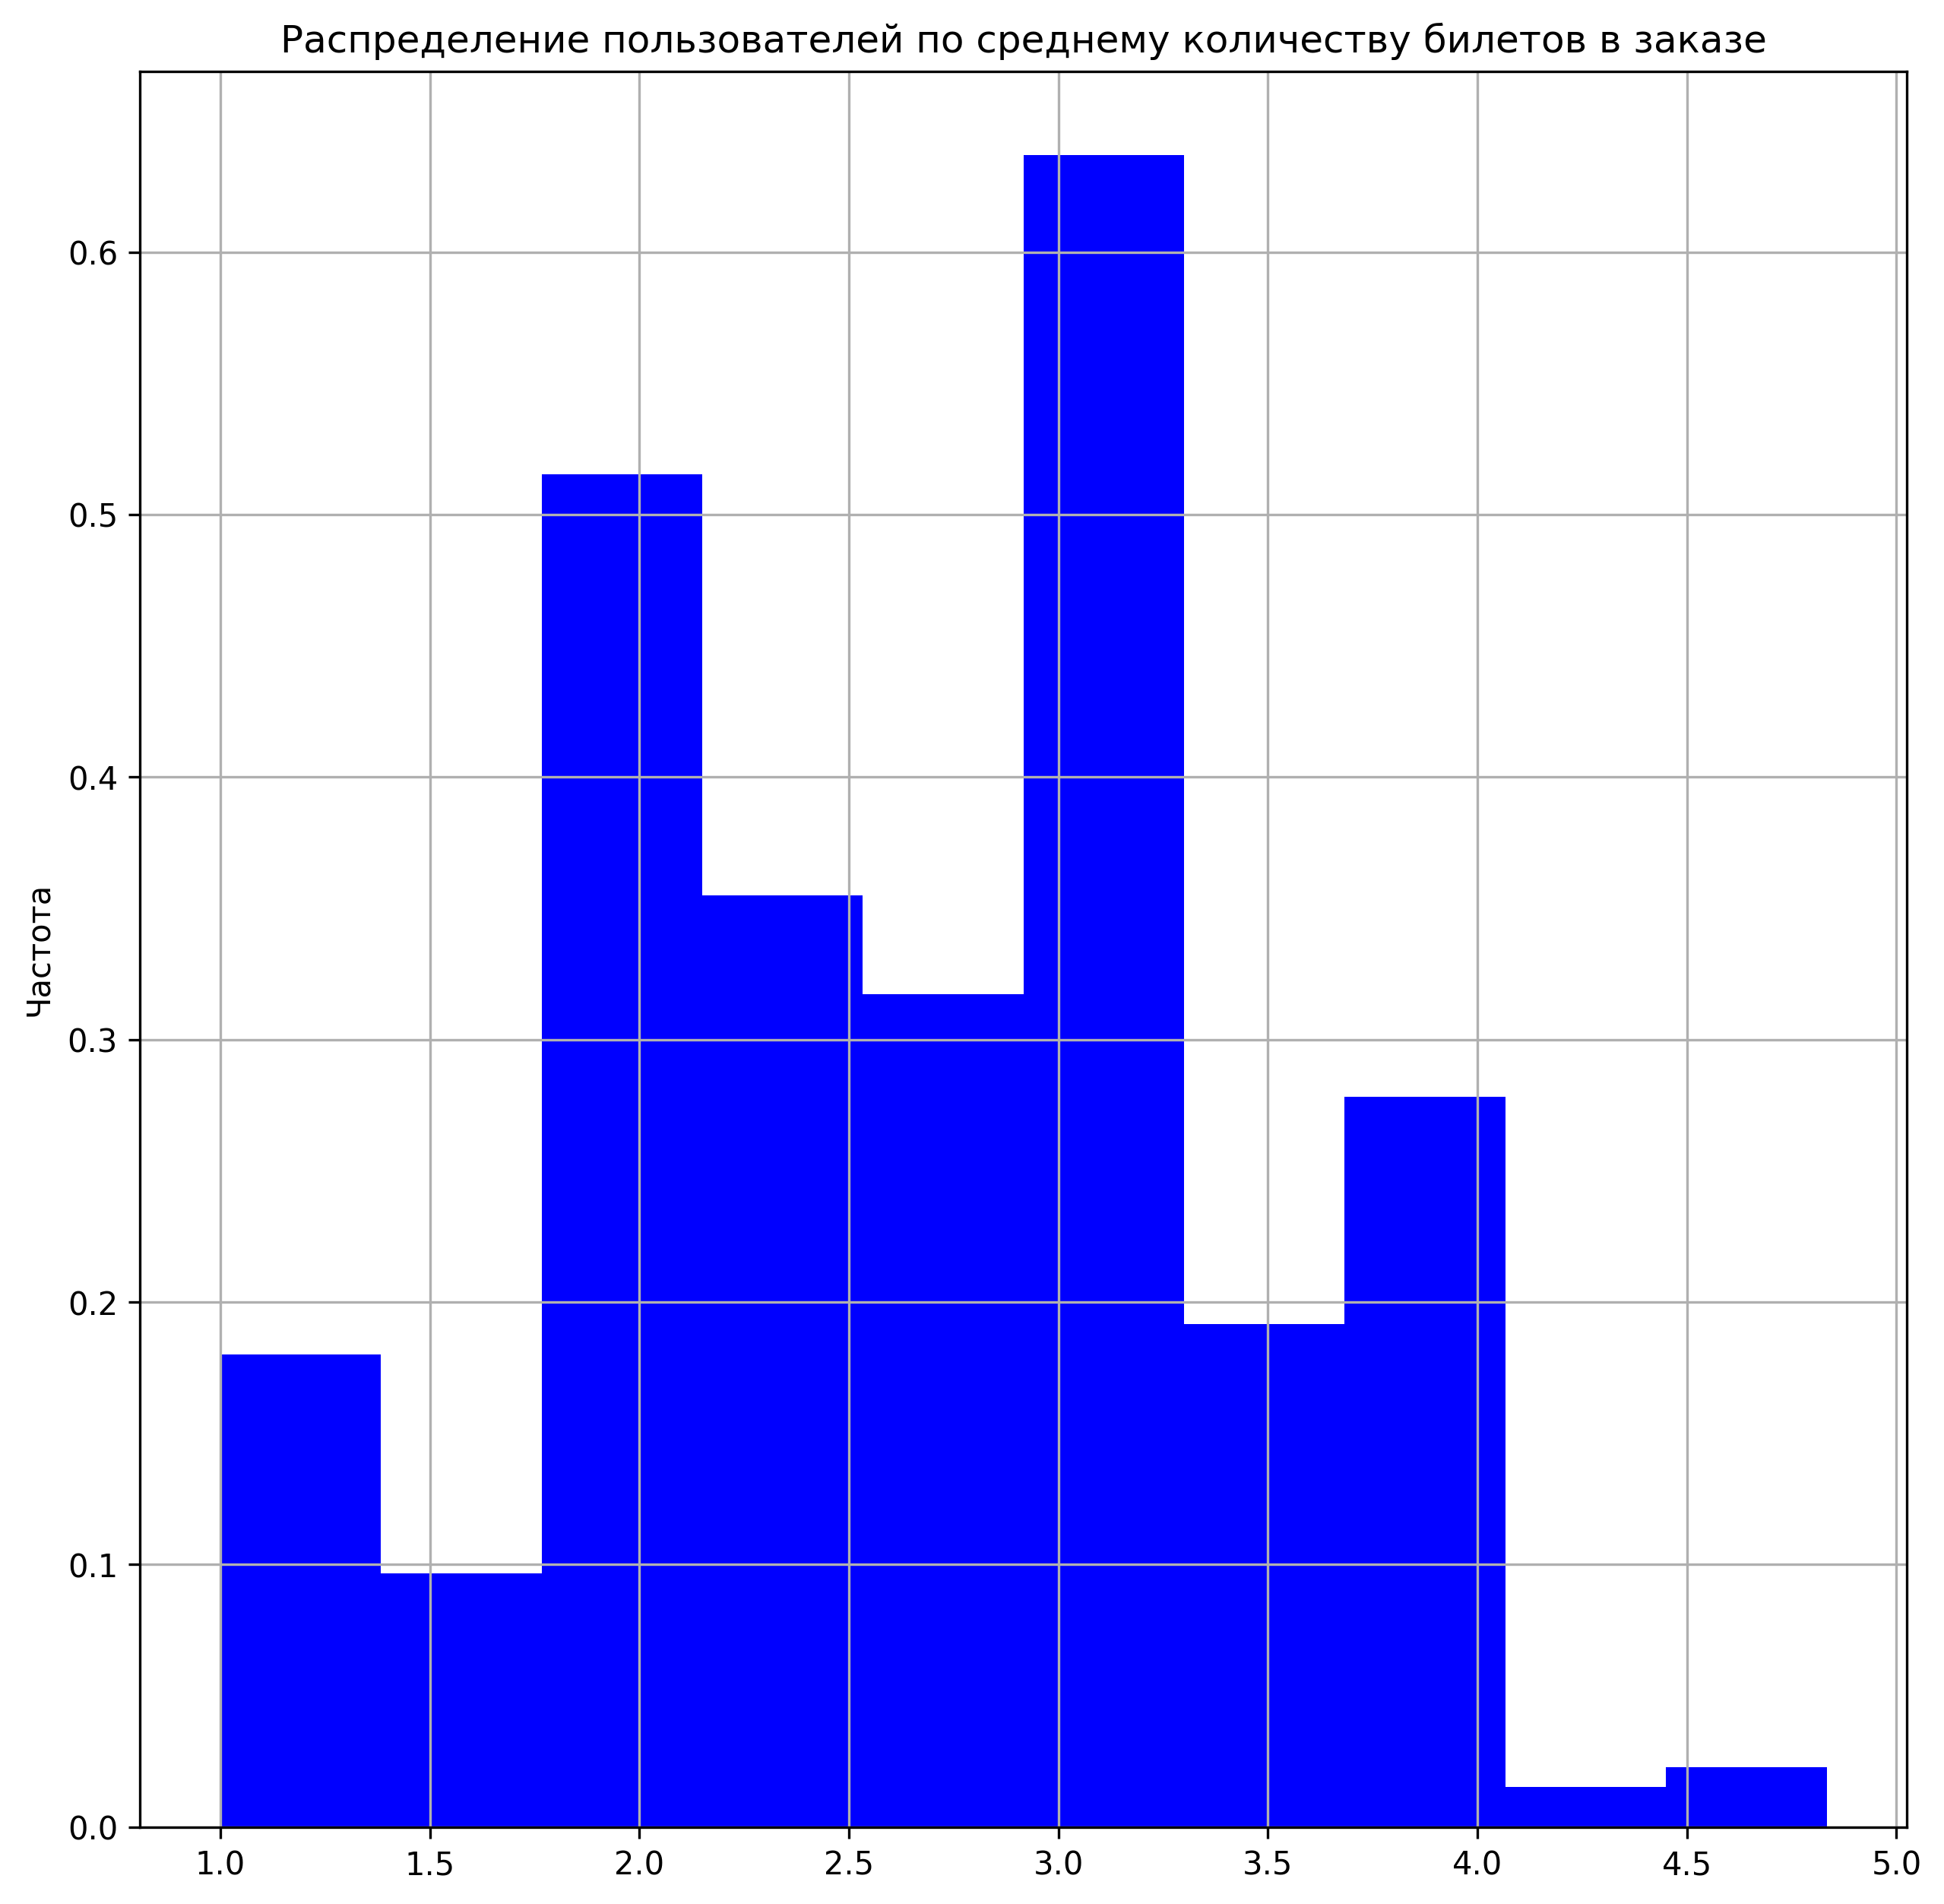

In [ ]:
fig = plt.figure(figsize = (10, 10), dpi = 300)
user_profile['mean_tickets_count'].plot(kind='hist', density=True, color='blue', bins=10)

plt.ylabel('Частота')
plt.title('Распределение пользователей по среднему количеству билетов в заказе')
plt.grid()
plt.show()
plt.close(fig)

In [ ]:
def create_ticket_category(row):
    if 1 <= row['mean_tickets_count'] < 2:
        return 'от 1 до 2 билетов'
    elif 2 <= row['mean_tickets_count'] < 3:
        return 'от 2 до 3 билетов'
    elif 3 <= row['mean_tickets_count'] < 5:
        return 'от 3 до 5 билетов'
    elif 5 <= row['mean_tickets_count']:
        return 'от 5 и более билетов'

In [ ]:
user_profile['ticket_category'] = user_profile.apply(create_ticket_category, axis=1)
user_profile.head()

,user_id,first_order_date,last_order_date,device_first,region_first,service_first,event_type_first,total_orders,mean_revenue,mean_tickets_count,mean_days_since_prev,is_two,is_five,ticket_category
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,mobile,каменевский регион,край билетов,театр,1,1521.940000,4.000000,NaN,False,False,от 3 до 5 билетов
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,mobile,каменевский регион,мой билет,выставки,2,774.010000,3.000000,75.0,True,False,от 3 до 5 билетов
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,mobile,североярская область,лови билет!,другое,3,767.213333,2.666667,51.0,True,False,от 2 до 3 билетов
3,00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,desktop,каменевский регион,край билетов,театр,1,917.830000,4.000000,NaN,False,False,от 3 до 5 билетов
4,000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,mobile,поленовский край,лучшие билеты,театр,2,61.310000,1.500000,16.0,True,False,от 1 до 2 билетов


In [ ]:
user_profile.groupby('ticket_category').agg({'user_id': 'count', 'is_two': 'mean'})

,user_id,is_two
ticket_category,,
от 1 до 2 билетов,2412,0.512852
от 2 до 3 билетов,9481,0.735365
от 3 до 5 билетов,9058,0.543056


Пользователи распределены по сегментам примерно равномерно. Пользователи с заказом от 2 до 3 билетов имеют высокую долю повторных покупок, что может объясняться регулярностью совместных посещений мероприятий парами и друзьями.

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [ ]:
user_profile['day_week'] = user_profile['first_order_date'].dt.day_name()

In [ ]:
plot_data = user_profile.groupby('day_week').agg({'user_id': 'count', 'is_two': 'mean'})
plot_data

,user_id,is_two
day_week,,
Friday,3148,0.612452
Monday,2847,0.639972
Saturday,3218,0.643257
Sunday,2691,0.615385
Thursday,3022,0.605559
Tuesday,3056,0.631872
Wednesday,2969,0.636915


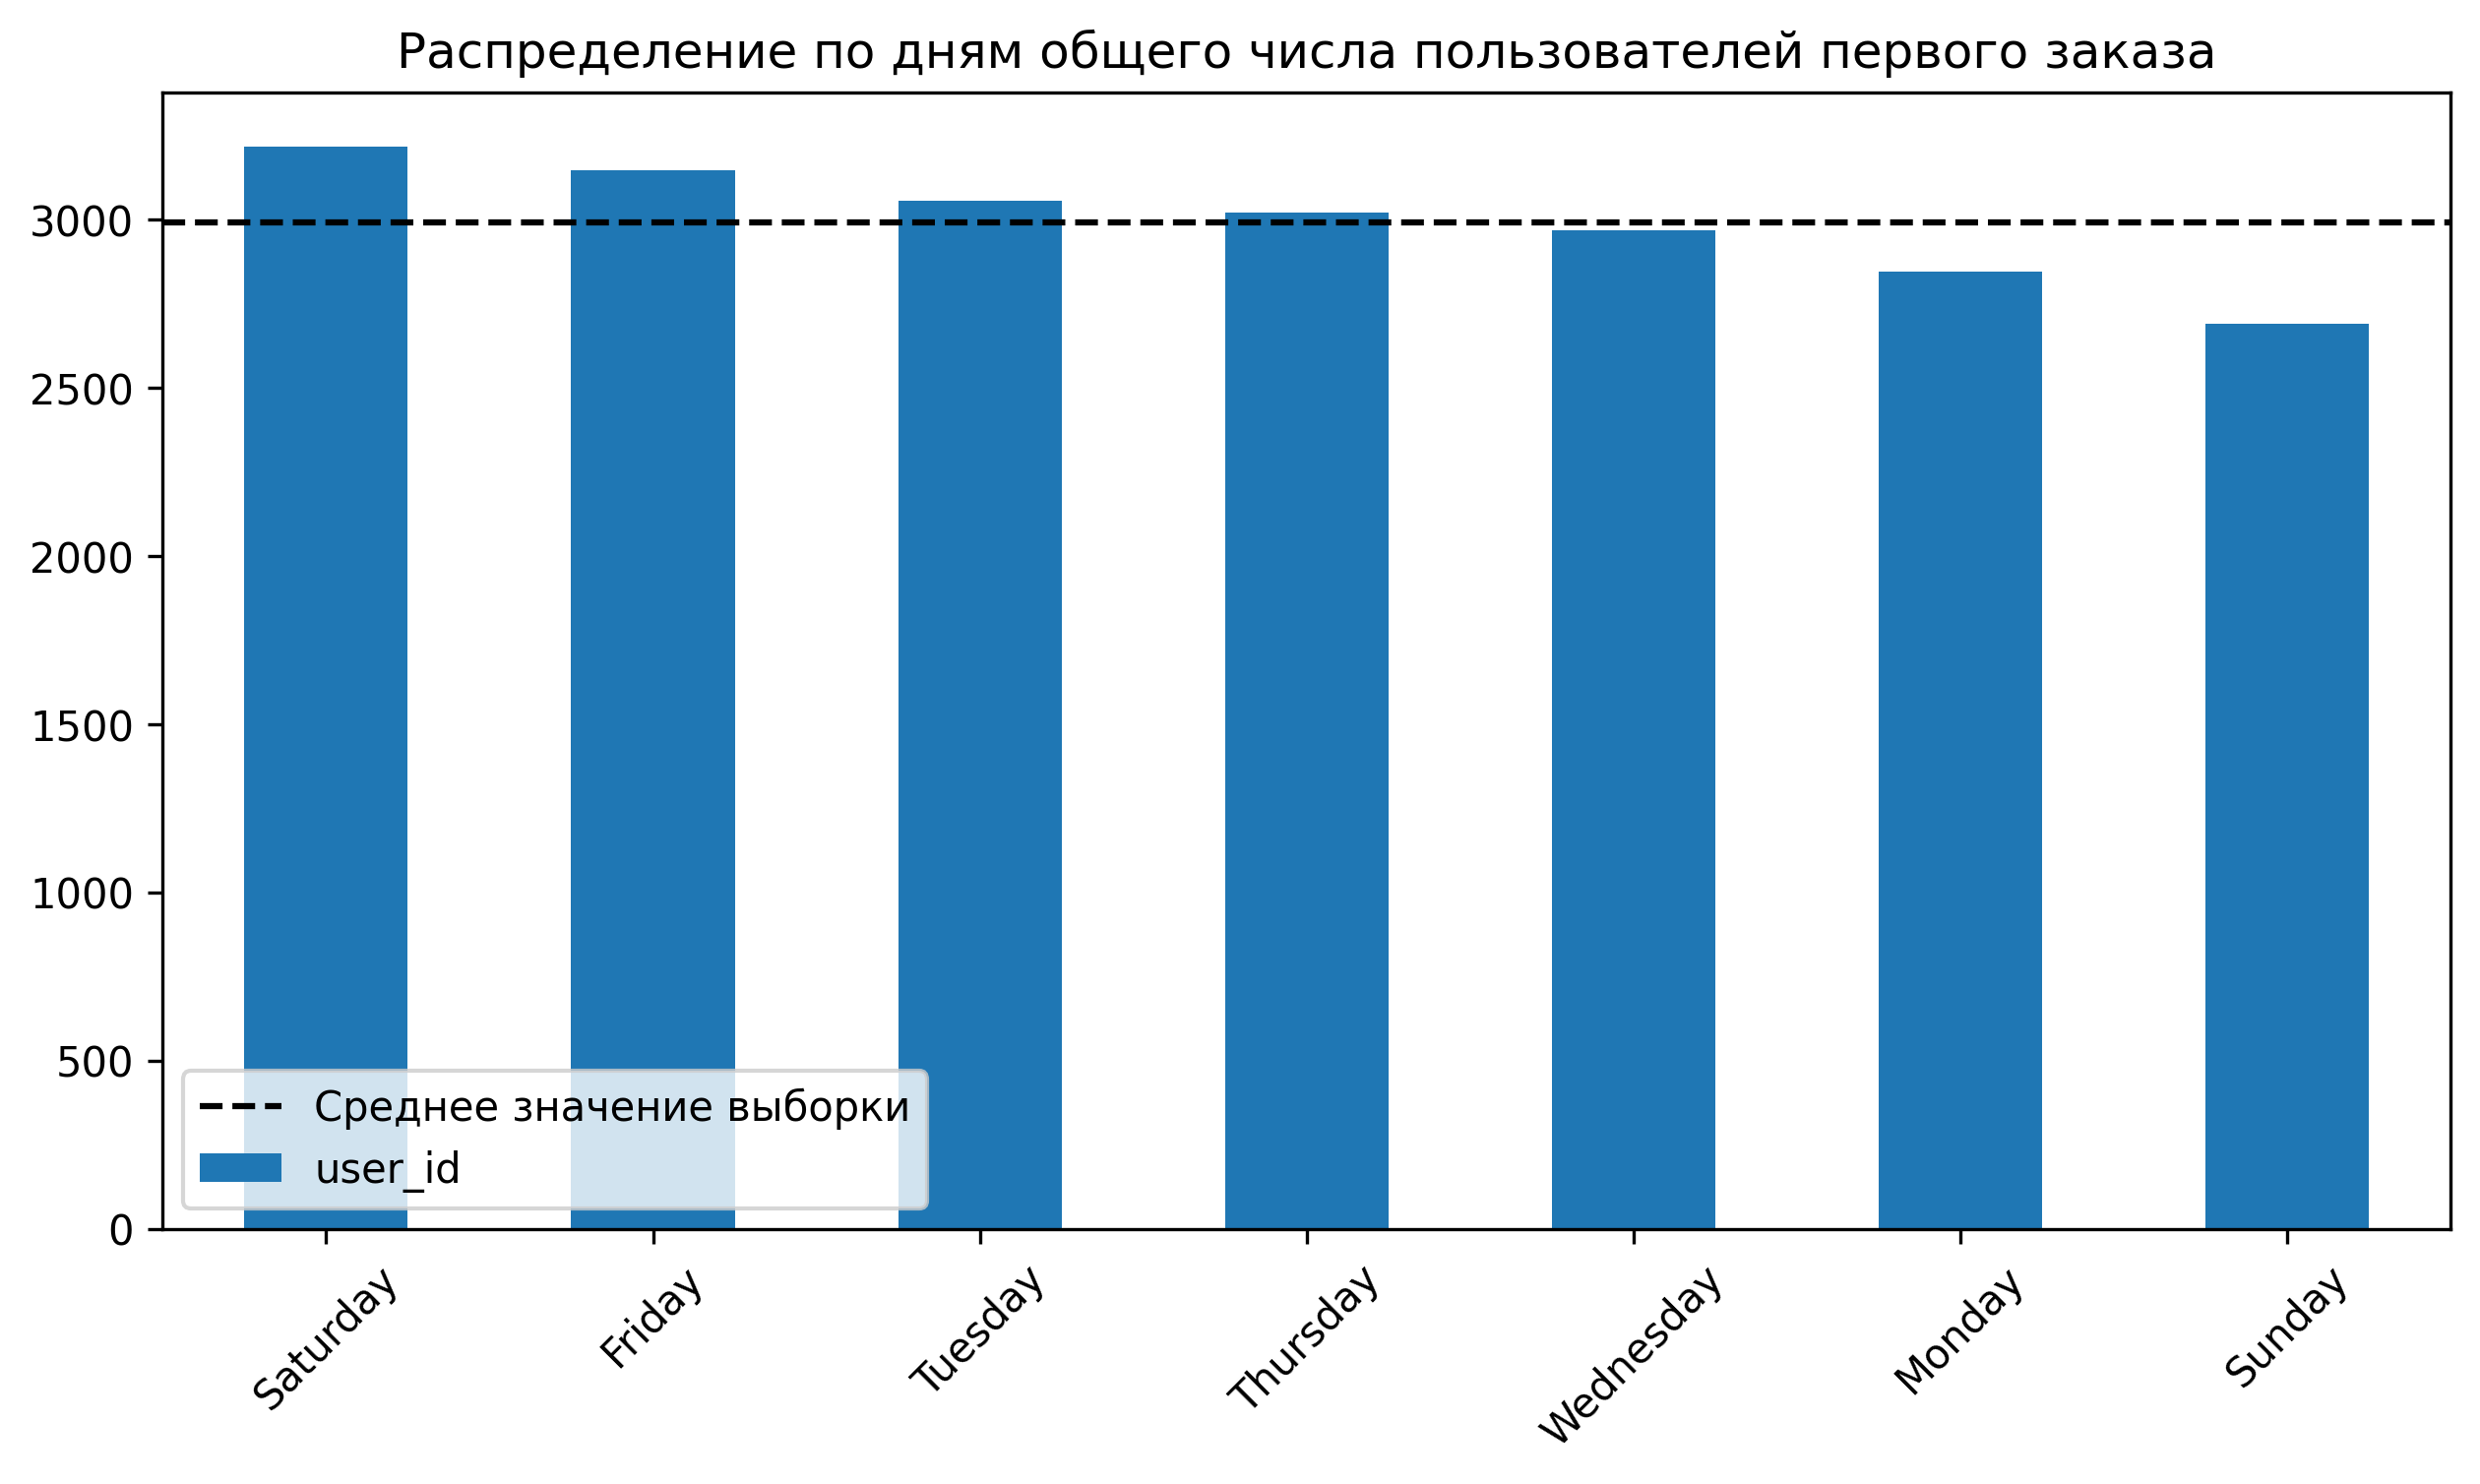

In [ ]:
visualise_data(plot_data['user_id'].sort_values(ascending=False), title=f'Распределение по дням общего числа пользователей первого заказа', xlabel = '', figsize = (10, 5), kind = 'bar')

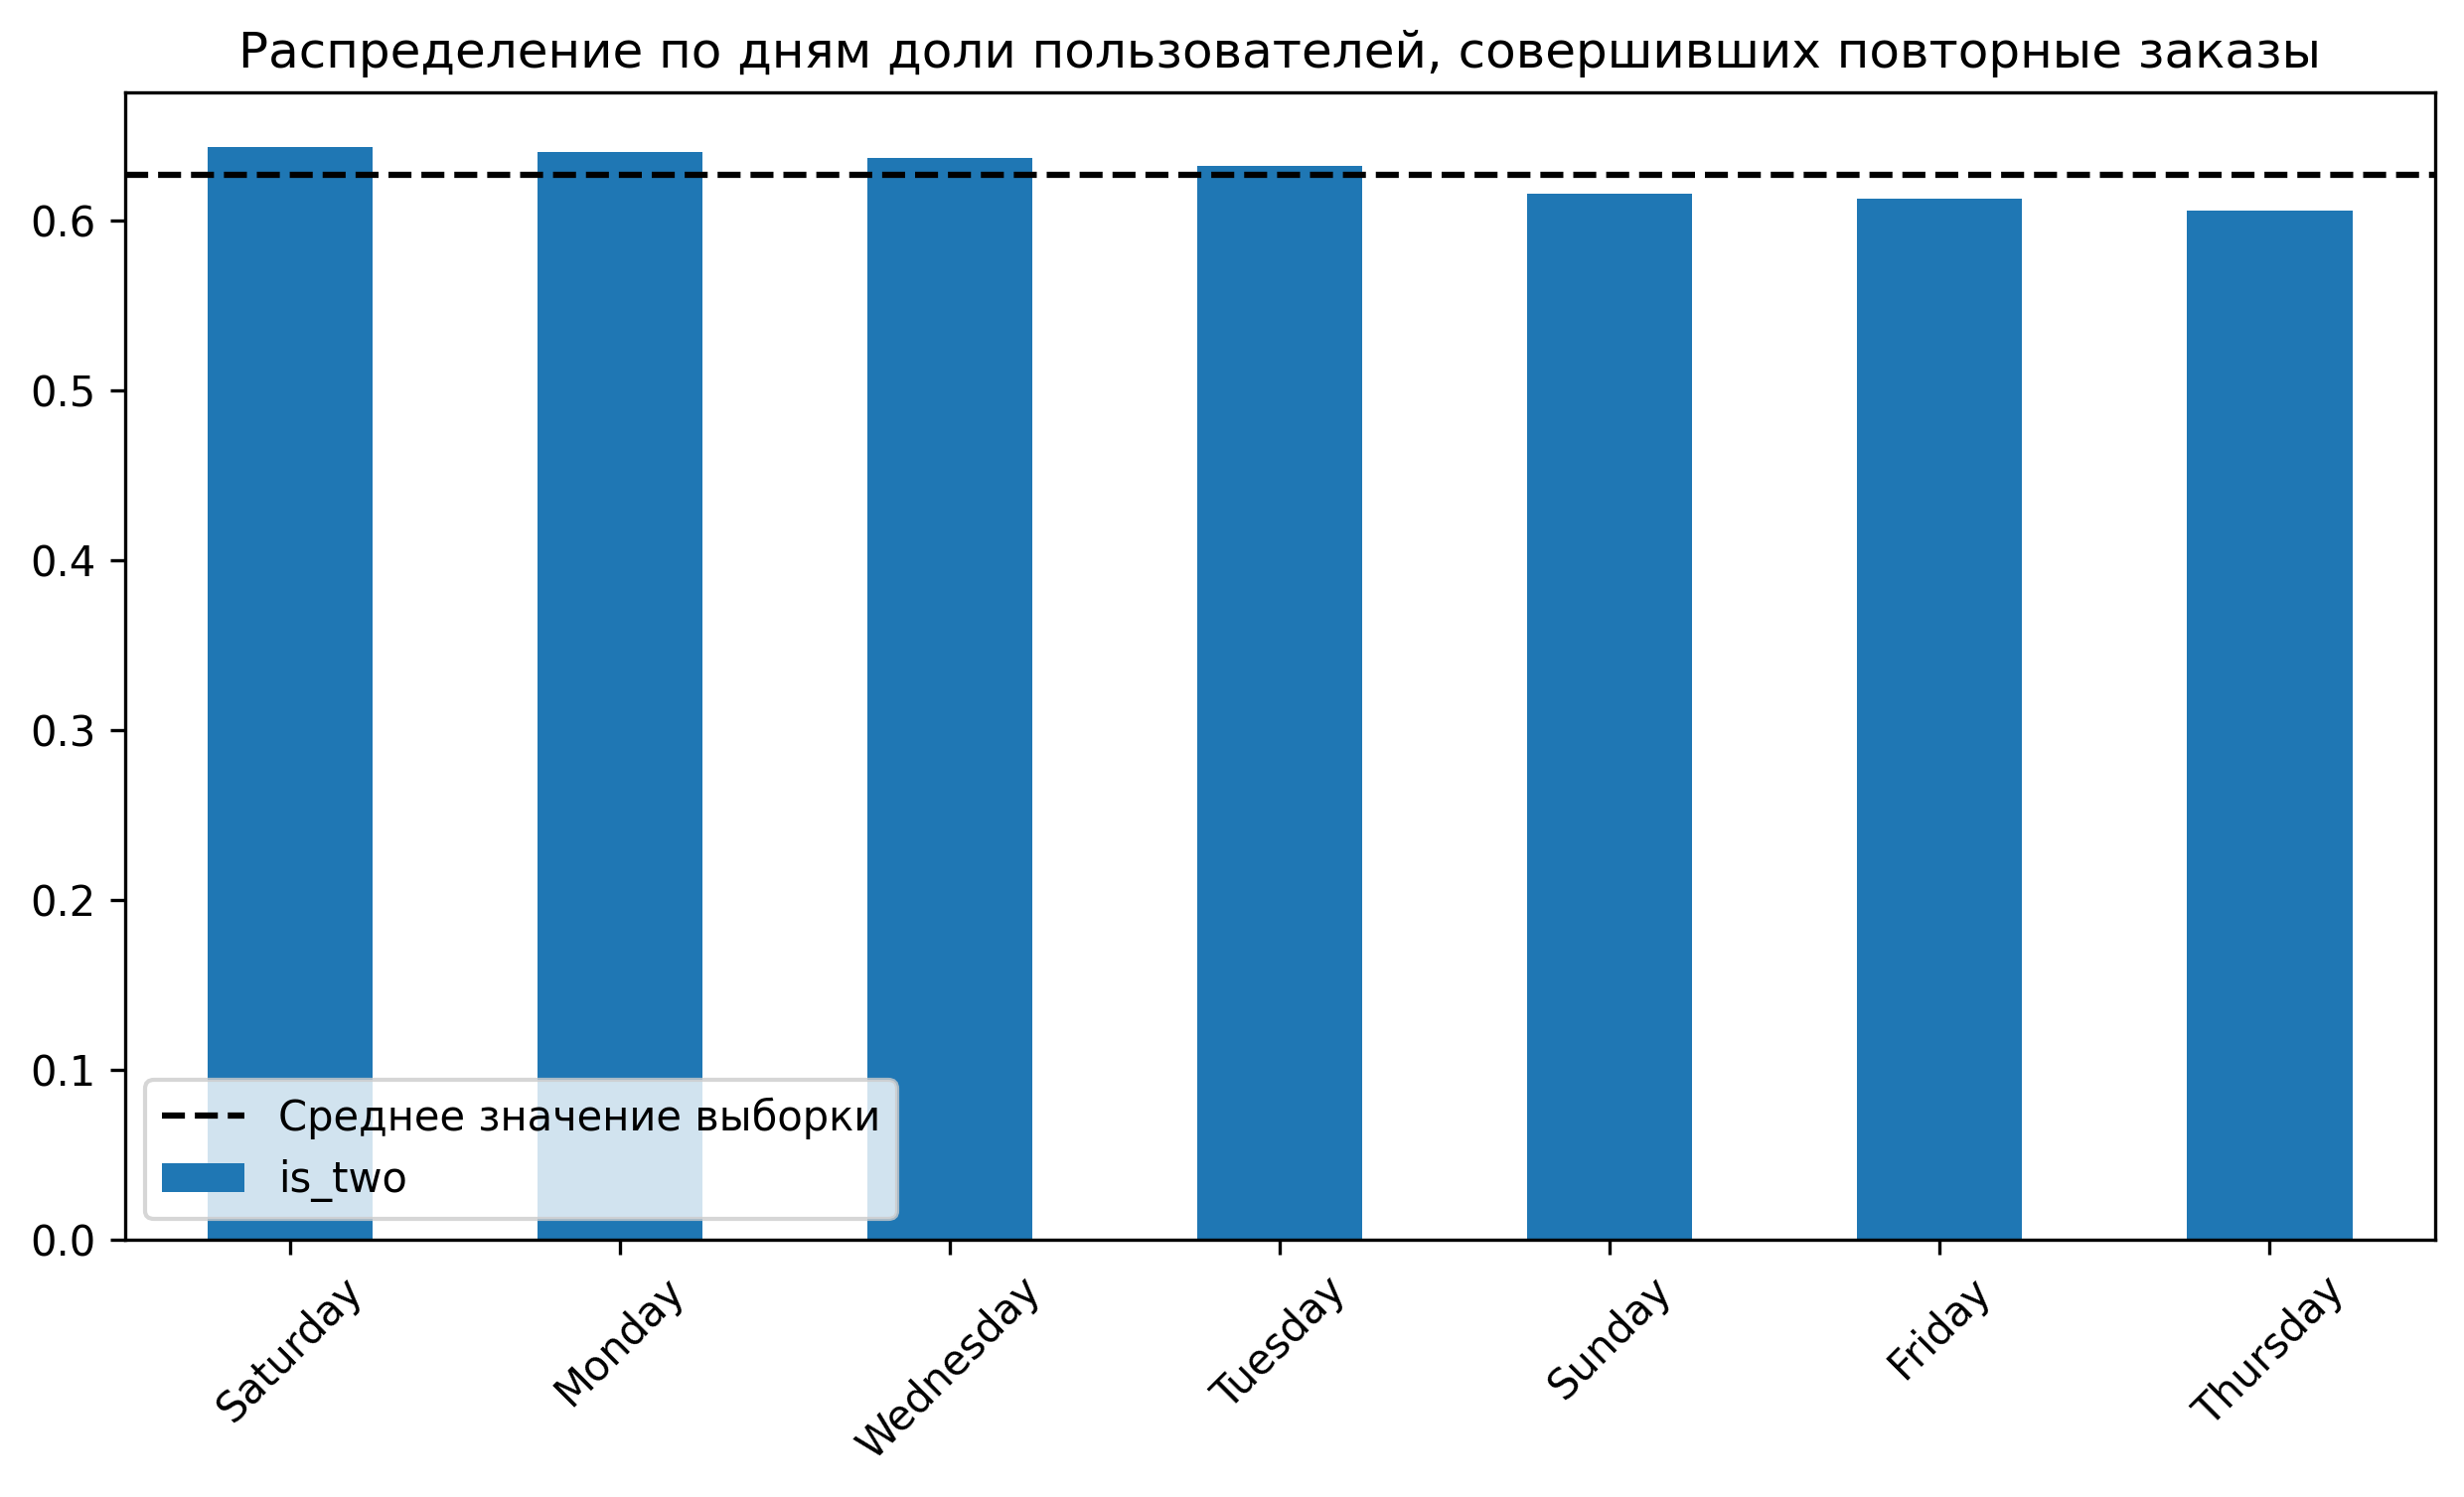

In [ ]:
visualise_data(plot_data['is_two'].sort_values(ascending=False), title=f'Распределение по дням доли пользователей, совершивших повторные заказы', xlabel = '', figsize = (10, 5), kind = 'bar')

День недели, в которую совершена первая покупка, не влияет на вероятность возврата клиента.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [ ]:
one_data = user_profile[(user_profile['is_two']==True) & (user_profile['is_five']==False)]['mean_days_since_prev']
two_data = user_profile[user_profile['is_five']==True]['mean_days_since_prev']

In [ ]:
print(f'Cреднее время между заказами для пользователей, совершивших 2–4 заказа = {round(one_data.mean(),2)}')
print(f'Cреднее время между заказами для пользователей, совершивших 5 и более заказов = {round(two_data.mean(),2)}')

Cреднее время между заказами для пользователей, совершивших 2–4 заказа = 21.53
Cреднее время между заказами для пользователей, совершивших 5 и более заказов = 9.93


Средний интервал между заказами влияет на вероятность повторного заказа обратно пропорциально. Чем он меньше, тем больше повторных заказов.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [ ]:
correlation_matrix = user_profile[['device_first', 'region_first','service_first', 'event_type_first', 'total_orders', 'mean_revenue', 'mean_tickets_count']].phik_matrix(interval_cols = ['total_orders', 'mean_revenue', 'mean_tickets_count'])
correlation_matrix

,device_first,region_first,service_first,event_type_first,total_orders,mean_revenue,mean_tickets_count
device_first,1.000000,0.114452,0.081769,0.061615,0.028328,0.075332,0.056488
region_first,0.114452,1.000000,0.697145,0.506984,0.124616,0.354660,0.131067
service_first,0.081769,0.697145,1.000000,0.586646,0.033132,0.381036,0.086211
event_type_first,0.061615,0.506984,0.586646,1.000000,0.029266,0.329348,0.084095
total_orders,0.028328,0.124616,0.033132,0.029266,1.000000,0.223405,0.384730
mean_revenue,0.075332,0.354660,0.381036,0.329348,0.223405,1.000000,0.471800
mean_tickets_count,0.056488,0.131067,0.086211,0.084095,0.384730,0.471800,1.000000


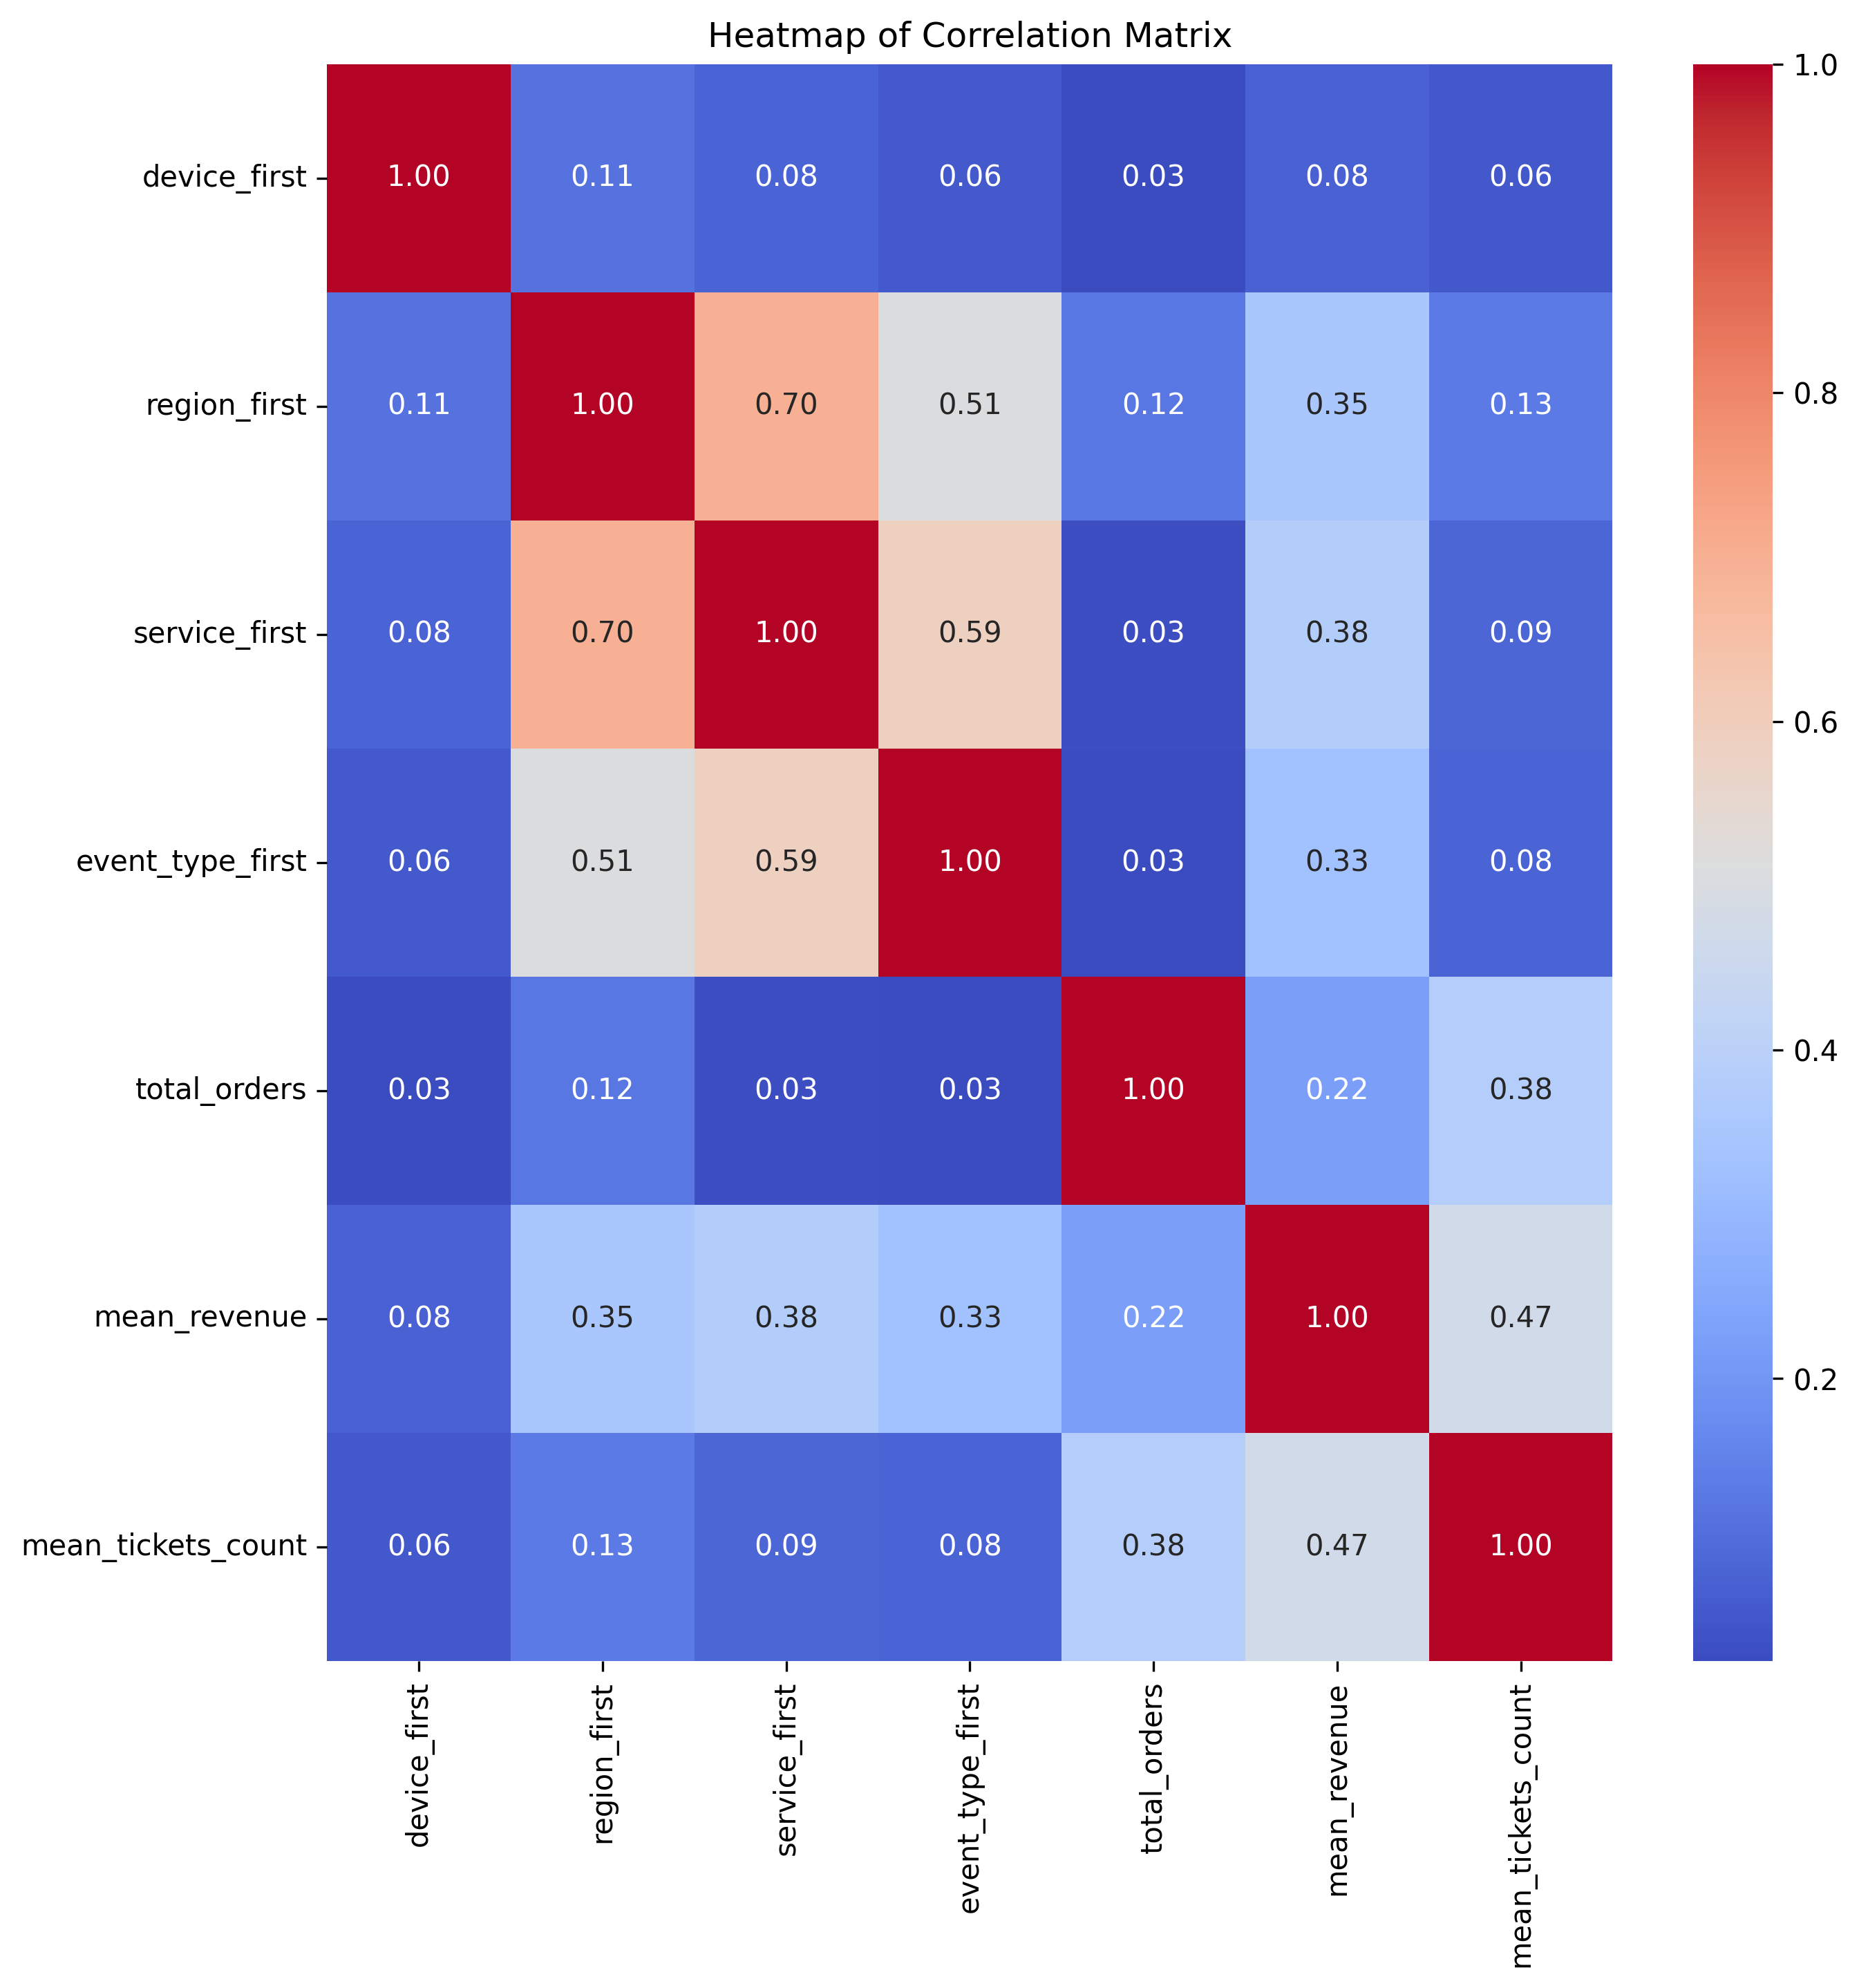

In [ ]:
plt.figure(figsize=(10, 10), dpi = 300)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Heatmap of Correlation Matrix')
plt.show()

In [ ]:
phik_correlations = correlation_matrix['total_orders'].drop('total_orders').sort_values(ascending=False)

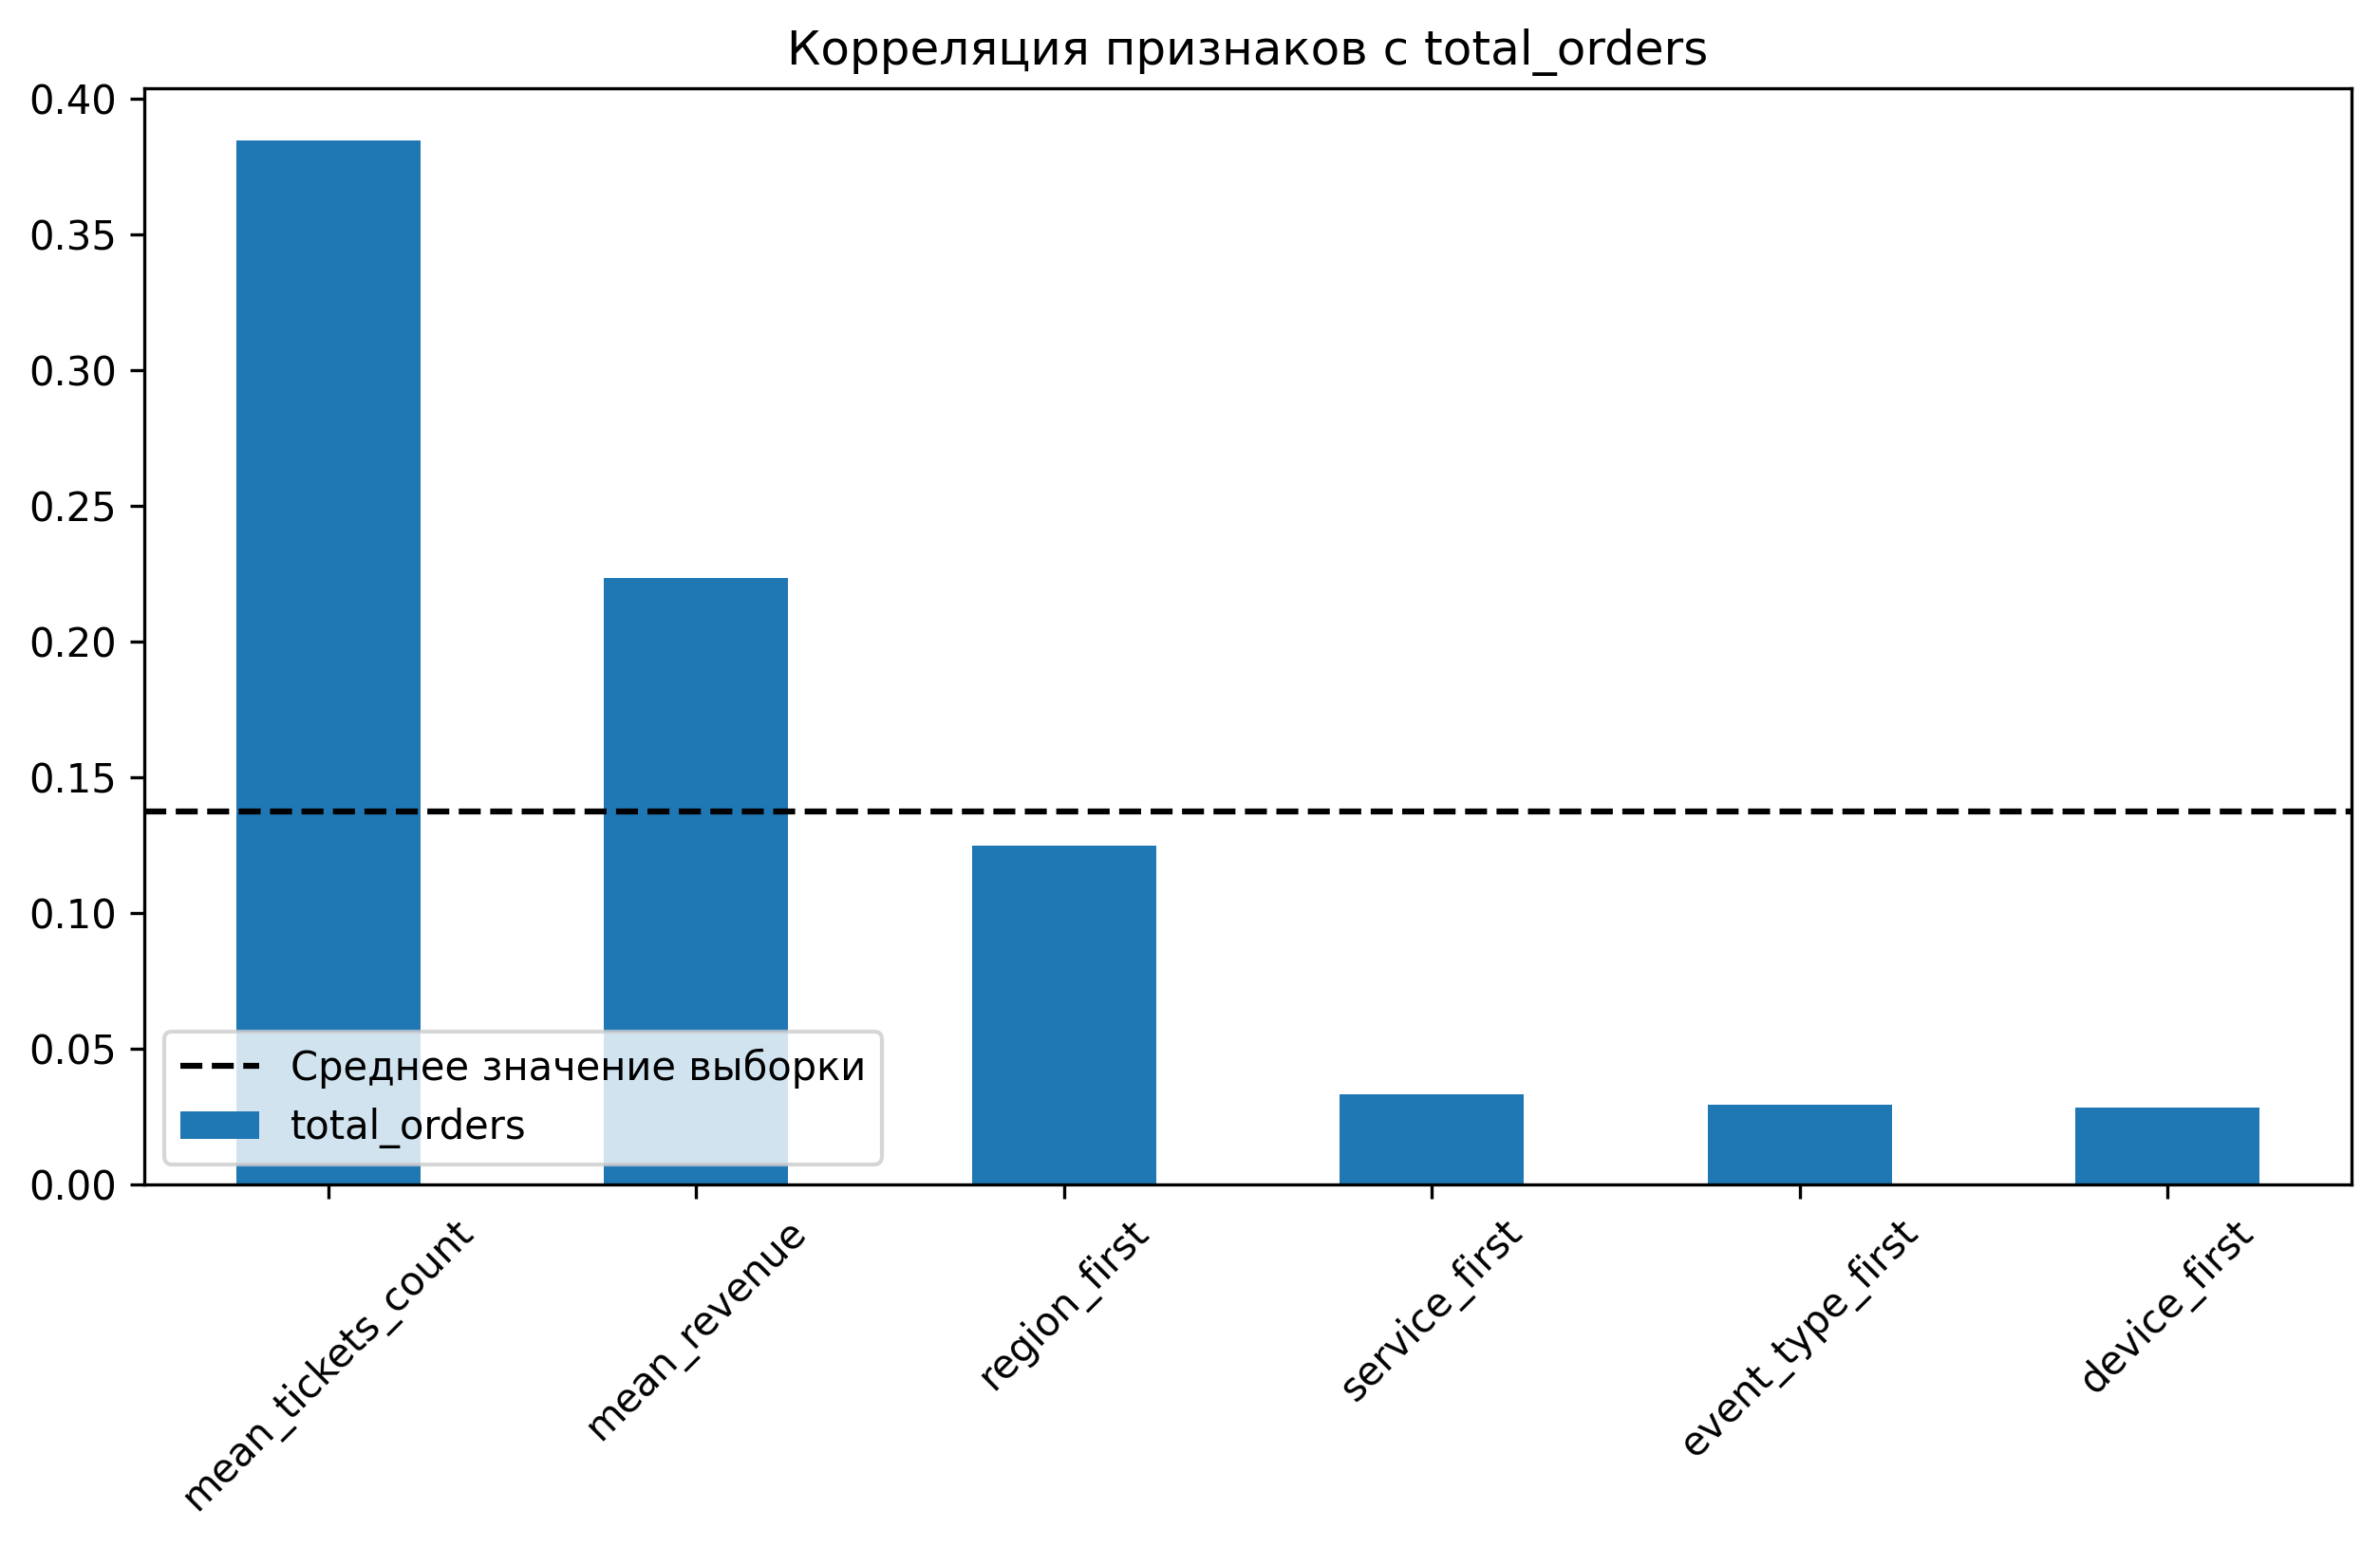

In [ ]:
visualise_data(phik_correlations, 
          title = 'Корреляция признаков с total_orders',
          figsize = (10, 5), 
          kind='bar')

С количеством заказов наиболее связаны среднее количество билетов в заказе и средняя выручка с одного заказа в рублях.

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

Был проведен исследовательский анализ данных поведения пользователей Яндекс Афиши в целях изучения их лояльности чтобы понять, какие пользователи с большей вероятностью возвращаются на платформу и делают заказы повторно.

Первым делом была проведена подготовка данных, а именно фильтрация выбросов, приведение полей к нужным типам данных и унификация представления финансовых данных путем приведения всех денежных обозначенйи в рубли.

Для анализа пользовательского поведения был создан профиль пользователя, в результате анализа которого можно сформулировать некоторые выводы:

* Пользователи распределены равномерно по билетному оператору, продавшему билеты на первый заказ. Явными «точками входа» являются мобильные устройства, с которых осуществлено 82% первых заказов, а также почти половина первых заказов были сделаны на концерты.

* Пользователи, совершившие 1 заказ, имеют более низкую среднюю выручку, чем пользователи, совершившие 2 и более заказов, что может быть объяснено более высокими тратами пользователей, которые делают повторные заказы.

* Пользователи с заказом от 2 до 3 билетов имеют высокую долю повторных покупок, что может объясняться регулярностью совместных посещений мероприятий парами и друзьями.

* С количеством заказов наиболее связаны среднее количество билетов в заказе и средняя выручка с одного заказа в рублях.

На основе проведенного анализа можно дать некоторые рекомендации, а именно:
* Развитие мобильного приложения, поскольку с него идет основной трафик новых пользователей.
* Мотивация покупок билетов компаниями из нескольких человек и пар, поскольку такие пользователей с высокой долей вероятности совершат повторную покупку. 

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**